In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [15]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [16]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [17]:
class DataFile(object):
    def __init__(self, path, name, aliases={}):
        self.path = path
        self.name = name
        self.aliases = aliases
        self.raw = uproot.open(self.path)
    def features(self):
        return sorted(list(set(list(self.raw.keys()) + list(self.aliases.keys()))))
    def true_features(self):
        return [name for name in self.features() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=(self.aliases|aliases), library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [18]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [19]:
tree_names_nohits = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [20]:
tree_names_hits = [
    "RapidSim/B2Kee_tree-2Dhits.root:DecayTree;27",
    "RapidSim/B2KJpsi2ee_tree-2Dhits.root:DecayTree;34",
    "RapidSim/B2Kpsi2s2ee_tree-2Dhits.root:DecayTree;35",
    "RapidSim/D2phipi2ee_tree-2Dhits.root:DecayTree;30",
]

In [21]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names_nohits, channel_names)]

In [22]:
files[3].aliases = {
    'B_FD': "D_FD",
    'B_FD_TRUE': "D_FD_TRUE",
}

In [23]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['B_FD_TRUE',
 'angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [24]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [25]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [26]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2, true=True):
    feature = "q2_TRUE" if true else "q2"
    return join_and("%s > %g" % (feature, v1), "%s < %g" % (feature, v2))

In [27]:
def e_selectors(true=True):
    q_Kll_selector = q2_range(1.1, 6.0, true)
    q_Jpsi_e_selector = q2_range(6.0, 12.96, true)
    q_psi2S_e_selector = q2_range(9.82, 16.40, true)
    selectors = [
        q_Kll_selector,
        q_Jpsi_e_selector,
        q_psi2S_e_selector,
        "True",
    ]
    return selectors

#q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [28]:
selectors_true = e_selectors(True)
selectors_notrue = e_selectors(False)

In [29]:
selected_true = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors_true)]
selected_notrue = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors_notrue)]

In [30]:
splitted_true = [split(f, shuffle=True, test_size=0.2) for f in selected_true]
train_ds_true = [x[0] for x in splitted_true]
test_ds_true = [x[1] for x in splitted_true]

In [31]:
splitted_notrue = [split(f, shuffle=True, test_size=0.2) for f in selected_notrue]
train_ds_notrue = [x[0] for x in splitted_notrue]
test_ds_notrue = [x[1] for x in splitted_notrue]

In [32]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected_true:
    df.loc[f.name(), "Selected true"] = len(f)
for f in train_ds_true:
    df.loc[f.name(), "Train true"] = len(f)
for f in test_ds_true:
    df.loc[f.name(), "Test true"] = len(f)
for f in selected_notrue:
    df.loc[f.name(), "Selected notrue"] = len(f)
for f in train_ds_notrue:
    df.loc[f.name(), "Train notrue"] = len(f)
for f in test_ds_notrue:
    df.loc[f.name(), "Test notrue"] = len(f)
df["Selected/Total true"] = df["Selected true"] / df["Total"]
df["Selected/Total notrue"] = df["Selected notrue"] / df["Total"]
df

#Events             Total  Selected true  Train true  Test true  \
B⁺→K⁺ee          970116.0       247104.0    197683.0    49421.0   
B⁺→K⁺J/ψ(→ee)    960234.0       929755.0    743804.0   185951.0   
B⁺→K⁺ψ(2S)(→ee)  986271.0       939679.0    751743.0   187936.0   
D⁺→π⁺φ(→ee)      830027.0       830027.0    664021.0   166006.0   

#Events          Selected notrue  Train notrue  Test notrue  \
B⁺→K⁺ee                 296675.0      237340.0      59335.0   
B⁺→K⁺J/ψ(→ee)           845739.0      676591.0     169148.0   
B⁺→K⁺ψ(2S)(→ee)         768614.0      614891.0     153723.0   
D⁺→π⁺φ(→ee)             830027.0      664021.0     166006.0   

#Events          Selected/Total true  Selected/Total notrue  
B⁺→K⁺ee                     0.254716               0.305814  
B⁺→K⁺J/ψ(→ee)               0.968259               0.880763  
B⁺→K⁺ψ(2S)(→ee)             0.952759               0.779313  
D⁺→π⁺φ(→ee)                 1.000000               1.000000

### KS tests

In [33]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [34]:
perform_ks_test(train_ds_notrue, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [35]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        try:
            plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
                density=True, histtype='step', bins=bins, **kwargs)
        except:
            pass
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

In [36]:
aliases = {
    "min_e_IP_TRUE": "fmin(ep_IP_TRUE,em_IP_TRUE)",
    "max_e_PT_TRUE": "fmax(ep_PT_TRUE,em_PT_TRUE)",
    "max_e_SIGMAIP_TRUE": "fmax(ep_SIGMAIP_TRUE,em_SIGMAIP_TRUE)",
    "max_e_P_TRUE": "fmax(ep_P_TRUE,em_P_TRUE)",
    
    "min_e_IP": "fmin(ep_IP,em_IP)",
    "max_e_PT": "fmax(ep_PT,em_PT)",
    "max_e_P": "fmax(ep_P,em_P)",
}

In [37]:
def features_plots(ds):
    feature_plot("log(B_FD)", ds, aliases, 101)
    feature_plot("log(max_e_SIGMAIP_TRUE)", ds, aliases, 101)
    feature_plot("log(angle_ee)", ds, aliases, 101)
    feature_plot("log(min_e_IP)", ds, aliases, 101)
    feature_plot("log(max_e_PT)", ds, aliases, 101)
    feature_plot("log(max_e_P)", ds, aliases, 101)

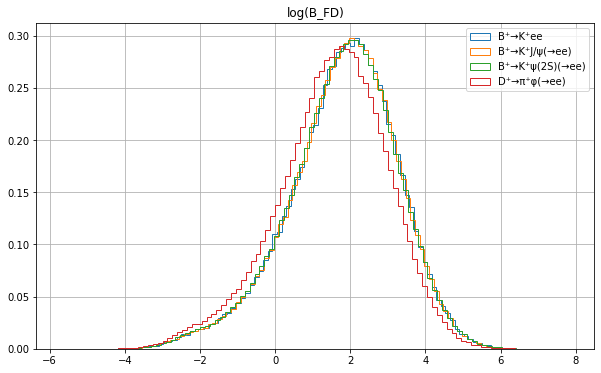

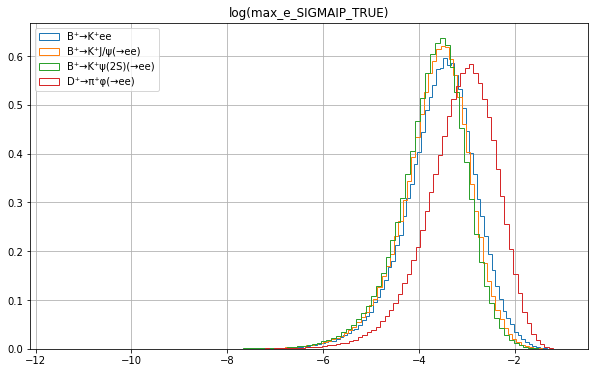

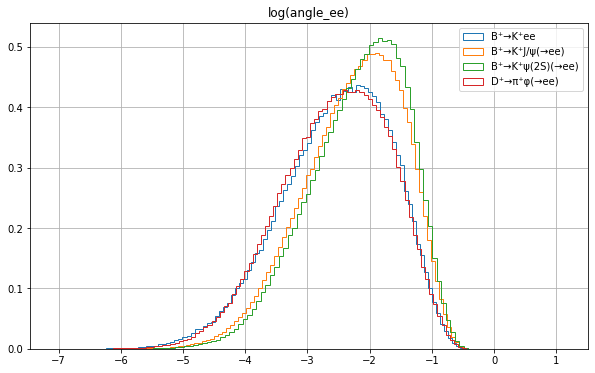

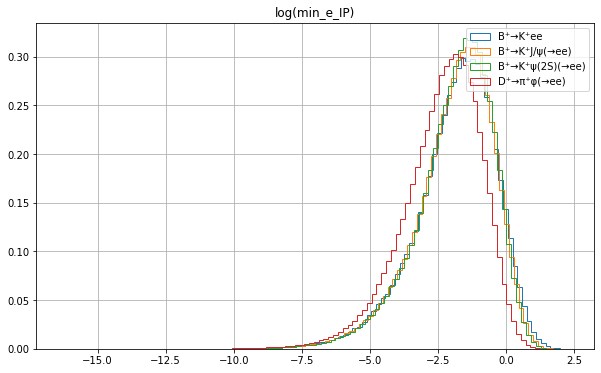

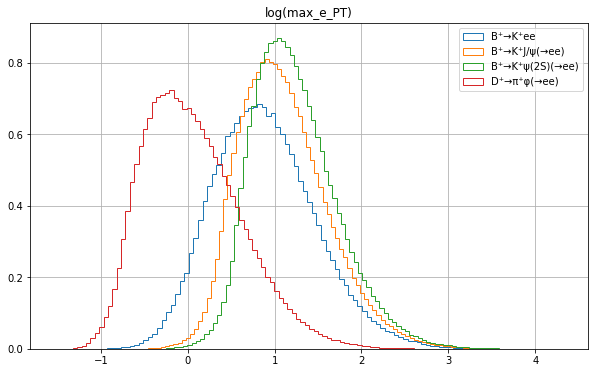

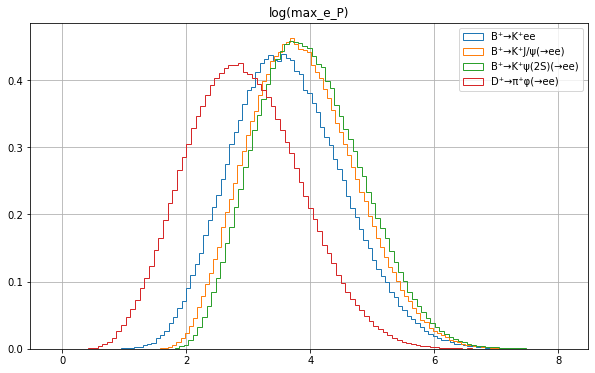

In [38]:
features_plots(train_ds_notrue)

### Preprocessing

In [39]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [40]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [41]:
feature_sets = [
    ("2p", [             "log(angle_ee)",                  "log(max_e_P)",                          ]),
    ("3p", ["log(B_FD)", "log(angle_ee)",                  "log(max_e_P)",                          ]),
    ("4p", ["log(B_FD)", "log(angle_ee)", "log(min_e_IP)", "log(max_e_P)",                          ]),
    ("5p", ["log(B_FD)", "log(angle_ee)", "log(min_e_IP)", "log(max_e_P)", "log(max_e_SIGMAIP_TRUE)"]),
    
    ("2",  [             "log(angle_ee)",                  "log(max_e_PT)",                          ]),
    ("3",  ["log(B_FD)", "log(angle_ee)",                  "log(max_e_PT)",                          ]),
    ("4",  ["log(B_FD)", "log(angle_ee)", "log(min_e_IP)", "log(max_e_PT)",                          ]),
    ("5",  ["log(B_FD)", "log(angle_ee)", "log(min_e_IP)", "log(max_e_PT)", "log(max_e_SIGMAIP_TRUE)"]),
]
train_datasets = [
    ("₄", train_ds_notrue),
    ("₃", train_ds_notrue[:3]),
]

all_datasets = list()
for f in feature_sets:
    for t in train_datasets:
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
all_datasets

[DS₄[2p],
 DS₃[2p],
 DS₄[3p],
 DS₃[3p],
 DS₄[4p],
 DS₃[4p],
 DS₄[5p],
 DS₃[5p],
 DS₄[2],
 DS₃[2],
 DS₄[3],
 DS₃[3],
 DS₄[4],
 DS₃[4],
 DS₄[5],
 DS₃[5]]

In [42]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [43]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

In [44]:
#fig, ax = plt.subplots(3, 2, figsize=(10, 15))
#for i in range(6):
#    plot_ds(all_datasets[i], scale=2.0, ax=ax[i//2,i%2])
#plt.show()

### NN

In [45]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [46]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [47]:
def train_estimator(dataset, model, device=device):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=False)
    loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=True)
    return model.eval()

In [48]:
def make_estimator(dataset, device=device):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources))
    return torch.nn.Sequential(scaler, m).to(device)

In [49]:
%%time
all_est = list()
for ds in all_datasets:
    est = make_estimator(ds)
    train_estimator(ds, est)
    all_est.append(est)
all_est

INFO:root:Epoch 0, 1.410480
INFO:root:Epoch 1, 1.384081
INFO:root:Epoch 2, 1.374130
INFO:root:Epoch 3, 1.352874
INFO:root:Epoch 4, 1.299091
INFO:root:Epoch 5, 1.187340
INFO:root:Epoch 6, 1.031379
INFO:root:Epoch 7, 0.918201
INFO:root:Epoch 8, 0.884288
INFO:root:Epoch 9, 0.878151
INFO:root:Epoch 10, 0.875351
INFO:root:Epoch 11, 0.872730
INFO:root:Epoch 12, 0.870078
INFO:root:Epoch 13, 0.867343
INFO:root:Epoch 14, 0.864542
INFO:root:Epoch 15, 0.861634
INFO:root:Epoch 16, 0.858667
INFO:root:Epoch 17, 0.855667
INFO:root:Epoch 18, 0.852627
INFO:root:Epoch 19, 0.849640
INFO:root:Epoch 20, 0.846732
INFO:root:Epoch 21, 0.844040
INFO:root:Epoch 22, 0.841662
INFO:root:Epoch 23, 0.839640
INFO:root:Epoch 24, 0.837981
INFO:root:Epoch 25, 0.836578
INFO:root:Epoch 26, 0.835415
INFO:root:Epoch 27, 0.834375
INFO:root:Epoch 28, 0.833477
INFO:root:Epoch 29, 0.832653
INFO:root:Epoch 30, 0.831897
INFO:root:Epoch 31, 0.831184
INFO:root:Epoch 32, 0.830531
INFO:root:Epoch 33, 0.829984
INFO:root:Epoch 34, 0.82

INFO:root:Epoch 35, 0.821837
INFO:root:Epoch 36, 0.821823
INFO:root:Epoch 37, 0.821816
INFO:root:Epoch 38, 0.821804
INFO:root:Epoch 39, 0.821791
INFO:root:Epoch 40, 0.821781
INFO:root:Epoch 41, 0.821773
INFO:root:Epoch 42, 0.821757
INFO:root:Epoch 43, 0.821739
INFO:root:Epoch 44, 0.821728
INFO:root:Epoch 45, 0.821724
INFO:root:Epoch 46, 0.821715
INFO:root:Epoch 47, 0.821698
INFO:root:Epoch 48, 0.821681
INFO:root:Epoch 49, 0.821672
INFO:root:Epoch 0, 1.113649
INFO:root:Epoch 1, 1.097877
INFO:root:Epoch 2, 1.094336
INFO:root:Epoch 3, 1.089854
INFO:root:Epoch 4, 1.080760
INFO:root:Epoch 5, 1.061149
INFO:root:Epoch 6, 1.021773
INFO:root:Epoch 7, 0.961675
INFO:root:Epoch 8, 0.913668
INFO:root:Epoch 9, 0.900580
INFO:root:Epoch 10, 0.897288
INFO:root:Epoch 11, 0.894491
INFO:root:Epoch 12, 0.892260
INFO:root:Epoch 13, 0.889935
INFO:root:Epoch 14, 0.887516
INFO:root:Epoch 15, 0.884959
INFO:root:Epoch 16, 0.882160
INFO:root:Epoch 17, 0.879256
INFO:root:Epoch 18, 0.876224
INFO:root:Epoch 19, 0.87

INFO:root:Epoch 20, 0.812739
INFO:root:Epoch 21, 0.812665
INFO:root:Epoch 22, 0.812545
INFO:root:Epoch 23, 0.812479
INFO:root:Epoch 24, 0.812493
INFO:root:Epoch 25, 0.812521
INFO:root:Epoch 26, 0.812497
INFO:root:Epoch 27, 0.812421
INFO:root:Epoch 28, 0.812352
INFO:root:Epoch 29, 0.812330
INFO:root:Epoch 30, 0.812339
INFO:root:Epoch 31, 0.812327
INFO:root:Epoch 32, 0.812278
INFO:root:Epoch 33, 0.812220
INFO:root:Epoch 34, 0.812188
INFO:root:Epoch 35, 0.812180
INFO:root:Epoch 36, 0.812167
INFO:root:Epoch 37, 0.812130
INFO:root:Epoch 38, 0.812083
INFO:root:Epoch 39, 0.812050
INFO:root:Epoch 40, 0.812034
INFO:root:Epoch 41, 0.812016
INFO:root:Epoch 42, 0.811983
INFO:root:Epoch 43, 0.811944
INFO:root:Epoch 44, 0.811913
INFO:root:Epoch 45, 0.811893
INFO:root:Epoch 46, 0.811870
INFO:root:Epoch 47, 0.811839
INFO:root:Epoch 48, 0.811804
INFO:root:Epoch 49, 0.811775
INFO:root:Epoch 0, 1.421960
INFO:root:Epoch 1, 1.387577
INFO:root:Epoch 2, 1.382502
INFO:root:Epoch 3, 1.377091
INFO:root:Epoch 4,

INFO:root:Epoch 5, 1.020383
INFO:root:Epoch 6, 1.019711
INFO:root:Epoch 7, 1.019665
INFO:root:Epoch 8, 1.020033
INFO:root:Epoch 9, 1.020176
INFO:root:Epoch 10, 1.019928
INFO:root:Epoch 11, 1.019618
INFO:root:Epoch 12, 1.019562
INFO:root:Epoch 13, 1.019738
INFO:root:Epoch 14, 1.019873
INFO:root:Epoch 15, 1.019797
INFO:root:Epoch 16, 1.019602
INFO:root:Epoch 17, 1.019486
INFO:root:Epoch 18, 1.019539
INFO:root:Epoch 19, 1.019662
INFO:root:Epoch 20, 1.019698
INFO:root:Epoch 21, 1.019608
INFO:root:Epoch 22, 1.019493
INFO:root:Epoch 23, 1.019460
INFO:root:Epoch 24, 1.019516
INFO:root:Epoch 25, 1.019575
INFO:root:Epoch 26, 1.019563
INFO:root:Epoch 27, 1.019499
INFO:root:Epoch 28, 1.019452
INFO:root:Epoch 29, 1.019460
INFO:root:Epoch 30, 1.019493
INFO:root:Epoch 31, 1.019499
INFO:root:Epoch 32, 1.019469
INFO:root:Epoch 33, 1.019439
INFO:root:Epoch 34, 1.019437
INFO:root:Epoch 35, 1.019454
INFO:root:Epoch 36, 1.019456
INFO:root:Epoch 37, 1.019436
INFO:root:Epoch 38, 1.019415
INFO:root:Epoch 39,

INFO:root:Epoch 40, 0.995090
INFO:root:Epoch 41, 0.995033
INFO:root:Epoch 42, 0.994983
INFO:root:Epoch 43, 0.994925
INFO:root:Epoch 44, 0.994898
INFO:root:Epoch 45, 0.994863
INFO:root:Epoch 46, 0.994846
INFO:root:Epoch 47, 0.994751
INFO:root:Epoch 48, 0.994794
INFO:root:Epoch 49, 0.994730
INFO:root:Epoch 0, 0.994649
INFO:root:Epoch 1, 0.996818
INFO:root:Epoch 2, 0.994772
INFO:root:Epoch 3, 0.995157
INFO:root:Epoch 4, 0.995811
INFO:root:Epoch 5, 0.995387
INFO:root:Epoch 6, 0.994784
INFO:root:Epoch 7, 0.994710
INFO:root:Epoch 8, 0.995029
INFO:root:Epoch 9, 0.995184
INFO:root:Epoch 10, 0.995000
INFO:root:Epoch 11, 0.994739
INFO:root:Epoch 12, 0.994668
INFO:root:Epoch 13, 0.994779
INFO:root:Epoch 14, 0.994878
INFO:root:Epoch 15, 0.994840
INFO:root:Epoch 16, 0.994722
INFO:root:Epoch 17, 0.994649
INFO:root:Epoch 18, 0.994670
INFO:root:Epoch 19, 0.994722
INFO:root:Epoch 20, 0.994724
INFO:root:Epoch 21, 0.994671
INFO:root:Epoch 22, 0.994624
INFO:root:Epoch 23, 0.994625
INFO:root:Epoch 24, 0.99

INFO:root:Epoch 25, 0.988288
INFO:root:Epoch 26, 0.986809
INFO:root:Epoch 27, 0.985612
INFO:root:Epoch 28, 0.984603
INFO:root:Epoch 29, 0.983735
INFO:root:Epoch 30, 0.982908
INFO:root:Epoch 31, 0.982232
INFO:root:Epoch 32, 0.981563
INFO:root:Epoch 33, 0.980992
INFO:root:Epoch 34, 0.980421
INFO:root:Epoch 35, 0.979895
INFO:root:Epoch 36, 0.979395
INFO:root:Epoch 37, 0.978940
INFO:root:Epoch 38, 0.978541
INFO:root:Epoch 39, 0.978134
INFO:root:Epoch 40, 0.977777
INFO:root:Epoch 41, 0.977409
INFO:root:Epoch 42, 0.977135
INFO:root:Epoch 43, 0.976798
INFO:root:Epoch 44, 0.976433
INFO:root:Epoch 45, 0.976125
INFO:root:Epoch 46, 0.975876
INFO:root:Epoch 47, 0.975516
INFO:root:Epoch 48, 0.975174
INFO:root:Epoch 49, 0.974873
INFO:root:Epoch 0, 0.974734
INFO:root:Epoch 1, 0.976578
INFO:root:Epoch 2, 0.975035
INFO:root:Epoch 3, 0.975223
INFO:root:Epoch 4, 0.975354
INFO:root:Epoch 5, 0.975141
INFO:root:Epoch 6, 0.975041
INFO:root:Epoch 7, 0.975008
INFO:root:Epoch 8, 0.974863
INFO:root:Epoch 9, 0.97

CPU times: user 7min 47s, sys: 28.5 s, total: 8min 15s
Wall time: 8min 11s


[Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=4, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=3, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=3, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
 

In [50]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [51]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [52]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [53]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

In [54]:
if False:
    fig, ax = plt.subplots(6, 3, figsize=(15, 30))
    for i in range(6):
        est = all_est[i]
        ds = all_datasets[i]
        plot_ds(ds, scaler=est[0], ax=ax[i,0])
        plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
    plt.show()

### Weighting function

In [55]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [56]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [57]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [58]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [59]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [60]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [61]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, **kwargs)
    return model.eval()

In [62]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, **kwargs)

In [63]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [64]:
%%time
results = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        results[target_L, ds.name] = w

Epoch 0 loss=-4.000078 W+c=[ 5.0366 -4.9945  2.3291 -1.3942] det=0.000043 L=0.338921
Epoch 1 loss=-4.000078 W+c=[ 5.0281 -4.977   2.3115 -1.3979] det=0.000044 L=0.339617
Epoch 2 loss=-4.000080 W+c=[ 5.0198 -4.9596  2.2941 -1.4016] det=0.000044 L=0.340315
Epoch 3 loss=-4.000078 W+c=[ 5.0117 -4.9424  2.277  -1.4051] det=0.000045 L=0.341016
Epoch 4 loss=-4.000078 W+c=[ 5.0037 -4.9255  2.2601 -1.4087] det=0.000045 L=0.341719
Epoch 5 loss=-4.000078 W+c=[ 4.9959 -4.9087  2.2434 -1.4121] det=0.000045 L=0.342424
Epoch 6 loss=-4.000080 W+c=[ 4.9883 -4.8921  2.227  -1.4155] det=0.000046 L=0.343132
Epoch 7 loss=-4.000078 W+c=[ 4.9808 -4.8756  2.2107 -1.4188] det=0.000046 L=0.343842
Epoch 8 loss=-4.000078 W+c=[ 4.9735 -4.8594  2.1946 -1.4221] det=0.000046 L=0.344554
Epoch 9 loss=-4.000080 W+c=[ 4.9663 -4.8433  2.1788 -1.4253] det=0.000047 L=0.345268
Epoch 10 loss=-4.000079 W+c=[ 4.9593 -4.8274  2.1631 -1.4284] det=0.000047 L=0.345984
Epoch 11 loss=-4.000079 W+c=[ 4.9524 -4.8116  2.1476 -1.4315] de

Epoch 96 loss=-4.000082 W+c=[ 4.6484 -3.8454  1.2888 -1.5478] det=0.000083 L=0.417039
Epoch 97 loss=-4.000083 W+c=[ 4.6465 -3.8367  1.2822 -1.5482] det=0.000083 L=0.417928
Epoch 98 loss=-4.000082 W+c=[ 4.6447 -3.8281  1.2757 -1.5486] det=0.000084 L=0.418818
Epoch 99 loss=-4.000083 W+c=[ 4.6428 -3.8196  1.2692 -1.549 ] det=0.000084 L=0.419707
Epoch 100 loss=-4.000083 W+c=[ 4.641  -3.811   1.2628 -1.5494] det=0.000084 L=0.420597
Epoch 101 loss=-4.000083 W+c=[ 4.6391 -3.8026  1.2564 -1.5497] det=0.000085 L=0.421488
Epoch 102 loss=-4.000083 W+c=[ 4.6373 -3.7941  1.2501 -1.55  ] det=0.000085 L=0.422379
Epoch 103 loss=-4.000082 W+c=[ 4.6355 -3.7857  1.2438 -1.5504] det=0.000086 L=0.423269
Epoch 104 loss=-4.000083 W+c=[ 4.6338 -3.7774  1.2376 -1.5507] det=0.000086 L=0.424161
Epoch 105 loss=-4.000082 W+c=[ 4.632  -3.769   1.2314 -1.551 ] det=0.000087 L=0.425052
Epoch 106 loss=-4.000082 W+c=[ 4.6303 -3.7607  1.2253 -1.5513] det=0.000087 L=0.425944
Epoch 107 loss=-4.000083 W+c=[ 4.6285 -3.7525  

Epoch 191 loss=-4.000083 W+c=[ 4.5151 -3.1658  0.8414 -1.56  ] det=0.000128 L=0.512630
Epoch 192 loss=-4.000083 W+c=[ 4.5139 -3.1599  0.8381 -1.56  ] det=0.000128 L=0.513688
Epoch 193 loss=-4.000084 W+c=[ 4.5128 -3.1539  0.8348 -1.56  ] det=0.000129 L=0.514747
Epoch 194 loss=-4.000084 W+c=[ 4.5117 -3.148   0.8315 -1.56  ] det=0.000129 L=0.515805
Epoch 195 loss=-4.000084 W+c=[ 4.5106 -3.1422  0.8283 -1.56  ] det=0.000130 L=0.516863
Epoch 196 loss=-4.000083 W+c=[ 4.5095 -3.1363  0.8251 -1.56  ] det=0.000130 L=0.517921
Epoch 197 loss=-4.000084 W+c=[ 4.5084 -3.1304  0.8219 -1.56  ] det=0.000131 L=0.518979
Epoch 198 loss=-4.000084 W+c=[ 4.5073 -3.1246  0.8187 -1.56  ] det=0.000131 L=0.520037
Epoch 199 loss=-4.000083 W+c=[ 4.5062 -3.1188  0.8155 -1.56  ] det=0.000132 L=0.521095
W= [[0.4011 0.1601 0.0934 0.2618]
 [0.2177 0.3499 0.2931 0.028 ]
 [0.1962 0.4773 0.6107 0.0067]
 [0.185  0.0127 0.0028 0.7036]]
W+= [[ 4.5051 -3.113   0.8124 -1.56  ]
 [-4.3794 11.3275 -4.7727  1.2243]
 [ 1.9875 -7.85

Epoch 82 loss=-13.388365 W+c=[ 8.542  -0.5159  0.3829 -0.948 ] det=0.000101 L=3.414849
Epoch 83 loss=-13.375753 W+c=[ 8.5437 -0.5125  0.3816 -0.9461] det=0.000102 L=3.427577
Epoch 84 loss=-13.363489 W+c=[ 8.5452 -0.5093  0.3803 -0.9444] det=0.000102 L=3.440188
Epoch 85 loss=-13.351568 W+c=[ 8.5465 -0.5061  0.379  -0.9426] det=0.000102 L=3.452681
Epoch 86 loss=-13.339962 W+c=[ 8.5476 -0.503   0.3777 -0.9409] det=0.000103 L=3.465058
Epoch 87 loss=-13.328671 W+c=[ 8.5485 -0.4999  0.3765 -0.9391] det=0.000103 L=3.477321
Epoch 88 loss=-13.317677 W+c=[ 8.5493 -0.4969  0.3752 -0.9374] det=0.000103 L=3.489472
Epoch 89 loss=-13.306969 W+c=[ 8.5498 -0.4939  0.3739 -0.9357] det=0.000103 L=3.501515
Epoch 90 loss=-13.296531 W+c=[ 8.5503 -0.491   0.3726 -0.9341] det=0.000104 L=3.513451
Epoch 91 loss=-13.286366 W+c=[ 8.5506 -0.4881  0.3714 -0.9324] det=0.000104 L=3.525280
Epoch 92 loss=-13.276440 W+c=[ 8.5507 -0.4853  0.3701 -0.9308] det=0.000104 L=3.537004
Epoch 93 loss=-13.266765 W+c=[ 8.5507 -0.48

Epoch 176 loss=-12.853081 W+c=[ 8.3715 -0.3469  0.2711 -0.8376] det=0.000141 L=4.271660
Epoch 177 loss=-12.850207 W+c=[ 8.3687 -0.3459  0.27   -0.8368] det=0.000142 L=4.278291
Epoch 178 loss=-12.847360 W+c=[ 8.366  -0.3449  0.269  -0.836 ] det=0.000142 L=4.284888
Epoch 179 loss=-12.844524 W+c=[ 8.3633 -0.3439  0.268  -0.8353] det=0.000143 L=4.291448
Epoch 180 loss=-12.841707 W+c=[ 8.3606 -0.343   0.267  -0.8345] det=0.000143 L=4.297968
Epoch 181 loss=-12.838916 W+c=[ 8.3579 -0.342   0.266  -0.8338] det=0.000144 L=4.304456
Epoch 182 loss=-12.836147 W+c=[ 8.3552 -0.3411  0.265  -0.833 ] det=0.000144 L=4.310904
Epoch 183 loss=-12.833402 W+c=[ 8.3525 -0.3401  0.264  -0.8323] det=0.000145 L=4.317324
Epoch 184 loss=-12.830670 W+c=[ 8.3498 -0.3392  0.263  -0.8316] det=0.000145 L=4.323703
Epoch 185 loss=-12.827969 W+c=[ 8.3471 -0.3382  0.2621 -0.8308] det=0.000146 L=4.330049
Epoch 186 loss=-12.825281 W+c=[ 8.3444 -0.3373  0.2611 -0.8301] det=0.000146 L=4.336358
Epoch 187 loss=-12.822617 W+c=[ 

Epoch 270 loss=-12.645485 W+c=[ 8.1364 -0.2799  0.1945 -0.7826] det=0.000191 L=4.844840
Epoch 271 loss=-12.643723 W+c=[ 8.1342 -0.2794  0.1939 -0.7822] det=0.000191 L=4.850225
Epoch 272 loss=-12.641962 W+c=[ 8.132  -0.2789  0.1933 -0.7817] det=0.000192 L=4.855593
Epoch 273 loss=-12.640208 W+c=[ 8.1298 -0.2784  0.1926 -0.7813] det=0.000192 L=4.860940
Epoch 274 loss=-12.638459 W+c=[ 8.1276 -0.2779  0.192  -0.7808] det=0.000193 L=4.866274
Epoch 275 loss=-12.636718 W+c=[ 8.1254 -0.2774  0.1914 -0.7804] det=0.000193 L=4.871582
Epoch 276 loss=-12.634983 W+c=[ 8.1232 -0.2769  0.1908 -0.7799] det=0.000194 L=4.876875
Epoch 277 loss=-12.633251 W+c=[ 8.121  -0.2764  0.1902 -0.7795] det=0.000194 L=4.882154
Epoch 278 loss=-12.631535 W+c=[ 8.1188 -0.276   0.1896 -0.7791] det=0.000195 L=4.887412
Epoch 279 loss=-12.629817 W+c=[ 8.1167 -0.2755  0.189  -0.7786] det=0.000195 L=4.892654
Epoch 280 loss=-12.628108 W+c=[ 8.1145 -0.275   0.1884 -0.7782] det=0.000196 L=4.897877
Epoch 281 loss=-12.626394 W+c=[ 

Epoch 364 loss=-12.500958 W+c=[ 7.9526 -0.2423  0.1481 -0.7478] det=0.000237 L=5.306707
Epoch 365 loss=-12.499612 W+c=[ 7.9509 -0.242   0.1477 -0.7475] det=0.000237 L=5.311208
Epoch 366 loss=-12.498265 W+c=[ 7.9492 -0.2417  0.1473 -0.7471] det=0.000238 L=5.315698
Epoch 367 loss=-12.496927 W+c=[ 7.9475 -0.2414  0.1469 -0.7468] det=0.000238 L=5.320172
Epoch 368 loss=-12.495583 W+c=[ 7.9458 -0.241   0.1466 -0.7465] det=0.000238 L=5.324846
Epoch 369 loss=-12.494253 W+c=[ 7.9441 -0.2407  0.1462 -0.7462] det=0.000239 L=5.329507
Epoch 370 loss=-12.492922 W+c=[ 7.9425 -0.2404  0.1458 -0.7459] det=0.000239 L=5.334157
Epoch 371 loss=-12.491590 W+c=[ 7.9408 -0.2401  0.1455 -0.7456] det=0.000240 L=5.338798
Epoch 372 loss=-12.490265 W+c=[ 7.9391 -0.2398  0.1451 -0.7453] det=0.000240 L=5.343428
Epoch 373 loss=-12.488937 W+c=[ 7.9374 -0.2395  0.1447 -0.745 ] det=0.000241 L=5.348042
Epoch 374 loss=-12.487627 W+c=[ 7.9358 -0.2392  0.1443 -0.7447] det=0.000241 L=5.352648
Epoch 375 loss=-12.486304 W+c=[ 

Epoch 458 loss=-12.386869 W+c=[ 7.8109 -0.2177  0.119  -0.7229] det=0.000277 L=5.709499
Epoch 459 loss=-12.385773 W+c=[ 7.8095 -0.2174  0.1188 -0.7227] det=0.000277 L=5.713491
Epoch 460 loss=-12.384677 W+c=[ 7.8082 -0.2172  0.1185 -0.7224] det=0.000277 L=5.717475
Epoch 461 loss=-12.383597 W+c=[ 7.8069 -0.217   0.1183 -0.7222] det=0.000278 L=5.721446
Epoch 462 loss=-12.382514 W+c=[ 7.8056 -0.2168  0.1181 -0.722 ] det=0.000278 L=5.725411
Epoch 463 loss=-12.381420 W+c=[ 7.8043 -0.2166  0.1178 -0.7217] det=0.000278 L=5.729368
Epoch 464 loss=-12.380343 W+c=[ 7.803  -0.2164  0.1176 -0.7215] det=0.000279 L=5.733373
Epoch 465 loss=-12.379259 W+c=[ 7.8017 -0.2162  0.1173 -0.7213] det=0.000279 L=5.737475
Epoch 466 loss=-12.378187 W+c=[ 7.8003 -0.2159  0.1171 -0.7211] det=0.000280 L=5.741567
Epoch 467 loss=-12.377121 W+c=[ 7.799  -0.2157  0.1169 -0.7208] det=0.000280 L=5.745651
Epoch 468 loss=-12.376038 W+c=[ 7.7978 -0.2155  0.1166 -0.7206] det=0.000280 L=5.749734
Epoch 469 loss=-12.374965 W+c=[ 

Epoch 54 loss=-3.000081 W+c=[ 2.1885 -1.8333  0.7291] det=0.000719 L=0.477026
Epoch 55 loss=-3.000081 W+c=[ 2.1889 -1.8272  0.7244] det=0.000723 L=0.478459
Epoch 56 loss=-3.000081 W+c=[ 2.1894 -1.8212  0.7196] det=0.000727 L=0.479886
Epoch 57 loss=-3.000080 W+c=[ 2.1899 -1.8152  0.7149] det=0.000731 L=0.481309
Epoch 58 loss=-3.000080 W+c=[ 2.1904 -1.8092  0.7103] det=0.000736 L=0.482788
Epoch 59 loss=-3.000079 W+c=[ 2.1908 -1.8033  0.7057] det=0.000740 L=0.484377
Epoch 60 loss=-3.000081 W+c=[ 2.1913 -1.7974  0.7011] det=0.000744 L=0.485962
Epoch 61 loss=-3.000081 W+c=[ 2.1918 -1.7916  0.6966] det=0.000748 L=0.487543
Epoch 62 loss=-3.000080 W+c=[ 2.1922 -1.7858  0.6921] det=0.000752 L=0.489119
Epoch 63 loss=-3.000080 W+c=[ 2.1927 -1.78    0.6877] det=0.000756 L=0.490691
Epoch 64 loss=-3.000079 W+c=[ 2.1932 -1.7742  0.6833] det=0.000760 L=0.492259
Epoch 65 loss=-3.000080 W+c=[ 2.1936 -1.7685  0.6789] det=0.000764 L=0.493823
Epoch 66 loss=-3.000079 W+c=[ 2.1941 -1.7629  0.6746] det=0.0007

Epoch 159 loss=-3.000071 W+c=[ 2.2346 -1.3573  0.3957] det=0.001155 L=0.643015
Epoch 160 loss=-3.000070 W+c=[ 2.235  -1.3539  0.3936] det=0.001159 L=0.644677
Epoch 161 loss=-3.000068 W+c=[ 2.2354 -1.3506  0.3916] det=0.001163 L=0.646334
Epoch 162 loss=-3.000070 W+c=[ 2.2358 -1.3473  0.3896] det=0.001167 L=0.647988
Epoch 163 loss=-3.000070 W+c=[ 2.2362 -1.344   0.3876] det=0.001171 L=0.649638
Epoch 164 loss=-3.000070 W+c=[ 2.2366 -1.3408  0.3857] det=0.001176 L=0.651284
Epoch 165 loss=-3.000069 W+c=[ 2.237  -1.3375  0.3837] det=0.001180 L=0.652927
Epoch 166 loss=-3.000068 W+c=[ 2.2374 -1.3343  0.3818] det=0.001184 L=0.654565
Epoch 167 loss=-3.000069 W+c=[ 2.2378 -1.3311  0.3798] det=0.001188 L=0.656200
Epoch 168 loss=-3.000068 W+c=[ 2.2381 -1.3278  0.3779] det=0.001192 L=0.657832
Epoch 169 loss=-3.000069 W+c=[ 2.2385 -1.3247  0.376 ] det=0.001196 L=0.659480
Epoch 170 loss=-3.000070 W+c=[ 2.2389 -1.3215  0.3741] det=0.001201 L=0.661188
Epoch 171 loss=-3.000068 W+c=[ 2.2393 -1.3183  0.372

Epoch 61 loss=-6.225528 W+c=[ 3.3847 -0.103   0.0025] det=0.001084 L=5.601480
Epoch 62 loss=-6.205392 W+c=[ 3.3895 -0.1019  0.0023] det=0.001083 L=5.601017
Epoch 63 loss=-6.185950 W+c=[ 3.3941 -0.1008  0.0022] det=0.001083 L=5.600491
Epoch 64 loss=-6.167174 W+c=[ 3.3985 -0.0997  0.0021] det=0.001082 L=5.599942
Epoch 65 loss=-6.149020 W+c=[ 3.4026 -0.0987  0.002 ] det=0.001082 L=5.599411
Epoch 66 loss=-6.131456 W+c=[ 3.4066 -0.0977  0.0019] det=0.001081 L=5.598926
Epoch 67 loss=-6.114468 W+c=[ 3.4103 -0.0967  0.0018] det=0.001081 L=5.598516
Epoch 68 loss=-6.098006 W+c=[ 3.4139 -0.0958  0.0017] det=0.001081 L=5.598206
Epoch 69 loss=-6.082064 W+c=[ 3.4173 -0.0948  0.0017] det=0.001082 L=5.598017
Epoch 70 loss=-6.066619 W+c=[ 3.4205 -0.0939  0.0016] det=0.001082 L=5.597962
Epoch 71 loss=-6.051632 W+c=[ 3.4235 -0.0931  0.0016] det=0.001082 L=5.600129
Epoch 72 loss=-6.037099 W+c=[ 3.4264 -0.0922  0.0015] det=0.001083 L=5.603824
Epoch 73 loss=-6.022980 W+c=[ 3.429  -0.0914  0.0015] det=0.0010

Epoch 166 loss=-5.458281 W+c=[ 3.4047 -0.0544  0.0053] det=0.001358 L=6.082943
Epoch 167 loss=-5.455415 W+c=[ 3.4036 -0.0542  0.0053] det=0.001362 L=6.088094
Epoch 168 loss=-5.452565 W+c=[ 3.4024 -0.054   0.0053] det=0.001366 L=6.093187
Epoch 169 loss=-5.449743 W+c=[ 3.4013 -0.0538  0.0054] det=0.001370 L=6.098218
Epoch 170 loss=-5.446949 W+c=[ 3.4002 -0.0536  0.0054] det=0.001374 L=6.103189
Epoch 171 loss=-5.444171 W+c=[ 3.3991 -0.0534  0.0054] det=0.001378 L=6.108098
Epoch 172 loss=-5.441433 W+c=[ 3.3979 -0.0532  0.0055] det=0.001382 L=6.112947
Epoch 173 loss=-5.438704 W+c=[ 3.3968 -0.053   0.0055] det=0.001385 L=6.117734
Epoch 174 loss=-5.436010 W+c=[ 3.3957 -0.0529  0.0056] det=0.001389 L=6.122459
Epoch 175 loss=-5.433328 W+c=[ 3.3945 -0.0527  0.0056] det=0.001393 L=6.127120
Epoch 176 loss=-5.430680 W+c=[ 3.3934 -0.0525  0.0056] det=0.001397 L=6.131719
Epoch 177 loss=-5.428051 W+c=[ 3.3923 -0.0523  0.0056] det=0.001401 L=6.136256
Epoch 178 loss=-5.425445 W+c=[ 3.3912 -0.0521  0.005

Epoch 270 loss=-5.249084 W+c=[ 3.3002 -0.0403  0.0072] det=0.001760 L=6.510957
Epoch 271 loss=-5.247635 W+c=[ 3.2993 -0.0402  0.0072] det=0.001764 L=6.514450
Epoch 272 loss=-5.246181 W+c=[ 3.2985 -0.0401  0.0072] det=0.001768 L=6.517897
Epoch 273 loss=-5.244745 W+c=[ 3.2977 -0.04    0.0072] det=0.001772 L=6.521298
Epoch 274 loss=-5.243319 W+c=[ 3.2968 -0.0399  0.0072] det=0.001775 L=6.524654
Epoch 275 loss=-5.241893 W+c=[ 3.296  -0.0398  0.0072] det=0.001779 L=6.527966
Epoch 276 loss=-5.240471 W+c=[ 3.2952 -0.0397  0.0072] det=0.001783 L=6.531233
Epoch 277 loss=-5.239069 W+c=[ 3.2944 -0.0396  0.0072] det=0.001786 L=6.534454
Epoch 278 loss=-5.237657 W+c=[ 3.2936 -0.0395  0.0072] det=0.001790 L=6.537630
Epoch 279 loss=-5.236260 W+c=[ 3.2928 -0.0394  0.0072] det=0.001794 L=6.540967
Epoch 280 loss=-5.234879 W+c=[ 3.292  -0.0394  0.0072] det=0.001798 L=6.545789
Epoch 281 loss=-5.233487 W+c=[ 3.2912 -0.0393  0.0072] det=0.001801 L=6.550567
Epoch 282 loss=-5.232107 W+c=[ 3.2903 -0.0392  0.007

Epoch 374 loss=-5.127298 W+c=[ 3.2277 -0.0329  0.0072] det=0.002128 L=6.879664
Epoch 375 loss=-5.126358 W+c=[ 3.2271 -0.0328  0.0072] det=0.002131 L=6.881901
Epoch 376 loss=-5.125415 W+c=[ 3.2265 -0.0328  0.0072] det=0.002134 L=6.884104
Epoch 377 loss=-5.124465 W+c=[ 3.2259 -0.0327  0.0071] det=0.002138 L=6.886308
Epoch 378 loss=-5.123534 W+c=[ 3.2253 -0.0326  0.0071] det=0.002141 L=6.889414
Epoch 379 loss=-5.122595 W+c=[ 3.2248 -0.0326  0.0071] det=0.002144 L=6.892488
Epoch 380 loss=-5.121673 W+c=[ 3.2242 -0.0325  0.0071] det=0.002147 L=6.895536
Epoch 381 loss=-5.120751 W+c=[ 3.2236 -0.0325  0.0071] det=0.002151 L=6.898555
Epoch 382 loss=-5.119825 W+c=[ 3.2231 -0.0324  0.0071] det=0.002154 L=6.901545
Epoch 383 loss=-5.118896 W+c=[ 3.2225 -0.0324  0.0071] det=0.002157 L=6.904507
Epoch 384 loss=-5.117976 W+c=[ 3.2219 -0.0323  0.0071] det=0.002161 L=6.907441
Epoch 385 loss=-5.117072 W+c=[ 3.2214 -0.0323  0.0071] det=0.002164 L=6.910347
Epoch 386 loss=-5.116148 W+c=[ 3.2208 -0.0322  0.007

Epoch 478 loss=-5.043947 W+c=[ 3.1756 -0.0282  0.0067] det=0.002445 L=7.191280
Epoch 479 loss=-5.043273 W+c=[ 3.1752 -0.0282  0.0066] det=0.002448 L=7.194673
Epoch 480 loss=-5.042603 W+c=[ 3.1747 -0.0282  0.0066] det=0.002450 L=7.198048
Epoch 481 loss=-5.041930 W+c=[ 3.1743 -0.0281  0.0066] det=0.002453 L=7.201402
Epoch 482 loss=-5.041251 W+c=[ 3.1739 -0.0281  0.0066] det=0.002456 L=7.204734
Epoch 483 loss=-5.040576 W+c=[ 3.1734 -0.0281  0.0066] det=0.002459 L=7.208050
Epoch 484 loss=-5.039924 W+c=[ 3.173  -0.028   0.0066] det=0.002462 L=7.211346
Epoch 485 loss=-5.039255 W+c=[ 3.1726 -0.028   0.0066] det=0.002464 L=7.214622
Epoch 486 loss=-5.038591 W+c=[ 3.1722 -0.028   0.0066] det=0.002467 L=7.217876
Epoch 487 loss=-5.037931 W+c=[ 3.1717 -0.0279  0.0066] det=0.002470 L=7.221114
Epoch 488 loss=-5.037275 W+c=[ 3.1713 -0.0279  0.0066] det=0.002473 L=7.224332
Epoch 489 loss=-5.036609 W+c=[ 3.1709 -0.0279  0.0066] det=0.002476 L=7.227530
Epoch 490 loss=-5.035956 W+c=[ 3.1705 -0.0278  0.006

Epoch 73 loss=-4.000082 W+c=[ 4.731  -4.1711  1.364  -1.5196] det=0.000075 L=0.418391
Epoch 74 loss=-4.000082 W+c=[ 4.7287 -4.1638  1.3566 -1.5204] det=0.000075 L=0.419125
Epoch 75 loss=-4.000082 W+c=[ 4.7264 -4.1566  1.3492 -1.5212] det=0.000076 L=0.419862
Epoch 76 loss=-4.000083 W+c=[ 4.7241 -4.1494  1.3418 -1.522 ] det=0.000076 L=0.420600
Epoch 77 loss=-4.000082 W+c=[ 4.7219 -4.1423  1.3346 -1.5228] det=0.000077 L=0.421340
Epoch 78 loss=-4.000082 W+c=[ 4.7197 -4.1351  1.3274 -1.5235] det=0.000077 L=0.422082
Epoch 79 loss=-4.000082 W+c=[ 4.7176 -4.128   1.3203 -1.5242] det=0.000078 L=0.422825
Epoch 80 loss=-4.000083 W+c=[ 4.7154 -4.1209  1.3133 -1.5249] det=0.000078 L=0.423571
Epoch 81 loss=-4.000082 W+c=[ 4.7133 -4.1139  1.3063 -1.5256] det=0.000078 L=0.424318
Epoch 82 loss=-4.000083 W+c=[ 4.7112 -4.1069  1.2994 -1.5263] det=0.000079 L=0.425067
Epoch 83 loss=-4.000082 W+c=[ 4.7091 -4.0999  1.2926 -1.5269] det=0.000079 L=0.425817
Epoch 84 loss=-4.000082 W+c=[ 4.7071 -4.0929  1.2858 -

Epoch 168 loss=-4.000084 W+c=[ 4.581  -3.5765  0.8877 -1.5506] det=0.000115 L=0.497577
Epoch 169 loss=-4.000083 W+c=[ 4.5798 -3.571   0.8844 -1.5507] det=0.000115 L=0.498501
Epoch 170 loss=-4.000084 W+c=[ 4.5786 -3.5654  0.8811 -1.5508] det=0.000115 L=0.499425
Epoch 171 loss=-4.000083 W+c=[ 4.5774 -3.5599  0.8778 -1.5508] det=0.000116 L=0.500349
Epoch 172 loss=-4.000083 W+c=[ 4.5763 -3.5544  0.8746 -1.5509] det=0.000116 L=0.501275
Epoch 173 loss=-4.000083 W+c=[ 4.5751 -3.549   0.8714 -1.551 ] det=0.000117 L=0.502202
Epoch 174 loss=-4.000082 W+c=[ 4.574  -3.5435  0.8681 -1.551 ] det=0.000117 L=0.503129
Epoch 175 loss=-4.000084 W+c=[ 4.5728 -3.538   0.865  -1.5511] det=0.000118 L=0.504057
Epoch 176 loss=-4.000084 W+c=[ 4.5717 -3.5326  0.8618 -1.5511] det=0.000118 L=0.504986
Epoch 177 loss=-4.000083 W+c=[ 4.5705 -3.5272  0.8587 -1.5512] det=0.000118 L=0.505915
Epoch 178 loss=-4.000085 W+c=[ 4.5694 -3.5218  0.8556 -1.5512] det=0.000119 L=0.506846
Epoch 179 loss=-4.000084 W+c=[ 4.5682 -3.51

Epoch 59 loss=-13.809600 W+c=[ 8.3676 -0.6653  0.4487 -1.0088] det=0.000100 L=2.969460
Epoch 60 loss=-13.776290 W+c=[ 8.3827 -0.6586  0.4461 -1.0063] det=0.000100 L=2.986004
Epoch 61 loss=-13.744237 W+c=[ 8.3971 -0.652   0.4436 -1.0039] det=0.000100 L=3.002301
Epoch 62 loss=-13.713387 W+c=[ 8.4107 -0.6457  0.4411 -1.0015] det=0.000101 L=3.018365
Epoch 63 loss=-13.683670 W+c=[ 8.4238 -0.6395  0.4385 -0.9992] det=0.000101 L=3.034209
Epoch 64 loss=-13.655048 W+c=[ 8.4362 -0.6334  0.4361 -0.9969] det=0.000101 L=3.049845
Epoch 65 loss=-13.627476 W+c=[ 8.448  -0.6275  0.4336 -0.9946] det=0.000101 L=3.065284
Epoch 66 loss=-13.600897 W+c=[ 8.4592 -0.6218  0.4312 -0.9924] det=0.000101 L=3.080538
Epoch 67 loss=-13.575267 W+c=[ 8.4699 -0.6162  0.4288 -0.9901] det=0.000101 L=3.095613
Epoch 68 loss=-13.550550 W+c=[ 8.4801 -0.6108  0.4264 -0.988 ] det=0.000101 L=3.110518
Epoch 69 loss=-13.526698 W+c=[ 8.4897 -0.6055  0.424  -0.9858] det=0.000101 L=3.125262
Epoch 70 loss=-13.503688 W+c=[ 8.4988 -0.60

Epoch 153 loss=-12.796704 W+c=[ 8.5149 -0.3825  0.2809 -0.8666] det=0.000137 L=4.057780
Epoch 154 loss=-12.793689 W+c=[ 8.512  -0.3811  0.2797 -0.8656] det=0.000138 L=4.066393
Epoch 155 loss=-12.790720 W+c=[ 8.5091 -0.3797  0.2784 -0.8647] det=0.000139 L=4.074960
Epoch 156 loss=-12.787793 W+c=[ 8.5062 -0.3784  0.2772 -0.8637] det=0.000139 L=4.083483
Epoch 157 loss=-12.784908 W+c=[ 8.5032 -0.377   0.276  -0.8628] det=0.000140 L=4.091960
Epoch 158 loss=-12.782057 W+c=[ 8.5002 -0.3757  0.2748 -0.8619] det=0.000140 L=4.100394
Epoch 159 loss=-12.779248 W+c=[ 8.4973 -0.3744  0.2737 -0.861 ] det=0.000141 L=4.108786
Epoch 160 loss=-12.776476 W+c=[ 8.4943 -0.3731  0.2725 -0.8601] det=0.000141 L=4.117131
Epoch 161 loss=-12.773751 W+c=[ 8.4913 -0.3718  0.2713 -0.8592] det=0.000142 L=4.125434
Epoch 162 loss=-12.771053 W+c=[ 8.4883 -0.3705  0.2702 -0.8583] det=0.000142 L=4.133696
Epoch 163 loss=-12.768390 W+c=[ 8.4853 -0.3692  0.269  -0.8574] det=0.000143 L=4.141913
Epoch 164 loss=-12.765764 W+c=[ 

Epoch 247 loss=-12.617235 W+c=[ 8.2341 -0.2942  0.1956 -0.8   ] det=0.000189 L=4.702718
Epoch 248 loss=-12.615929 W+c=[ 8.2313 -0.2935  0.195  -0.7995] det=0.000189 L=4.708057
Epoch 249 loss=-12.614626 W+c=[ 8.2285 -0.2929  0.1943 -0.7989] det=0.000190 L=4.713367
Epoch 250 loss=-12.613342 W+c=[ 8.2257 -0.2923  0.1937 -0.7984] det=0.000190 L=4.718650
Epoch 251 loss=-12.612062 W+c=[ 8.223  -0.2916  0.193  -0.7979] det=0.000191 L=4.723907
Epoch 252 loss=-12.610784 W+c=[ 8.2202 -0.291   0.1924 -0.7974] det=0.000192 L=4.729135
Epoch 253 loss=-12.609508 W+c=[ 8.2175 -0.2904  0.1918 -0.7968] det=0.000192 L=4.734332
Epoch 254 loss=-12.608246 W+c=[ 8.2148 -0.2898  0.1911 -0.7963] det=0.000193 L=4.739503
Epoch 255 loss=-12.606994 W+c=[ 8.212  -0.2892  0.1905 -0.7958] det=0.000193 L=4.744645
Epoch 256 loss=-12.605742 W+c=[ 8.2093 -0.2886  0.1899 -0.7953] det=0.000194 L=4.749763
Epoch 257 loss=-12.604497 W+c=[ 8.2066 -0.288   0.1893 -0.7948] det=0.000194 L=4.754850
Epoch 258 loss=-12.603255 W+c=[ 

Epoch 341 loss=-12.515157 W+c=[ 8.0039 -0.2483  0.1484 -0.7592] det=0.000236 L=5.249676
Epoch 342 loss=-12.514224 W+c=[ 8.0018 -0.2479  0.1481 -0.7588] det=0.000237 L=5.255322
Epoch 343 loss=-12.513296 W+c=[ 7.9997 -0.2475  0.1477 -0.7585] det=0.000237 L=5.260952
Epoch 344 loss=-12.512370 W+c=[ 7.9976 -0.2472  0.1473 -0.7581] det=0.000238 L=5.266571
Epoch 345 loss=-12.511447 W+c=[ 7.9955 -0.2468  0.1469 -0.7578] det=0.000238 L=5.272174
Epoch 346 loss=-12.510522 W+c=[ 7.9934 -0.2464  0.1465 -0.7574] det=0.000239 L=5.277763
Epoch 347 loss=-12.509604 W+c=[ 7.9913 -0.2461  0.1462 -0.7571] det=0.000239 L=5.283344
Epoch 348 loss=-12.508687 W+c=[ 7.9892 -0.2457  0.1458 -0.7567] det=0.000240 L=5.288906
Epoch 349 loss=-12.507762 W+c=[ 7.9871 -0.2454  0.1454 -0.7564] det=0.000240 L=5.294461
Epoch 350 loss=-12.506849 W+c=[ 7.985  -0.245   0.1451 -0.756 ] det=0.000240 L=5.299998
Epoch 351 loss=-12.505939 W+c=[ 7.983  -0.2446  0.1447 -0.7557] det=0.000241 L=5.305523
Epoch 352 loss=-12.505024 W+c=[ 

Epoch 435 loss=-12.435487 W+c=[ 7.8294 -0.2197  0.1198 -0.7307] det=0.000277 L=5.749625
Epoch 436 loss=-12.434703 W+c=[ 7.8278 -0.2194  0.1196 -0.7304] det=0.000277 L=5.754443
Epoch 437 loss=-12.433933 W+c=[ 7.8262 -0.2192  0.1193 -0.7302] det=0.000278 L=5.759245
Epoch 438 loss=-12.433154 W+c=[ 7.8246 -0.2189  0.1191 -0.7299] det=0.000278 L=5.764039
Epoch 439 loss=-12.432384 W+c=[ 7.823  -0.2187  0.1188 -0.7296] det=0.000279 L=5.768819
Epoch 440 loss=-12.431612 W+c=[ 7.8214 -0.2184  0.1186 -0.7294] det=0.000279 L=5.773588
Epoch 441 loss=-12.430848 W+c=[ 7.8198 -0.2182  0.1184 -0.7291] det=0.000279 L=5.778348
Epoch 442 loss=-12.430071 W+c=[ 7.8182 -0.218   0.1181 -0.7289] det=0.000280 L=5.783094
Epoch 443 loss=-12.429299 W+c=[ 7.8166 -0.2177  0.1179 -0.7286] det=0.000280 L=5.787830
Epoch 444 loss=-12.428542 W+c=[ 7.8151 -0.2175  0.1177 -0.7284] det=0.000281 L=5.792554
Epoch 445 loss=-12.427771 W+c=[ 7.8135 -0.2172  0.1174 -0.7281] det=0.000281 L=5.797268
Epoch 446 loss=-12.427000 W+c=[ 

Epoch 28 loss=-3.000085 W+c=[ 2.1998 -2.1913  1.012 ] det=0.000557 L=0.415903
Epoch 29 loss=-3.000085 W+c=[ 2.2002 -2.1847  1.0056] det=0.000561 L=0.417282
Epoch 30 loss=-3.000085 W+c=[ 2.2006 -2.1781  0.9994] det=0.000564 L=0.418659
Epoch 31 loss=-3.000086 W+c=[ 2.201  -2.1716  0.9932] det=0.000568 L=0.420158
Epoch 32 loss=-3.000086 W+c=[ 2.2014 -2.165   0.9871] det=0.000571 L=0.421713
Epoch 33 loss=-3.000085 W+c=[ 2.2018 -2.1586  0.981 ] det=0.000575 L=0.423267
Epoch 34 loss=-3.000085 W+c=[ 2.2021 -2.1521  0.975 ] det=0.000578 L=0.424820
Epoch 35 loss=-3.000084 W+c=[ 2.2025 -2.1457  0.969 ] det=0.000582 L=0.426371
Epoch 36 loss=-3.000084 W+c=[ 2.2029 -2.1393  0.9631] det=0.000586 L=0.427922
Epoch 37 loss=-3.000084 W+c=[ 2.2033 -2.133   0.9573] det=0.000589 L=0.429471
Epoch 38 loss=-3.000084 W+c=[ 2.2037 -2.1267  0.9515] det=0.000593 L=0.431018
Epoch 39 loss=-3.000084 W+c=[ 2.2041 -2.1204  0.9457] det=0.000596 L=0.432565
Epoch 40 loss=-3.000084 W+c=[ 2.2045 -2.1142  0.94  ] det=0.0006

Epoch 133 loss=-3.000075 W+c=[ 2.2385 -1.6544  0.577 ] det=0.000943 L=0.590754
Epoch 134 loss=-3.000074 W+c=[ 2.2389 -1.6505  0.5743] det=0.000946 L=0.592524
Epoch 135 loss=-3.000074 W+c=[ 2.2392 -1.6466  0.5717] det=0.000950 L=0.594292
Epoch 136 loss=-3.000074 W+c=[ 2.2395 -1.6427  0.5691] det=0.000954 L=0.596060
Epoch 137 loss=-3.000075 W+c=[ 2.2399 -1.6389  0.5666] det=0.000957 L=0.597826
Epoch 138 loss=-3.000074 W+c=[ 2.2402 -1.635   0.564 ] det=0.000961 L=0.599591
Epoch 139 loss=-3.000074 W+c=[ 2.2405 -1.6312  0.5615] det=0.000965 L=0.601354
Epoch 140 loss=-3.000074 W+c=[ 2.2409 -1.6274  0.559 ] det=0.000969 L=0.603117
Epoch 141 loss=-3.000074 W+c=[ 2.2412 -1.6236  0.5565] det=0.000972 L=0.604878
Epoch 142 loss=-3.000074 W+c=[ 2.2416 -1.6199  0.554 ] det=0.000976 L=0.606638
Epoch 143 loss=-3.000073 W+c=[ 2.2419 -1.6161  0.5516] det=0.000980 L=0.608397
Epoch 144 loss=-3.000073 W+c=[ 2.2422 -1.6124  0.5491] det=0.000983 L=0.610154
Epoch 145 loss=-3.000074 W+c=[ 2.2426 -1.6087  0.546

Epoch 35 loss=-6.846786 W+c=[ 3.301  -0.1574  0.0865] det=0.000797 L=6.558191
Epoch 36 loss=-6.790211 W+c=[ 3.3136 -0.1541  0.085 ] det=0.000791 L=6.618032
Epoch 37 loss=-6.736682 W+c=[ 3.3257 -0.1509  0.0835] det=0.000786 L=6.648855
Epoch 38 loss=-6.685966 W+c=[ 3.3373 -0.1479  0.0821] det=0.000780 L=6.675807
Epoch 39 loss=-6.637856 W+c=[ 3.3484 -0.145   0.0808] det=0.000776 L=6.699313
Epoch 40 loss=-6.592156 W+c=[ 3.3591 -0.1423  0.0795] det=0.000771 L=6.719755
Epoch 41 loss=-6.548716 W+c=[ 3.3693 -0.1396  0.0782] det=0.000767 L=6.737478
Epoch 42 loss=-6.507380 W+c=[ 3.3791 -0.1371  0.077 ] det=0.000764 L=6.752799
Epoch 43 loss=-6.467981 W+c=[ 3.3885 -0.1347  0.0758] det=0.000760 L=6.765996
Epoch 44 loss=-6.430424 W+c=[ 3.3976 -0.1324  0.0747] det=0.000757 L=6.777330
Epoch 45 loss=-6.394570 W+c=[ 3.4062 -0.1302  0.0736] det=0.000754 L=6.787031
Epoch 46 loss=-6.360322 W+c=[ 3.4145 -0.1281  0.0726] det=0.000751 L=6.795312
Epoch 47 loss=-6.327573 W+c=[ 3.4224 -0.1261  0.0716] det=0.0007

Epoch 140 loss=-5.379315 W+c=[ 3.5304 -0.0597  0.0329] det=0.000964 L=7.303346
Epoch 141 loss=-5.376122 W+c=[ 3.5292 -0.0594  0.0327] det=0.000968 L=7.309528
Epoch 142 loss=-5.372977 W+c=[ 3.528  -0.0592  0.0325] det=0.000972 L=7.315623
Epoch 143 loss=-5.369859 W+c=[ 3.5268 -0.0589  0.0324] det=0.000976 L=7.321625
Epoch 144 loss=-5.366789 W+c=[ 3.5256 -0.0587  0.0322] det=0.000980 L=7.327544
Epoch 145 loss=-5.363764 W+c=[ 3.5244 -0.0584  0.032 ] det=0.000984 L=7.333368
Epoch 146 loss=-5.360772 W+c=[ 3.5232 -0.0582  0.0318] det=0.000989 L=7.339094
Epoch 147 loss=-5.357820 W+c=[ 3.522  -0.0579  0.0317] det=0.000993 L=7.344728
Epoch 148 loss=-5.354904 W+c=[ 3.5207 -0.0577  0.0315] det=0.000997 L=7.350266
Epoch 149 loss=-5.352028 W+c=[ 3.5195 -0.0574  0.0313] det=0.001001 L=7.355708
Epoch 150 loss=-5.349180 W+c=[ 3.5183 -0.0572  0.0312] det=0.001006 L=7.361050
Epoch 151 loss=-5.346375 W+c=[ 3.517  -0.0569  0.031 ] det=0.001010 L=7.366293
Epoch 152 loss=-5.343603 W+c=[ 3.5158 -0.0567  0.030

Epoch 244 loss=-5.172682 W+c=[ 3.4035 -0.0424  0.0207] det=0.001417 L=7.510425
Epoch 245 loss=-5.171367 W+c=[ 3.4024 -0.0423  0.0206] det=0.001421 L=7.511434
Epoch 246 loss=-5.170061 W+c=[ 3.4013 -0.0422  0.0205] det=0.001426 L=7.512388
Epoch 247 loss=-5.168768 W+c=[ 3.4003 -0.0421  0.0204] det=0.001430 L=7.513289
Epoch 248 loss=-5.167474 W+c=[ 3.3992 -0.042   0.0204] det=0.001434 L=7.514137
Epoch 249 loss=-5.166193 W+c=[ 3.3981 -0.0419  0.0203] det=0.001438 L=7.514926
Epoch 250 loss=-5.164911 W+c=[ 3.3971 -0.0418  0.0202] det=0.001443 L=7.515667
Epoch 251 loss=-5.163641 W+c=[ 3.396  -0.0417  0.0202] det=0.001447 L=7.516350
Epoch 252 loss=-5.162369 W+c=[ 3.395  -0.0416  0.0201] det=0.001451 L=7.516983
Epoch 253 loss=-5.161111 W+c=[ 3.394  -0.0415  0.02  ] det=0.001455 L=7.517561
Epoch 254 loss=-5.159867 W+c=[ 3.3929 -0.0414  0.0199] det=0.001460 L=7.518090
Epoch 255 loss=-5.158619 W+c=[ 3.3919 -0.0413  0.0199] det=0.001464 L=7.518567
Epoch 256 loss=-5.157387 W+c=[ 3.3909 -0.0412  0.019

Epoch 348 loss=-5.065023 W+c=[ 3.3107 -0.0341  0.0149] det=0.001831 L=7.925593
Epoch 349 loss=-5.064207 W+c=[ 3.3099 -0.0341  0.0149] det=0.001835 L=7.930353
Epoch 350 loss=-5.063387 W+c=[ 3.3092 -0.034   0.0149] det=0.001838 L=7.935077
Epoch 351 loss=-5.062574 W+c=[ 3.3085 -0.034   0.0148] det=0.001842 L=7.939767
Epoch 352 loss=-5.061760 W+c=[ 3.3077 -0.0339  0.0148] det=0.001846 L=7.944420
Epoch 353 loss=-5.060964 W+c=[ 3.307  -0.0338  0.0148] det=0.001849 L=7.949039
Epoch 354 loss=-5.060156 W+c=[ 3.3063 -0.0338  0.0147] det=0.001853 L=7.953619
Epoch 355 loss=-5.059359 W+c=[ 3.3056 -0.0337  0.0147] det=0.001856 L=7.958167
Epoch 356 loss=-5.058559 W+c=[ 3.3048 -0.0337  0.0146] det=0.001860 L=7.962679
Epoch 357 loss=-5.057761 W+c=[ 3.3041 -0.0336  0.0146] det=0.001864 L=7.967157
Epoch 358 loss=-5.056975 W+c=[ 3.3034 -0.0335  0.0146] det=0.001867 L=7.971601
Epoch 359 loss=-5.056186 W+c=[ 3.3027 -0.0335  0.0145] det=0.001871 L=7.976009
Epoch 360 loss=-5.055398 W+c=[ 3.302  -0.0334  0.014

Epoch 452 loss=-4.994139 W+c=[ 3.2452 -0.0291  0.0117] det=0.002176 L=8.296573
Epoch 453 loss=-4.993576 W+c=[ 3.2446 -0.0291  0.0117] det=0.002179 L=8.300953
Epoch 454 loss=-4.993009 W+c=[ 3.2441 -0.0291  0.0117] det=0.002182 L=8.305313
Epoch 455 loss=-4.992443 W+c=[ 3.2436 -0.029   0.0116] det=0.002185 L=8.309659
Epoch 456 loss=-4.991882 W+c=[ 3.243  -0.029   0.0116] det=0.002188 L=8.313984
Epoch 457 loss=-4.991332 W+c=[ 3.2425 -0.0289  0.0116] det=0.002191 L=8.318298
Epoch 458 loss=-4.990773 W+c=[ 3.242  -0.0289  0.0116] det=0.002194 L=8.322593
Epoch 459 loss=-4.990220 W+c=[ 3.2414 -0.0289  0.0116] det=0.002197 L=8.326870
Epoch 460 loss=-4.989678 W+c=[ 3.2409 -0.0288  0.0115] det=0.002200 L=8.331129
Epoch 461 loss=-4.989117 W+c=[ 3.2404 -0.0288  0.0115] det=0.002203 L=8.335374
Epoch 462 loss=-4.988567 W+c=[ 3.2398 -0.0287  0.0115] det=0.002206 L=8.339602
Epoch 463 loss=-4.988023 W+c=[ 3.2393 -0.0287  0.0115] det=0.002209 L=8.343815
Epoch 464 loss=-4.987486 W+c=[ 3.2388 -0.0287  0.011

Epoch 49 loss=-4.000093 W+c=[ 3.8465 -3.1234  1.1092 -0.7574] det=0.000238 L=0.380504
Epoch 50 loss=-4.000094 W+c=[ 3.8479 -3.1161  1.1025 -0.7577] det=0.000240 L=0.381917
Epoch 51 loss=-4.000093 W+c=[ 3.8493 -3.1089  1.0959 -0.7579] det=0.000241 L=0.383325
Epoch 52 loss=-4.000094 W+c=[ 3.8506 -3.1017  1.0893 -0.7582] det=0.000242 L=0.384729
Epoch 53 loss=-4.000093 W+c=[ 3.852  -3.0946  1.0829 -0.7585] det=0.000244 L=0.386128
Epoch 54 loss=-4.000093 W+c=[ 3.8533 -3.0875  1.0765 -0.7589] det=0.000245 L=0.387522
Epoch 55 loss=-4.000093 W+c=[ 3.8546 -3.0804  1.0701 -0.7592] det=0.000246 L=0.388912
Epoch 56 loss=-4.000093 W+c=[ 3.8559 -3.0733  1.0639 -0.7595] det=0.000247 L=0.390298
Epoch 57 loss=-4.000093 W+c=[ 3.8571 -3.0663  1.0577 -0.7598] det=0.000249 L=0.391678
Epoch 58 loss=-4.000093 W+c=[ 3.8584 -3.0594  1.0516 -0.7601] det=0.000250 L=0.393054
Epoch 59 loss=-4.000093 W+c=[ 3.8596 -3.0524  1.0455 -0.7605] det=0.000251 L=0.394425
Epoch 60 loss=-4.000093 W+c=[ 3.8608 -3.0455  1.0395 -

Epoch 144 loss=-4.000088 W+c=[ 3.9137 -2.5688  0.7029 -0.7991] det=0.000355 L=0.489703
Epoch 145 loss=-4.000089 W+c=[ 3.914  -2.5642  0.7002 -0.7996] det=0.000356 L=0.490193
Epoch 146 loss=-4.000089 W+c=[ 3.9142 -2.5595  0.6976 -0.8002] det=0.000357 L=0.490681
Epoch 147 loss=-4.000090 W+c=[ 3.9144 -2.5549  0.695  -0.8007] det=0.000359 L=0.491164
Epoch 148 loss=-4.000089 W+c=[ 3.9146 -2.5503  0.6924 -0.8012] det=0.000360 L=0.491644
Epoch 149 loss=-4.000088 W+c=[ 3.9149 -2.5457  0.6899 -0.8017] det=0.000361 L=0.492120
Epoch 150 loss=-4.000089 W+c=[ 3.9151 -2.5411  0.6873 -0.8022] det=0.000362 L=0.492594
Epoch 151 loss=-4.000089 W+c=[ 3.9153 -2.5365  0.6848 -0.8027] det=0.000363 L=0.493064
Epoch 152 loss=-4.000089 W+c=[ 3.9155 -2.532   0.6823 -0.8032] det=0.000364 L=0.493530
Epoch 153 loss=-4.000089 W+c=[ 3.9157 -2.5275  0.6799 -0.8037] det=0.000365 L=0.493994
Epoch 154 loss=-4.000089 W+c=[ 3.9158 -2.523   0.6774 -0.8042] det=0.000366 L=0.494454
Epoch 155 loss=-4.000088 W+c=[ 3.916  -2.51

Epoch 35 loss=-13.232186 W+c=[ 8.0993 -0.5938  0.4373 -0.5954] det=0.000160 L=3.393073
Epoch 36 loss=-13.200979 W+c=[ 8.1095 -0.5882  0.4369 -0.5934] det=0.000160 L=3.430974
Epoch 37 loss=-13.171493 W+c=[ 8.1185 -0.5827  0.4365 -0.5914] det=0.000160 L=3.467831
Epoch 38 loss=-13.143550 W+c=[ 8.1264 -0.5775  0.436  -0.5894] det=0.000159 L=3.503666
Epoch 39 loss=-13.117018 W+c=[ 8.1334 -0.5724  0.4356 -0.5873] det=0.000159 L=3.538502
Epoch 40 loss=-13.091763 W+c=[ 8.1395 -0.5675  0.4351 -0.5853] det=0.000159 L=3.574505
Epoch 41 loss=-13.067667 W+c=[ 8.1447 -0.5628  0.4346 -0.5833] det=0.000159 L=3.610829
Epoch 42 loss=-13.044639 W+c=[ 8.1493 -0.5582  0.4341 -0.5813] det=0.000159 L=3.646455
Epoch 43 loss=-13.022570 W+c=[ 8.1531 -0.5538  0.4335 -0.5792] det=0.000159 L=3.681416
Epoch 44 loss=-13.001378 W+c=[ 8.1564 -0.5495  0.4329 -0.5772] det=0.000159 L=3.715713
Epoch 45 loss=-12.980989 W+c=[ 8.1591 -0.5453  0.4323 -0.5752] det=0.000159 L=3.749364
Epoch 46 loss=-12.961345 W+c=[ 8.1613 -0.54

Epoch 129 loss=-11.958934 W+c=[ 8.0686 -0.3642  0.3296 -0.4494] det=0.000207 L=5.885829
Epoch 130 loss=-11.949131 W+c=[ 8.068  -0.363   0.3282 -0.4484] det=0.000208 L=5.889401
Epoch 131 loss=-11.939369 W+c=[ 8.0674 -0.3618  0.3269 -0.4474] det=0.000208 L=5.892803
Epoch 132 loss=-11.929646 W+c=[ 8.0668 -0.3605  0.3255 -0.4463] det=0.000209 L=5.896042
Epoch 133 loss=-11.919957 W+c=[ 8.0663 -0.3593  0.3241 -0.4453] det=0.000210 L=5.899115
Epoch 134 loss=-11.910303 W+c=[ 8.0657 -0.3581  0.3227 -0.4443] det=0.000211 L=5.902030
Epoch 135 loss=-11.900677 W+c=[ 8.0652 -0.3569  0.3213 -0.4433] det=0.000212 L=5.904789
Epoch 136 loss=-11.891088 W+c=[ 8.0647 -0.3558  0.32   -0.4423] det=0.000212 L=5.907395
Epoch 137 loss=-11.881538 W+c=[ 8.0642 -0.3546  0.3186 -0.4414] det=0.000213 L=5.909847
Epoch 138 loss=-11.872023 W+c=[ 8.0637 -0.3534  0.3173 -0.4404] det=0.000214 L=5.912151
Epoch 139 loss=-11.862559 W+c=[ 8.0633 -0.3523  0.3159 -0.4394] det=0.000215 L=5.919166
Epoch 140 loss=-11.853106 W+c=[ 

Epoch 223 loss=-11.182351 W+c=[ 8.0566 -0.2818  0.2228 -0.3765] det=0.000280 L=6.272561
Epoch 224 loss=-11.175506 W+c=[ 8.0567 -0.2811  0.222  -0.3759] det=0.000281 L=6.278363
Epoch 225 loss=-11.168674 W+c=[ 8.0569 -0.2805  0.2211 -0.3753] det=0.000282 L=6.284105
Epoch 226 loss=-11.161872 W+c=[ 8.057  -0.2799  0.2203 -0.3747] det=0.000283 L=6.290021
Epoch 227 loss=-11.155090 W+c=[ 8.0571 -0.2793  0.2194 -0.3742] det=0.000283 L=6.296119
Epoch 228 loss=-11.148340 W+c=[ 8.0573 -0.2787  0.2186 -0.3736] det=0.000284 L=6.302128
Epoch 229 loss=-11.141613 W+c=[ 8.0574 -0.2781  0.2177 -0.373 ] det=0.000285 L=6.308057
Epoch 230 loss=-11.134911 W+c=[ 8.0576 -0.2775  0.2169 -0.3725] det=0.000286 L=6.313903
Epoch 231 loss=-11.128244 W+c=[ 8.0577 -0.2769  0.2161 -0.3719] det=0.000287 L=6.319666
Epoch 232 loss=-11.121595 W+c=[ 8.0579 -0.2763  0.2153 -0.3713] det=0.000287 L=6.325346
Epoch 233 loss=-11.114969 W+c=[ 8.058  -0.2757  0.2145 -0.3708] det=0.000288 L=6.330945
Epoch 234 loss=-11.108371 W+c=[ 

Epoch 317 loss=-10.637074 W+c=[ 8.0737 -0.2363  0.1615 -0.3318] det=0.000346 L=6.594978
Epoch 318 loss=-10.632209 W+c=[ 8.0738 -0.2359  0.161  -0.3314] det=0.000347 L=6.596435
Epoch 319 loss=-10.627349 W+c=[ 8.074  -0.2355  0.1605 -0.331 ] det=0.000348 L=6.597857
Epoch 320 loss=-10.622518 W+c=[ 8.0742 -0.2352  0.1601 -0.3307] det=0.000348 L=6.600396
Epoch 321 loss=-10.617688 W+c=[ 8.0744 -0.2348  0.1596 -0.3303] det=0.000349 L=6.603090
Epoch 322 loss=-10.612903 W+c=[ 8.0746 -0.2344  0.1591 -0.3299] det=0.000350 L=6.605753
Epoch 323 loss=-10.608108 W+c=[ 8.0747 -0.234   0.1586 -0.3295] det=0.000350 L=6.608384
Epoch 324 loss=-10.603333 W+c=[ 8.0749 -0.2337  0.1582 -0.3291] det=0.000351 L=6.610986
Epoch 325 loss=-10.598580 W+c=[ 8.0751 -0.2333  0.1577 -0.3288] det=0.000351 L=6.613557
Epoch 326 loss=-10.593844 W+c=[ 8.0753 -0.2329  0.1573 -0.3284] det=0.000352 L=6.616101
Epoch 327 loss=-10.589119 W+c=[ 8.0755 -0.2326  0.1568 -0.328 ] det=0.000353 L=6.618612
Epoch 328 loss=-10.584409 W+c=[ 

Epoch 411 loss=-10.243067 W+c=[ 8.0871 -0.2068  0.1261 -0.3007] det=0.000399 L=6.883733
Epoch 412 loss=-10.239469 W+c=[ 8.0872 -0.2065  0.1258 -0.3005] det=0.000400 L=6.887454
Epoch 413 loss=-10.235892 W+c=[ 8.0872 -0.2063  0.1255 -0.3002] det=0.000400 L=6.891150
Epoch 414 loss=-10.232327 W+c=[ 8.0873 -0.206   0.1253 -0.2999] det=0.000401 L=6.894819
Epoch 415 loss=-10.228765 W+c=[ 8.0874 -0.2058  0.125  -0.2996] det=0.000401 L=6.898461
Epoch 416 loss=-10.225214 W+c=[ 8.0875 -0.2055  0.1247 -0.2993] det=0.000402 L=6.902077
Epoch 417 loss=-10.221676 W+c=[ 8.0876 -0.2053  0.1244 -0.2991] det=0.000402 L=6.905669
Epoch 418 loss=-10.218156 W+c=[ 8.0877 -0.205   0.1241 -0.2988] det=0.000403 L=6.909234
Epoch 419 loss=-10.214635 W+c=[ 8.0878 -0.2047  0.1238 -0.2985] det=0.000403 L=6.912773
Epoch 420 loss=-10.211128 W+c=[ 8.0879 -0.2045  0.1236 -0.2982] det=0.000404 L=6.916282
Epoch 421 loss=-10.207637 W+c=[ 8.088  -0.2042  0.1233 -0.298 ] det=0.000404 L=6.919769
Epoch 422 loss=-10.204146 W+c=[ 

Epoch 1 loss=-3.000099 W+c=[ 2.1477 -1.9961  0.8652] det=0.000853 L=0.337426
Epoch 2 loss=-3.000099 W+c=[ 2.1483 -1.9895  0.861 ] det=0.000857 L=0.338770
Epoch 3 loss=-3.000099 W+c=[ 2.1488 -1.9829  0.8568] det=0.000861 L=0.340111
Epoch 4 loss=-3.000098 W+c=[ 2.1494 -1.9763  0.8526] det=0.000866 L=0.341449
Epoch 5 loss=-3.000099 W+c=[ 2.1499 -1.9698  0.8485] det=0.000870 L=0.342785
Epoch 6 loss=-3.000098 W+c=[ 2.1504 -1.9633  0.8444] det=0.000874 L=0.344117
Epoch 7 loss=-3.000098 W+c=[ 2.151  -1.9568  0.8403] det=0.000879 L=0.345445
Epoch 8 loss=-3.000098 W+c=[ 2.1515 -1.9504  0.8363] det=0.000883 L=0.346771
Epoch 9 loss=-3.000098 W+c=[ 2.152  -1.9441  0.8323] det=0.000887 L=0.348094
Epoch 10 loss=-3.000098 W+c=[ 2.1526 -1.9378  0.8283] det=0.000891 L=0.349413
Epoch 11 loss=-3.000098 W+c=[ 2.1531 -1.9315  0.8244] det=0.000896 L=0.350729
Epoch 12 loss=-3.000097 W+c=[ 2.1536 -1.9253  0.8204] det=0.000900 L=0.352042
Epoch 13 loss=-3.000097 W+c=[ 2.1542 -1.9191  0.8165] det=0.000904 L=0.35

Epoch 107 loss=-3.000084 W+c=[ 2.1979 -1.4792  0.5482] det=0.001312 L=0.466430
Epoch 108 loss=-3.000085 W+c=[ 2.1983 -1.4757  0.5462] det=0.001316 L=0.467541
Epoch 109 loss=-3.000084 W+c=[ 2.1987 -1.4722  0.5441] det=0.001321 L=0.468648
Epoch 110 loss=-3.000084 W+c=[ 2.1991 -1.4687  0.5421] det=0.001325 L=0.469753
Epoch 111 loss=-3.000085 W+c=[ 2.1995 -1.4652  0.5401] det=0.001329 L=0.470855
Epoch 112 loss=-3.000084 W+c=[ 2.1999 -1.4618  0.5381] det=0.001334 L=0.471954
Epoch 113 loss=-3.000084 W+c=[ 2.2003 -1.4584  0.5361] det=0.001338 L=0.473050
Epoch 114 loss=-3.000084 W+c=[ 2.2007 -1.455   0.5341] det=0.001342 L=0.474144
Epoch 115 loss=-3.000083 W+c=[ 2.2011 -1.4516  0.5321] det=0.001347 L=0.475235
Epoch 116 loss=-3.000084 W+c=[ 2.2015 -1.4482  0.5301] det=0.001351 L=0.476323
Epoch 117 loss=-3.000083 W+c=[ 2.2019 -1.4449  0.5282] det=0.001355 L=0.477409
Epoch 118 loss=-3.000083 W+c=[ 2.2023 -1.4416  0.5263] det=0.001360 L=0.478492
Epoch 119 loss=-3.000083 W+c=[ 2.2026 -1.4382  0.524

Epoch 9 loss=-11.232886 W+c=[ 2.8202 -0.3085  0.134 ] det=0.001346 L=2.054852
Epoch 10 loss=-10.736489 W+c=[ 2.8695 -0.286   0.1244] det=0.001286 L=2.208190
Epoch 11 loss=-10.311909 W+c=[ 2.9161 -0.267   0.116 ] det=0.001230 L=2.375152
Epoch 12 loss=-9.945360 W+c=[ 2.96   -0.2507  0.1087] det=0.001180 L=2.520435
Epoch 13 loss=-9.626264 W+c=[ 3.0016 -0.2365  0.1022] det=0.001134 L=2.641389
Epoch 14 loss=-9.346392 W+c=[ 3.0409 -0.2242  0.0965] det=0.001092 L=2.749425
Epoch 15 loss=-9.099253 W+c=[ 3.0781 -0.2133  0.0914] det=0.001054 L=2.869191
Epoch 16 loss=-8.879667 W+c=[ 3.1133 -0.2036  0.0868] det=0.001019 L=3.011741
Epoch 17 loss=-8.683475 W+c=[ 3.1467 -0.1949  0.0827] det=0.000987 L=3.169988
Epoch 18 loss=-8.507281 W+c=[ 3.1784 -0.1872  0.079 ] det=0.000958 L=3.315199
Epoch 19 loss=-8.348323 W+c=[ 3.2084 -0.1801  0.0756] det=0.000931 L=3.448338
Epoch 20 loss=-8.204289 W+c=[ 3.2368 -0.1737  0.0725] det=0.000906 L=3.570434
Epoch 21 loss=-8.073266 W+c=[ 3.2639 -0.1679  0.0697] det=0.00

Epoch 114 loss=-6.001438 W+c=[ 3.6846 -0.0632  0.0323] det=0.000726 L=5.893654
Epoch 115 loss=-5.997848 W+c=[ 3.683  -0.0629  0.0323] det=0.000729 L=5.899120
Epoch 116 loss=-5.994308 W+c=[ 3.6815 -0.0627  0.0322] det=0.000732 L=5.904516
Epoch 117 loss=-5.990827 W+c=[ 3.6799 -0.0624  0.0322] det=0.000735 L=5.909839
Epoch 118 loss=-5.987389 W+c=[ 3.6783 -0.0622  0.0322] det=0.000738 L=5.915089
Epoch 119 loss=-5.984004 W+c=[ 3.6768 -0.062   0.0322] det=0.000742 L=5.920262
Epoch 120 loss=-5.980670 W+c=[ 3.6752 -0.0617  0.0321] det=0.000745 L=5.925358
Epoch 121 loss=-5.977391 W+c=[ 3.6736 -0.0615  0.0321] det=0.000748 L=5.930377
Epoch 122 loss=-5.974144 W+c=[ 3.672  -0.0612  0.0321] det=0.000751 L=5.935313
Epoch 123 loss=-5.970945 W+c=[ 3.6703 -0.061   0.032 ] det=0.000754 L=5.940169
Epoch 124 loss=-5.967783 W+c=[ 3.6687 -0.0608  0.032 ] det=0.000758 L=5.944943
Epoch 125 loss=-5.964676 W+c=[ 3.6671 -0.0605  0.032 ] det=0.000761 L=5.949632
Epoch 126 loss=-5.961599 W+c=[ 3.6655 -0.0603  0.031

Epoch 218 loss=-5.766078 W+c=[ 3.531  -0.0466  0.0276] det=0.001129 L=6.390365
Epoch 219 loss=-5.764450 W+c=[ 3.5298 -0.0465  0.0276] det=0.001134 L=6.396415
Epoch 220 loss=-5.762831 W+c=[ 3.5286 -0.0464  0.0275] det=0.001138 L=6.402391
Epoch 221 loss=-5.761221 W+c=[ 3.5275 -0.0463  0.0275] det=0.001143 L=6.408306
Epoch 222 loss=-5.759614 W+c=[ 3.5263 -0.0462  0.0274] det=0.001147 L=6.414151
Epoch 223 loss=-5.758018 W+c=[ 3.5251 -0.0461  0.0274] det=0.001151 L=6.419930
Epoch 224 loss=-5.756413 W+c=[ 3.524  -0.046   0.0273] det=0.001156 L=6.425642
Epoch 225 loss=-5.754833 W+c=[ 3.5229 -0.0459  0.0272] det=0.001160 L=6.431292
Epoch 226 loss=-5.753251 W+c=[ 3.5217 -0.0458  0.0272] det=0.001165 L=6.436873
Epoch 227 loss=-5.751665 W+c=[ 3.5206 -0.0457  0.0271] det=0.001169 L=6.442390
Epoch 228 loss=-5.750101 W+c=[ 3.5195 -0.0456  0.0271] det=0.001173 L=6.447841
Epoch 229 loss=-5.748535 W+c=[ 3.5184 -0.0455  0.027 ] det=0.001178 L=6.453228
Epoch 230 loss=-5.746975 W+c=[ 3.5172 -0.0454  0.027

Epoch 322 loss=-5.623309 W+c=[ 3.4344 -0.0384  0.022 ] det=0.001598 L=6.722319
Epoch 323 loss=-5.622142 W+c=[ 3.4337 -0.0383  0.0219] det=0.001602 L=6.723215
Epoch 324 loss=-5.620979 W+c=[ 3.4329 -0.0383  0.0219] det=0.001607 L=6.724073
Epoch 325 loss=-5.619823 W+c=[ 3.4322 -0.0382  0.0218] det=0.001611 L=6.724897
Epoch 326 loss=-5.618669 W+c=[ 3.4315 -0.0381  0.0218] det=0.001616 L=6.725688
Epoch 327 loss=-5.617523 W+c=[ 3.4308 -0.0381  0.0217] det=0.001620 L=6.726448
Epoch 328 loss=-5.616371 W+c=[ 3.43   -0.038   0.0217] det=0.001625 L=6.727172
Epoch 329 loss=-5.615242 W+c=[ 3.4293 -0.038   0.0216] det=0.001629 L=6.727869
Epoch 330 loss=-5.614095 W+c=[ 3.4286 -0.0379  0.0216] det=0.001634 L=6.728923
Epoch 331 loss=-5.612959 W+c=[ 3.4279 -0.0378  0.0215] det=0.001638 L=6.730828
Epoch 332 loss=-5.611820 W+c=[ 3.4272 -0.0378  0.0215] det=0.001643 L=6.732702
Epoch 333 loss=-5.610695 W+c=[ 3.4265 -0.0377  0.0214] det=0.001647 L=6.734550
Epoch 334 loss=-5.609570 W+c=[ 3.4258 -0.0377  0.021

Epoch 426 loss=-5.518484 W+c=[ 3.3702 -0.0332  0.0176] det=0.002051 L=6.991181
Epoch 427 loss=-5.517610 W+c=[ 3.3697 -0.0332  0.0176] det=0.002055 L=6.992915
Epoch 428 loss=-5.516747 W+c=[ 3.3691 -0.0331  0.0175] det=0.002060 L=6.994631
Epoch 429 loss=-5.515886 W+c=[ 3.3686 -0.0331  0.0175] det=0.002064 L=6.996326
Epoch 430 loss=-5.515031 W+c=[ 3.3681 -0.033   0.0175] det=0.002068 L=6.998002
Epoch 431 loss=-5.514174 W+c=[ 3.3676 -0.033   0.0174] det=0.002072 L=6.999660
Epoch 432 loss=-5.513311 W+c=[ 3.3671 -0.033   0.0174] det=0.002076 L=7.001297
Epoch 433 loss=-5.512449 W+c=[ 3.3665 -0.0329  0.0174] det=0.002080 L=7.002916
Epoch 434 loss=-5.511602 W+c=[ 3.366  -0.0329  0.0173] det=0.002084 L=7.004518
Epoch 435 loss=-5.510767 W+c=[ 3.3655 -0.0328  0.0173] det=0.002088 L=7.006098
Epoch 436 loss=-5.509916 W+c=[ 3.365  -0.0328  0.0173] det=0.002093 L=7.007663
Epoch 437 loss=-5.509077 W+c=[ 3.3645 -0.0328  0.0172] det=0.002097 L=7.009206
Epoch 438 loss=-5.508236 W+c=[ 3.364  -0.0327  0.017

Epoch 25 loss=-4.000100 W+c=[ 3.4426 -3.0242  1.1033 -0.5941] det=0.000331 L=0.489951
Epoch 26 loss=-4.000102 W+c=[ 3.4446 -3.0155  1.0923 -0.5941] det=0.000334 L=0.491677
Epoch 27 loss=-4.000100 W+c=[ 3.4466 -3.0068  1.0814 -0.5941] det=0.000337 L=0.493386
Epoch 28 loss=-4.000100 W+c=[ 3.4486 -2.9981  1.0708 -0.5942] det=0.000340 L=0.495080
Epoch 29 loss=-4.000100 W+c=[ 3.4505 -2.9895  1.0604 -0.5942] det=0.000343 L=0.496757
Epoch 30 loss=-4.000099 W+c=[ 3.4524 -2.981   1.0502 -0.5943] det=0.000345 L=0.498419
Epoch 31 loss=-4.000100 W+c=[ 3.4544 -2.9725  1.0403 -0.5944] det=0.000348 L=0.500065
Epoch 32 loss=-4.000099 W+c=[ 3.4563 -2.964   1.0305 -0.5945] det=0.000351 L=0.501694
Epoch 33 loss=-4.000099 W+c=[ 3.4581 -2.9556  1.0209 -0.5945] det=0.000354 L=0.503308
Epoch 34 loss=-4.000099 W+c=[ 3.46   -2.9472  1.0115 -0.5946] det=0.000357 L=0.505654
Epoch 35 loss=-4.000098 W+c=[ 3.4618 -2.9389  1.0024 -0.5947] det=0.000359 L=0.508440
Epoch 36 loss=-4.000099 W+c=[ 3.4637 -2.9306  0.9933 -

Epoch 121 loss=-4.000091 W+c=[ 3.5629 -2.3577  0.5879 -0.6169] det=0.000550 L=0.648917
Epoch 122 loss=-4.000091 W+c=[ 3.5636 -2.3523  0.5854 -0.6172] det=0.000552 L=0.649898
Epoch 123 loss=-4.000091 W+c=[ 3.5642 -2.3469  0.583  -0.6176] det=0.000554 L=0.650871
Epoch 124 loss=-4.000091 W+c=[ 3.5648 -2.3415  0.5806 -0.6179] det=0.000556 L=0.651836
Epoch 125 loss=-4.000091 W+c=[ 3.5655 -2.3362  0.5782 -0.6183] det=0.000558 L=0.652794
Epoch 126 loss=-4.000090 W+c=[ 3.5661 -2.3309  0.5758 -0.6187] det=0.000559 L=0.653745
Epoch 127 loss=-4.000091 W+c=[ 3.5667 -2.3256  0.5734 -0.619 ] det=0.000561 L=0.654688
Epoch 128 loss=-4.000091 W+c=[ 3.5672 -2.3204  0.5711 -0.6194] det=0.000563 L=0.655624
Epoch 129 loss=-4.000090 W+c=[ 3.5678 -2.3152  0.5688 -0.6197] det=0.000565 L=0.656552
Epoch 130 loss=-4.000090 W+c=[ 3.5684 -2.31    0.5665 -0.6201] det=0.000567 L=0.657474
Epoch 131 loss=-4.000091 W+c=[ 3.569  -2.3048  0.5643 -0.6205] det=0.000568 L=0.658389
Epoch 132 loss=-4.000090 W+c=[ 3.5695 -2.29

Epoch 12 loss=-14.821280 W+c=[ 6.3547 -0.6484  0.4291 -0.4811] det=0.000321 L=2.980380
Epoch 13 loss=-14.561138 W+c=[ 6.4671 -0.6298  0.4282 -0.4783] det=0.000309 L=3.124279
Epoch 14 loss=-14.334307 W+c=[ 6.5687 -0.6132  0.427  -0.4758] det=0.000299 L=3.253410
Epoch 15 loss=-14.135244 W+c=[ 6.6605 -0.5982  0.4256 -0.4735] det=0.000290 L=3.370354
Epoch 16 loss=-13.959531 W+c=[ 6.7434 -0.5847  0.424  -0.4713] det=0.000282 L=3.489923
Epoch 17 loss=-13.803618 W+c=[ 6.8184 -0.5723  0.4222 -0.4693] det=0.000276 L=3.613189
Epoch 18 loss=-13.664619 W+c=[ 6.8863 -0.5609  0.4203 -0.4674] det=0.000270 L=3.727519
Epoch 19 loss=-13.540141 W+c=[ 6.9476 -0.5504  0.4182 -0.4656] det=0.000265 L=3.834181
Epoch 20 loss=-13.428220 W+c=[ 7.003  -0.5407  0.416  -0.4638] det=0.000261 L=3.934247
Epoch 21 loss=-13.327205 W+c=[ 7.0531 -0.5317  0.4138 -0.4621] det=0.000258 L=4.028609
Epoch 22 loss=-13.235703 W+c=[ 7.0984 -0.5233  0.4114 -0.4605] det=0.000255 L=4.118018
Epoch 23 loss=-13.152534 W+c=[ 7.1394 -0.51

Epoch 107 loss=-11.544882 W+c=[ 7.388  -0.2982  0.2397 -0.3527] det=0.000339 L=6.981131
Epoch 108 loss=-11.535425 W+c=[ 7.3864 -0.297   0.2384 -0.3517] det=0.000341 L=6.989635
Epoch 109 loss=-11.526011 W+c=[ 7.3847 -0.2959  0.2371 -0.3508] det=0.000342 L=6.997861
Epoch 110 loss=-11.516629 W+c=[ 7.3831 -0.2947  0.2359 -0.3499] det=0.000344 L=7.005816
Epoch 111 loss=-11.507291 W+c=[ 7.3814 -0.2936  0.2346 -0.349 ] det=0.000345 L=7.013500
Epoch 112 loss=-11.497995 W+c=[ 7.3798 -0.2925  0.2334 -0.3481] det=0.000346 L=7.020921
Epoch 113 loss=-11.488737 W+c=[ 7.3782 -0.2913  0.2322 -0.3473] det=0.000348 L=7.028080
Epoch 114 loss=-11.479521 W+c=[ 7.3767 -0.2902  0.2309 -0.3464] det=0.000349 L=7.034981
Epoch 115 loss=-11.470342 W+c=[ 7.3751 -0.2891  0.2297 -0.3455] det=0.000350 L=7.041629
Epoch 116 loss=-11.461196 W+c=[ 7.3736 -0.288   0.2285 -0.3447] det=0.000352 L=7.048026
Epoch 117 loss=-11.452100 W+c=[ 7.372  -0.287   0.2274 -0.3438] det=0.000353 L=7.054176
Epoch 118 loss=-11.443029 W+c=[ 

Epoch 201 loss=-10.806432 W+c=[ 7.2817 -0.2226  0.1575 -0.2882] det=0.000455 L=7.557656
Epoch 202 loss=-10.799970 W+c=[ 7.281  -0.2221  0.1569 -0.2876] det=0.000456 L=7.562778
Epoch 203 loss=-10.793536 W+c=[ 7.2802 -0.2215  0.1563 -0.2871] det=0.000457 L=7.567812
Epoch 204 loss=-10.787127 W+c=[ 7.2795 -0.221   0.1558 -0.2866] det=0.000458 L=7.572762
Epoch 205 loss=-10.780746 W+c=[ 7.2788 -0.2205  0.1552 -0.2861] det=0.000459 L=7.577627
Epoch 206 loss=-10.774376 W+c=[ 7.2781 -0.2199  0.1546 -0.2856] det=0.000460 L=7.582404
Epoch 207 loss=-10.768043 W+c=[ 7.2773 -0.2194  0.1541 -0.2851] det=0.000461 L=7.587100
Epoch 208 loss=-10.761724 W+c=[ 7.2766 -0.2189  0.1535 -0.2846] det=0.000462 L=7.591710
Epoch 209 loss=-10.755436 W+c=[ 7.2759 -0.2183  0.153  -0.2841] det=0.000463 L=7.596630
Epoch 210 loss=-10.749168 W+c=[ 7.2752 -0.2178  0.1524 -0.2836] det=0.000464 L=7.604274
Epoch 211 loss=-10.742931 W+c=[ 7.2745 -0.2173  0.1519 -0.2831] det=0.000465 L=7.611840
Epoch 212 loss=-10.736712 W+c=[ 

Epoch 295 loss=-10.292317 W+c=[ 7.2297 -0.1829  0.1172 -0.2489] det=0.000541 L=8.009975
Epoch 296 loss=-10.287716 W+c=[ 7.2293 -0.1826  0.1169 -0.2485] det=0.000542 L=8.017160
Epoch 297 loss=-10.283125 W+c=[ 7.2289 -0.1822  0.1166 -0.2482] det=0.000542 L=8.024297
Epoch 298 loss=-10.278549 W+c=[ 7.2285 -0.1819  0.1163 -0.2479] det=0.000543 L=8.031367
Epoch 299 loss=-10.273999 W+c=[ 7.2281 -0.1816  0.1159 -0.2475] det=0.000544 L=8.038376
Epoch 300 loss=-10.269447 W+c=[ 7.2277 -0.1813  0.1156 -0.2472] det=0.000545 L=8.045332
Epoch 301 loss=-10.264923 W+c=[ 7.2273 -0.181   0.1153 -0.2469] det=0.000546 L=8.052225
Epoch 302 loss=-10.260410 W+c=[ 7.2269 -0.1807  0.115  -0.2465] det=0.000546 L=8.059064
Epoch 303 loss=-10.255912 W+c=[ 7.2265 -0.1803  0.1147 -0.2462] det=0.000547 L=8.065842
Epoch 304 loss=-10.251424 W+c=[ 7.2261 -0.18    0.1144 -0.2459] det=0.000548 L=8.072560
Epoch 305 loss=-10.246958 W+c=[ 7.2257 -0.1797  0.1141 -0.2456] det=0.000549 L=8.079225
Epoch 306 loss=-10.242503 W+c=[ 

Epoch 389 loss=-9.918220 W+c=[ 7.1974 -0.158   0.0939 -0.222 ] det=0.000608 L=8.557909
Epoch 390 loss=-9.914791 W+c=[ 7.1971 -0.1577  0.0937 -0.2218] det=0.000608 L=8.562295
Epoch 391 loss=-9.911375 W+c=[ 7.1968 -0.1575  0.0935 -0.2216] det=0.000609 L=8.566646
Epoch 392 loss=-9.907968 W+c=[ 7.1965 -0.1573  0.0934 -0.2213] det=0.000609 L=8.570957
Epoch 393 loss=-9.904569 W+c=[ 7.1963 -0.1571  0.0932 -0.2211] det=0.000610 L=8.575238
Epoch 394 loss=-9.901185 W+c=[ 7.196  -0.1569  0.093  -0.2208] det=0.000611 L=8.579483
Epoch 395 loss=-9.897806 W+c=[ 7.1957 -0.1567  0.0928 -0.2206] det=0.000611 L=8.583693
Epoch 396 loss=-9.894435 W+c=[ 7.1954 -0.1565  0.0926 -0.2204] det=0.000612 L=8.587869
Epoch 397 loss=-9.891079 W+c=[ 7.1951 -0.1562  0.0924 -0.2201] det=0.000613 L=8.592012
Epoch 398 loss=-9.887731 W+c=[ 7.1948 -0.156   0.0922 -0.2199] det=0.000613 L=8.596122
Epoch 399 loss=-9.884391 W+c=[ 7.1945 -0.1558  0.092  -0.2197] det=0.000614 L=8.600199
Epoch 400 loss=-9.881072 W+c=[ 7.1942 -0.15

Epoch 484 loss=-9.632238 W+c=[ 7.1721 -0.1405  0.0788 -0.2022] det=0.000662 L=8.842818
Epoch 485 loss=-9.629598 W+c=[ 7.1718 -0.1403  0.0787 -0.202 ] det=0.000662 L=8.844664
Epoch 486 loss=-9.626979 W+c=[ 7.1716 -0.1402  0.0785 -0.2018] det=0.000663 L=8.846479
Epoch 487 loss=-9.624349 W+c=[ 7.1713 -0.14    0.0784 -0.2016] det=0.000663 L=8.848278
Epoch 488 loss=-9.621736 W+c=[ 7.1711 -0.1399  0.0783 -0.2015] det=0.000664 L=8.850060
Epoch 489 loss=-9.619128 W+c=[ 7.1708 -0.1397  0.0781 -0.2013] det=0.000664 L=8.852227
Epoch 490 loss=-9.616516 W+c=[ 7.1706 -0.1396  0.078  -0.2011] det=0.000665 L=8.855019
Epoch 491 loss=-9.613921 W+c=[ 7.1703 -0.1394  0.0779 -0.2009] det=0.000665 L=8.857786
Epoch 492 loss=-9.611333 W+c=[ 7.1701 -0.1393  0.0778 -0.2007] det=0.000666 L=8.860535
Epoch 493 loss=-9.608751 W+c=[ 7.1699 -0.1391  0.0776 -0.2006] det=0.000667 L=8.863260
Epoch 494 loss=-9.606174 W+c=[ 7.1696 -0.139   0.0775 -0.2004] det=0.000667 L=8.865961
Epoch 495 loss=-9.603610 W+c=[ 7.1694 -0.13

Epoch 84 loss=-3.000093 W+c=[ 2.1883 -1.6702  0.7031] det=0.001258 L=0.507261
Epoch 85 loss=-3.000093 W+c=[ 2.1888 -1.6663  0.7008] det=0.001261 L=0.508639
Epoch 86 loss=-3.000094 W+c=[ 2.1893 -1.6624  0.6985] det=0.001265 L=0.510011
Epoch 87 loss=-3.000092 W+c=[ 2.1898 -1.6585  0.6962] det=0.001269 L=0.511375
Epoch 88 loss=-3.000093 W+c=[ 2.1903 -1.6547  0.6939] det=0.001272 L=0.512732
Epoch 89 loss=-3.000093 W+c=[ 2.1908 -1.6508  0.6916] det=0.001276 L=0.514149
Epoch 90 loss=-3.000093 W+c=[ 2.1912 -1.6471  0.6894] det=0.001280 L=0.515559
Epoch 91 loss=-3.000092 W+c=[ 2.1917 -1.6433  0.6872] det=0.001283 L=0.516961
Epoch 92 loss=-3.000093 W+c=[ 2.1922 -1.6395  0.6849] det=0.001287 L=0.518354
Epoch 93 loss=-3.000092 W+c=[ 2.1927 -1.6358  0.6827] det=0.001290 L=0.519739
Epoch 94 loss=-3.000092 W+c=[ 2.1931 -1.6321  0.6805] det=0.001294 L=0.521115
Epoch 95 loss=-3.000092 W+c=[ 2.1936 -1.6284  0.6784] det=0.001298 L=0.522483
Epoch 96 loss=-3.000092 W+c=[ 2.1941 -1.6247  0.6762] det=0.0013

Epoch 188 loss=-3.000083 W+c=[ 2.2313 -1.3582  0.5205] det=0.001625 L=0.663543
Epoch 189 loss=-3.000082 W+c=[ 2.2316 -1.356   0.5192] det=0.001629 L=0.664814
Epoch 190 loss=-3.000083 W+c=[ 2.232  -1.3537  0.5179] det=0.001632 L=0.666077
Epoch 191 loss=-3.000082 W+c=[ 2.2323 -1.3514  0.5166] det=0.001635 L=0.667335
Epoch 192 loss=-3.000082 W+c=[ 2.2327 -1.3492  0.5153] det=0.001639 L=0.668585
Epoch 193 loss=-3.000082 W+c=[ 2.233 -1.347  0.514] det=0.001642 L=0.669828
Epoch 194 loss=-3.000083 W+c=[ 2.2333 -1.3447  0.5127] det=0.001646 L=0.671065
Epoch 195 loss=-3.000082 W+c=[ 2.2337 -1.3425  0.5115] det=0.001649 L=0.672295
Epoch 196 loss=-3.000082 W+c=[ 2.234  -1.3403  0.5102] det=0.001652 L=0.673518
Epoch 197 loss=-3.000082 W+c=[ 2.2343 -1.3381  0.5089] det=0.001656 L=0.674735
Epoch 198 loss=-3.000082 W+c=[ 2.2346 -1.3359  0.5077] det=0.001659 L=0.675945
Epoch 199 loss=-3.000083 W+c=[ 2.235  -1.3338  0.5064] det=0.001663 L=0.677149
W= [[0.5708 0.1612 0.0862]
 [0.2683 0.4269 0.3563]
 [0.

Epoch 91 loss=-6.539690 W+c=[ 3.9006 -0.0979  0.0939] det=0.000554 L=6.572135
Epoch 92 loss=-6.532212 W+c=[ 3.8991 -0.0974  0.0935] det=0.000556 L=6.595338
Epoch 93 loss=-6.524883 W+c=[ 3.8976 -0.0968  0.0932] det=0.000558 L=6.617799
Epoch 94 loss=-6.517695 W+c=[ 3.896  -0.0963  0.0928] det=0.000560 L=6.639463
Epoch 95 loss=-6.510644 W+c=[ 3.8944 -0.0958  0.0924] det=0.000562 L=6.660289
Epoch 96 loss=-6.503722 W+c=[ 3.8928 -0.0953  0.092 ] det=0.000564 L=6.680225
Epoch 97 loss=-6.496933 W+c=[ 3.8911 -0.0948  0.0917] det=0.000566 L=6.699223
Epoch 98 loss=-6.490258 W+c=[ 3.8894 -0.0943  0.0913] det=0.000568 L=6.717248
Epoch 99 loss=-6.483700 W+c=[ 3.8876 -0.0938  0.0909] det=0.000570 L=6.734257
Epoch 100 loss=-6.477265 W+c=[ 3.8858 -0.0934  0.0905] det=0.000573 L=6.750208
Epoch 101 loss=-6.470933 W+c=[ 3.884  -0.0929  0.0902] det=0.000575 L=6.765066
Epoch 102 loss=-6.464706 W+c=[ 3.8822 -0.0924  0.0898] det=0.000577 L=6.778797
Epoch 103 loss=-6.458588 W+c=[ 3.8803 -0.092   0.0895] det=0.

Epoch 195 loss=-6.102756 W+c=[ 3.6993 -0.0659  0.062 ] det=0.000883 L=7.361919
Epoch 196 loss=-6.099984 W+c=[ 3.6976 -0.0657  0.0618] det=0.000887 L=7.359178
Epoch 197 loss=-6.097222 W+c=[ 3.696  -0.0655  0.0615] det=0.000891 L=7.355488
Epoch 198 loss=-6.094471 W+c=[ 3.6944 -0.0653  0.0613] det=0.000895 L=7.350862
Epoch 199 loss=-6.091735 W+c=[ 3.6927 -0.0652  0.061 ] det=0.000899 L=7.345308
Epoch 200 loss=-6.089021 W+c=[ 3.6911 -0.065   0.0608] det=0.000903 L=7.338829
Epoch 201 loss=-6.086309 W+c=[ 3.6895 -0.0648  0.0605] det=0.000907 L=7.331436
Epoch 202 loss=-6.083608 W+c=[ 3.6879 -0.0646  0.0603] det=0.000911 L=7.323142
Epoch 203 loss=-6.080928 W+c=[ 3.6863 -0.0644  0.0601] det=0.000915 L=7.313959
Epoch 204 loss=-6.078249 W+c=[ 3.6847 -0.0643  0.0598] det=0.000919 L=7.303888
Epoch 205 loss=-6.075584 W+c=[ 3.6831 -0.0641  0.0596] det=0.000923 L=7.305533
Epoch 206 loss=-6.072937 W+c=[ 3.6816 -0.0639  0.0594] det=0.000927 L=7.318203
Epoch 207 loss=-6.070285 W+c=[ 3.68   -0.0637  0.059

Epoch 299 loss=-5.864949 W+c=[ 3.5651 -0.0516  0.0418] det=0.001322 L=7.514871
Epoch 300 loss=-5.863048 W+c=[ 3.5641 -0.0515  0.0416] det=0.001326 L=7.518593
Epoch 301 loss=-5.861156 W+c=[ 3.5631 -0.0514  0.0415] det=0.001331 L=7.522019
Epoch 302 loss=-5.859275 W+c=[ 3.5621 -0.0513  0.0413] det=0.001335 L=7.525154
Epoch 303 loss=-5.857392 W+c=[ 3.5611 -0.0512  0.0412] det=0.001339 L=7.527996
Epoch 304 loss=-5.855521 W+c=[ 3.5601 -0.0511  0.041 ] det=0.001344 L=7.530548
Epoch 305 loss=-5.853658 W+c=[ 3.5591 -0.051   0.0409] det=0.001348 L=7.532814
Epoch 306 loss=-5.851802 W+c=[ 3.5581 -0.0509  0.0407] det=0.001352 L=7.534791
Epoch 307 loss=-5.849946 W+c=[ 3.5572 -0.0508  0.0406] det=0.001357 L=7.536484
Epoch 308 loss=-5.848098 W+c=[ 3.5562 -0.0507  0.0405] det=0.001361 L=7.537894
Epoch 309 loss=-5.846258 W+c=[ 3.5552 -0.0506  0.0403] det=0.001365 L=7.539023
Epoch 310 loss=-5.844421 W+c=[ 3.5543 -0.0505  0.0402] det=0.001370 L=7.557993
Epoch 311 loss=-5.842591 W+c=[ 3.5533 -0.0504  0.04 

Epoch 403 loss=-5.696821 W+c=[ 3.4789 -0.043   0.0299] det=0.001761 L=8.180273
Epoch 404 loss=-5.695448 W+c=[ 3.4782 -0.043   0.0298] det=0.001765 L=8.181964
Epoch 405 loss=-5.694090 W+c=[ 3.4775 -0.0429  0.0298] det=0.001769 L=8.183324
Epoch 406 loss=-5.692736 W+c=[ 3.4769 -0.0428  0.0297] det=0.001773 L=8.184357
Epoch 407 loss=-5.691385 W+c=[ 3.4762 -0.0428  0.0296] det=0.001777 L=8.185058
Epoch 408 loss=-5.690040 W+c=[ 3.4755 -0.0427  0.0295] det=0.001781 L=8.185439
Epoch 409 loss=-5.688697 W+c=[ 3.4748 -0.0427  0.0294] det=0.001785 L=8.185492
Epoch 410 loss=-5.687352 W+c=[ 3.4741 -0.0426  0.0293] det=0.001789 L=8.185225
Epoch 411 loss=-5.686024 W+c=[ 3.4735 -0.0425  0.0293] det=0.001793 L=8.184643
Epoch 412 loss=-5.684693 W+c=[ 3.4728 -0.0425  0.0292] det=0.001797 L=8.183739
Epoch 413 loss=-5.683376 W+c=[ 3.4721 -0.0424  0.0291] det=0.001801 L=8.182526
Epoch 414 loss=-5.682048 W+c=[ 3.4715 -0.0423  0.029 ] det=0.001805 L=8.180998
Epoch 415 loss=-5.680730 W+c=[ 3.4708 -0.0423  0.028

Epoch 4 loss=-4.000003 W+c=[ 34.3779 -60.6388  33.2147  -5.4411] det=0.000000 L=0.079373
Epoch 5 loss=-4.000005 W+c=[ 34.3192 -60.2868  33.0369  -5.442 ] det=0.000000 L=0.079406
Epoch 6 loss=-4.000000 W+c=[ 34.261  -59.9395  32.8611  -5.4429] det=0.000000 L=0.079440
Epoch 7 loss=-4.000005 W+c=[ 34.2039 -59.5975  32.6876  -5.444 ] det=0.000000 L=0.079473
Epoch 8 loss=-4.000005 W+c=[ 34.1473 -59.2599  32.516   -5.4451] det=0.000000 L=0.079507
Epoch 9 loss=-4.000010 W+c=[ 34.0915 -58.927   32.3465  -5.4462] det=0.000000 L=0.079540
Epoch 10 loss=-4.000006 W+c=[ 34.036  -58.5978  32.1784  -5.4474] det=0.000000 L=0.079573
Epoch 11 loss=-4.000010 W+c=[ 33.9817 -58.2741  32.0129  -5.4487] det=0.000000 L=0.079606
Epoch 12 loss=-4.000006 W+c=[ 33.9277 -57.9542  31.849   -5.45  ] det=0.000000 L=0.079640
Epoch 13 loss=-4.000002 W+c=[ 33.8744 -57.6384  31.6869  -5.4514] det=0.000000 L=0.079673
Epoch 14 loss=-4.000006 W+c=[ 33.8219 -57.3272  31.5268  -5.4528] det=0.000000 L=0.079706
Epoch 15 loss=-4

Epoch 96 loss=-4.000011 W+c=[ 30.8449 -40.9029  22.4911  -5.6662] det=0.000000 L=0.082319
Epoch 97 loss=-4.000012 W+c=[ 30.8187 -40.7742  22.4145  -5.6693] det=0.000000 L=0.082351
Epoch 98 loss=-4.000015 W+c=[ 30.7928 -40.647   22.3386  -5.6725] det=0.000000 L=0.082382
Epoch 99 loss=-4.000009 W+c=[ 30.7668 -40.5203  22.2629  -5.6757] det=0.000000 L=0.082414
Epoch 100 loss=-4.000006 W+c=[ 30.7408 -40.3946  22.1877  -5.6788] det=0.000000 L=0.082445
Epoch 101 loss=-4.000013 W+c=[ 30.7154 -40.2706  22.1134  -5.682 ] det=0.000000 L=0.082476
Epoch 102 loss=-4.000008 W+c=[ 30.6898 -40.1472  22.0394  -5.6852] det=0.000000 L=0.082506
Epoch 103 loss=-4.000011 W+c=[ 30.6645 -40.025   21.9659  -5.6883] det=0.000000 L=0.082537
Epoch 104 loss=-4.000010 W+c=[ 30.6392 -39.9036  21.8929  -5.6915] det=0.000000 L=0.082567
Epoch 105 loss=-4.000015 W+c=[ 30.6142 -39.7836  21.8206  -5.6947] det=0.000000 L=0.082597
Epoch 106 loss=-4.000010 W+c=[ 30.5891 -39.6642  21.7485  -5.6978] det=0.000000 L=0.082627
Epo

Epoch 187 loss=-4.000011 W+c=[ 28.8828 -32.4802  17.2061  -5.9477] det=0.000000 L=0.084787
Epoch 188 loss=-4.000015 W+c=[ 28.8647 -32.4143  17.1624  -5.9506] det=0.000000 L=0.084809
Epoch 189 loss=-4.000014 W+c=[ 28.8465 -32.3487  17.1189  -5.9535] det=0.000000 L=0.084831
Epoch 190 loss=-4.000012 W+c=[ 28.8282 -32.2832  17.0754  -5.9564] det=0.000000 L=0.084853
Epoch 191 loss=-4.000021 W+c=[ 28.8102 -32.2185  17.0324  -5.9592] det=0.000000 L=0.084875
Epoch 192 loss=-4.000013 W+c=[ 28.7921 -32.1539  16.9895  -5.9621] det=0.000000 L=0.084897
Epoch 193 loss=-4.000010 W+c=[ 28.774  -32.0897  16.9467  -5.9649] det=0.000000 L=0.084919
Epoch 194 loss=-4.000017 W+c=[ 28.7561 -32.0262  16.9044  -5.9678] det=0.000000 L=0.084941
Epoch 195 loss=-4.000014 W+c=[ 28.7382 -31.9628  16.8622  -5.9706] det=0.000000 L=0.084962
Epoch 196 loss=-4.000010 W+c=[ 28.7203 -31.8998  16.8201  -5.9734] det=0.000000 L=0.084984
Epoch 197 loss=-4.000017 W+c=[ 28.7026 -31.8374  16.7784  -5.9762] det=0.000000 L=0.085005

Epoch 75 loss=-7.884489 W+c=[ 35.3155 -13.6066  14.7148  -4.9982] det=0.000000 L=0.128621
Epoch 76 loss=-7.876976 W+c=[ 35.3929 -13.5463  14.694   -4.9865] det=0.000000 L=0.128890
Epoch 77 loss=-7.869573 W+c=[ 35.4695 -13.4872  14.6729  -4.975 ] det=0.000000 L=0.129151
Epoch 78 loss=-7.862261 W+c=[ 35.5453 -13.4292  14.6516  -4.9635] det=0.000000 L=0.129404
Epoch 79 loss=-7.855066 W+c=[ 35.6204 -13.3724  14.6301  -4.9522] det=0.000000 L=0.129650
Epoch 80 loss=-7.847976 W+c=[ 35.6948 -13.3166  14.6084  -4.9409] det=0.000000 L=0.129888
Epoch 81 loss=-7.840965 W+c=[ 35.7682 -13.2619  14.5863  -4.9296] det=0.000000 L=0.130119
Epoch 82 loss=-7.834073 W+c=[ 35.841  -13.2082  14.564   -4.9185] det=0.000000 L=0.130344
Epoch 83 loss=-7.827273 W+c=[ 35.9131 -13.1554  14.5416  -4.9074] det=0.000000 L=0.130562
Epoch 84 loss=-7.820573 W+c=[ 35.9844 -13.1037  14.5189  -4.8965] det=0.000000 L=0.130773
Epoch 85 loss=-7.813970 W+c=[ 36.055  -13.0529  14.4961  -4.8856] det=0.000000 L=0.130979
Epoch 86 l

Epoch 166 loss=-7.507553 W+c=[ 39.7145 -10.6233  12.2934  -4.2282] det=0.000000 L=0.137997
Epoch 167 loss=-7.505713 W+c=[ 39.7397 -10.6046  12.2654  -4.2223] det=0.000000 L=0.138031
Epoch 168 loss=-7.503912 W+c=[ 39.7645 -10.5861  12.2374  -4.2164] det=0.000000 L=0.138064
Epoch 169 loss=-7.502141 W+c=[ 39.7891 -10.5678  12.2095  -4.2105] det=0.000000 L=0.138097
Epoch 170 loss=-7.500392 W+c=[ 39.8131 -10.5496  12.1816  -4.2046] det=0.000000 L=0.138129
Epoch 171 loss=-7.498672 W+c=[ 39.8369 -10.5316  12.1537  -4.1988] det=0.000000 L=0.138161
Epoch 172 loss=-7.496994 W+c=[ 39.8603 -10.5137  12.1259  -4.193 ] det=0.000000 L=0.138193
Epoch 173 loss=-7.495332 W+c=[ 39.8833 -10.4959  12.0981  -4.1873] det=0.000000 L=0.138223
Epoch 174 loss=-7.493713 W+c=[ 39.9061 -10.4783  12.0704  -4.1816] det=0.000000 L=0.138254
Epoch 175 loss=-7.492118 W+c=[ 39.9284 -10.4607  12.0427  -4.1759] det=0.000000 L=0.138322
Epoch 176 loss=-7.490548 W+c=[ 39.9505 -10.4434  12.0151  -4.1703] det=0.000000 L=0.138393

Epoch 259 loss=-7.430955 W+c=[40.8979 -9.3162  9.9495 -3.793 ] det=0.000000 L=0.142672
Epoch 260 loss=-7.430832 W+c=[40.9016 -9.3052  9.9277 -3.7892] det=0.000000 L=0.142711
Epoch 261 loss=-7.430710 W+c=[40.9051 -9.2942  9.9059 -3.7855] det=0.000000 L=0.142749
Epoch 262 loss=-7.430610 W+c=[40.9085 -9.2834  9.8842 -3.7817] det=0.000000 L=0.142787
Epoch 263 loss=-7.430513 W+c=[40.9117 -9.2725  9.8627 -3.778 ] det=0.000000 L=0.142825
Epoch 264 loss=-7.430423 W+c=[40.9148 -9.2617  9.8411 -3.7743] det=0.000000 L=0.142862
Epoch 265 loss=-7.430343 W+c=[40.9178 -9.251   9.8197 -3.7706] det=0.000000 L=0.142899
Epoch 266 loss=-7.430273 W+c=[40.9206 -9.2402  9.7983 -3.7669] det=0.000000 L=0.142936
Epoch 267 loss=-7.430209 W+c=[40.9234 -9.2296  9.777  -3.7633] det=0.000000 L=0.142973
Epoch 268 loss=-7.430154 W+c=[40.926  -9.2189  9.7557 -3.7596] det=0.000000 L=0.143010
Epoch 269 loss=-7.430115 W+c=[40.9286 -9.2083  9.7346 -3.756 ] det=0.000000 L=0.143046
Epoch 270 loss=-7.430077 W+c=[40.9309 -9.19

Epoch 354 loss=-7.448182 W+c=[40.8267 -8.4213  8.1819 -3.4786] det=0.000000 L=0.146789
Epoch 355 loss=-7.448565 W+c=[40.8229 -8.4131  8.1662 -3.4756] det=0.000000 L=0.146836
Epoch 356 loss=-7.448951 W+c=[40.819  -8.4049  8.1506 -3.4727] det=0.000000 L=0.146884
Epoch 357 loss=-7.449335 W+c=[40.8152 -8.3968  8.135  -3.4697] det=0.000000 L=0.146931
Epoch 358 loss=-7.449726 W+c=[40.8113 -8.3886  8.1195 -3.4667] det=0.000000 L=0.146978
Epoch 359 loss=-7.450123 W+c=[40.8073 -8.3805  8.1041 -3.4637] det=0.000000 L=0.147025
Epoch 360 loss=-7.450519 W+c=[40.8034 -8.3724  8.0887 -3.4608] det=0.000000 L=0.147072
Epoch 361 loss=-7.450918 W+c=[40.7994 -8.3643  8.0733 -3.4578] det=0.000000 L=0.147118
Epoch 362 loss=-7.451316 W+c=[40.7953 -8.3563  8.058  -3.4548] det=0.000000 L=0.147164
Epoch 363 loss=-7.451715 W+c=[40.7912 -8.3482  8.0428 -3.4519] det=0.000000 L=0.147210
Epoch 364 loss=-7.452122 W+c=[40.7872 -8.3402  8.0276 -3.4489] det=0.000000 L=0.147256
Epoch 365 loss=-7.452531 W+c=[40.783  -8.33

Epoch 449 loss=-7.490969 W+c=[40.3517 -7.7179  6.9011 -3.2095] det=0.000000 L=0.154643
Epoch 450 loss=-7.491449 W+c=[40.3459 -7.7112  6.8896 -3.2068] det=0.000000 L=0.154802
Epoch 451 loss=-7.491925 W+c=[40.3402 -7.7045  6.878  -3.2041] det=0.000000 L=0.154962
Epoch 452 loss=-7.492405 W+c=[40.3344 -7.6978  6.8665 -3.2014] det=0.000000 L=0.155122
Epoch 453 loss=-7.492880 W+c=[40.3287 -7.6911  6.8551 -3.1987] det=0.000000 L=0.155281
Epoch 454 loss=-7.493360 W+c=[40.3229 -7.6844  6.8436 -3.196 ] det=0.000000 L=0.155441
Epoch 455 loss=-7.493842 W+c=[40.3172 -7.6778  6.8323 -3.1933] det=0.000000 L=0.155599
Epoch 456 loss=-7.494322 W+c=[40.3115 -7.6711  6.8209 -3.1905] det=0.000000 L=0.155758
Epoch 457 loss=-7.494804 W+c=[40.3057 -7.6645  6.8096 -3.1878] det=0.000000 L=0.155916
Epoch 458 loss=-7.495280 W+c=[40.2999 -7.6579  6.7983 -3.1851] det=0.000000 L=0.156075
Epoch 459 loss=-7.495758 W+c=[40.2941 -7.6513  6.787  -3.1824] det=0.000000 L=0.156232
Epoch 460 loss=-7.496243 W+c=[40.2883 -7.64

Epoch 43 loss=-3.000019 W+c=[  9.0897 -17.6766  10.6816] det=0.000003 L=0.040439
Epoch 44 loss=-3.000019 W+c=[  9.0906 -17.6318  10.6573] det=0.000003 L=0.040477
Epoch 45 loss=-3.000017 W+c=[  9.0915 -17.5873  10.6331] det=0.000003 L=0.040515
Epoch 46 loss=-3.000018 W+c=[  9.0925 -17.5431  10.609 ] det=0.000003 L=0.040553
Epoch 47 loss=-3.000015 W+c=[  9.0934 -17.4992  10.5851] det=0.000003 L=0.040591
Epoch 48 loss=-3.000018 W+c=[  9.0943 -17.4556  10.5613] det=0.000003 L=0.040629
Epoch 49 loss=-3.000021 W+c=[  9.0952 -17.4123  10.5377] det=0.000003 L=0.040666
Epoch 50 loss=-3.000020 W+c=[  9.0961 -17.3692  10.5141] det=0.000003 L=0.040704
Epoch 51 loss=-3.000014 W+c=[  9.097  -17.3263  10.4906] det=0.000003 L=0.040741
Epoch 52 loss=-3.000014 W+c=[  9.0979 -17.2838  10.4673] det=0.000003 L=0.040778
Epoch 53 loss=-3.000016 W+c=[  9.0988 -17.2415  10.4441] det=0.000003 L=0.040816
Epoch 54 loss=-3.000016 W+c=[  9.0997 -17.1995  10.421 ] det=0.000003 L=0.040853
Epoch 55 loss=-3.000017 W+c=

Epoch 144 loss=-3.000019 W+c=[  9.1556 -14.2766   8.7385] det=0.000005 L=0.044449
Epoch 145 loss=-3.000017 W+c=[  9.1559 -14.2516   8.7233] det=0.000005 L=0.044490
Epoch 146 loss=-3.000018 W+c=[  9.1562 -14.2266   8.7082] det=0.000005 L=0.044531
Epoch 147 loss=-3.000021 W+c=[  9.1565 -14.2019   8.6932] det=0.000005 L=0.044572
Epoch 148 loss=-3.000017 W+c=[  9.1568 -14.1772   8.6781] det=0.000005 L=0.044612
Epoch 149 loss=-3.000021 W+c=[  9.1571 -14.1527   8.6632] det=0.000005 L=0.044653
Epoch 150 loss=-3.000019 W+c=[  9.1573 -14.1282   8.6483] det=0.000005 L=0.044694
Epoch 151 loss=-3.000020 W+c=[  9.1576 -14.104    8.6335] det=0.000005 L=0.044734
Epoch 152 loss=-3.000020 W+c=[  9.1578 -14.0798   8.6187] det=0.000005 L=0.044775
Epoch 153 loss=-3.000018 W+c=[  9.1581 -14.0557   8.604 ] det=0.000005 L=0.044815
Epoch 154 loss=-3.000020 W+c=[  9.1583 -14.0318   8.5894] det=0.000005 L=0.044856
Epoch 155 loss=-3.000022 W+c=[  9.1586 -14.008    8.5748] det=0.000005 L=0.044896
Epoch 156 loss=-

Epoch 43 loss=-8.541582 W+c=[13.4586 -5.6544  5.3554] det=0.000006 L=0.102243
Epoch 44 loss=-8.509008 W+c=[13.5203 -5.602   5.3397] det=0.000006 L=0.103563
Epoch 45 loss=-8.477637 W+c=[13.5801 -5.5511  5.3245] det=0.000006 L=0.104846
Epoch 46 loss=-8.447433 W+c=[13.6379 -5.5016  5.3099] det=0.000006 L=0.106093
Epoch 47 loss=-8.418344 W+c=[13.6939 -5.4536  5.2959] det=0.000006 L=0.107306
Epoch 48 loss=-8.390326 W+c=[13.7481 -5.4069  5.2823] det=0.000005 L=0.108488
Epoch 49 loss=-8.363318 W+c=[13.8004 -5.3614  5.2692] det=0.000005 L=0.109641
Epoch 50 loss=-8.337285 W+c=[13.8509 -5.3172  5.2566] det=0.000005 L=0.110766
Epoch 51 loss=-8.312198 W+c=[13.8998 -5.274   5.2444] det=0.000005 L=0.111867
Epoch 52 loss=-8.287998 W+c=[13.9469 -5.232   5.2325] det=0.000005 L=0.112943
Epoch 53 loss=-8.264663 W+c=[13.9924 -5.1909  5.221 ] det=0.000005 L=0.113998
Epoch 54 loss=-8.242152 W+c=[14.0363 -5.1509  5.2099] det=0.000005 L=0.115033
Epoch 55 loss=-8.220438 W+c=[14.0787 -5.1118  5.199 ] det=0.0000

Epoch 148 loss=-7.519418 W+c=[14.8291 -3.1665  4.5289] det=0.000006 L=0.207350
Epoch 149 loss=-7.516129 W+c=[14.8255 -3.1539  4.5214] det=0.000006 L=0.208532
Epoch 150 loss=-7.512841 W+c=[14.8219 -3.1414  4.514 ] det=0.000006 L=0.209720
Epoch 151 loss=-7.509571 W+c=[14.8183 -3.129   4.5065] det=0.000006 L=0.210913
Epoch 152 loss=-7.506294 W+c=[14.8146 -3.1166  4.499 ] det=0.000006 L=0.212111
Epoch 153 loss=-7.503044 W+c=[14.811  -3.1044  4.4914] det=0.000006 L=0.213315
Epoch 154 loss=-7.499792 W+c=[14.8074 -3.0922  4.4839] det=0.000006 L=0.214523
Epoch 155 loss=-7.496539 W+c=[14.8037 -3.0801  4.4763] det=0.000006 L=0.215737
Epoch 156 loss=-7.493290 W+c=[14.8    -3.0681  4.4687] det=0.000006 L=0.216956
Epoch 157 loss=-7.490046 W+c=[14.7964 -3.0562  4.4611] det=0.000006 L=0.218181
Epoch 158 loss=-7.486815 W+c=[14.7927 -3.0444  4.4534] det=0.000006 L=0.219410
Epoch 159 loss=-7.483581 W+c=[14.789  -3.0326  4.4457] det=0.000006 L=0.220645
Epoch 160 loss=-7.480340 W+c=[14.7854 -3.021   4.438

Epoch 252 loss=-7.170567 W+c=[14.547  -2.2115  3.6742] det=0.000007 L=0.358464
Epoch 253 loss=-7.167056 W+c=[14.5457 -2.2049  3.6657] det=0.000007 L=0.360196
Epoch 254 loss=-7.163539 W+c=[14.5445 -2.1983  3.6572] det=0.000007 L=0.361933
Epoch 255 loss=-7.160038 W+c=[14.5432 -2.1917  3.6488] det=0.000007 L=0.363676
Epoch 256 loss=-7.156519 W+c=[14.542  -2.1852  3.6403] det=0.000007 L=0.365424
Epoch 257 loss=-7.153006 W+c=[14.5409 -2.1787  3.6318] det=0.000007 L=0.367178
Epoch 258 loss=-7.149495 W+c=[14.5397 -2.1723  3.6234] det=0.000007 L=0.368936
Epoch 259 loss=-7.145974 W+c=[14.5386 -2.1659  3.6149] det=0.000008 L=0.370701
Epoch 260 loss=-7.142458 W+c=[14.5375 -2.1595  3.6065] det=0.000008 L=0.372471
Epoch 261 loss=-7.138947 W+c=[14.5364 -2.1532  3.598 ] det=0.000008 L=0.374246
Epoch 262 loss=-7.135424 W+c=[14.5353 -2.1468  3.5896] det=0.000008 L=0.376027
Epoch 263 loss=-7.131917 W+c=[14.5343 -2.1406  3.5812] det=0.000008 L=0.377812
Epoch 264 loss=-7.128402 W+c=[14.5333 -2.1343  3.572

Epoch 356 loss=-6.813320 W+c=[14.5155 -1.676   2.8474] det=0.000009 L=0.567178
Epoch 357 loss=-6.810065 W+c=[14.5159 -1.6721  2.8403] det=0.000009 L=0.569459
Epoch 358 loss=-6.806810 W+c=[14.5163 -1.6681  2.8331] det=0.000009 L=0.571745
Epoch 359 loss=-6.803567 W+c=[14.5167 -1.6642  2.826 ] det=0.000010 L=0.574038
Epoch 360 loss=-6.800329 W+c=[14.5171 -1.6603  2.8188] det=0.000010 L=0.576335
Epoch 361 loss=-6.797092 W+c=[14.5175 -1.6564  2.8117] det=0.000010 L=0.578637
Epoch 362 loss=-6.793863 W+c=[14.5179 -1.6526  2.8046] det=0.000010 L=0.580944
Epoch 363 loss=-6.790638 W+c=[14.5183 -1.6487  2.7976] det=0.000010 L=0.583256
Epoch 364 loss=-6.787416 W+c=[14.5188 -1.6449  2.7905] det=0.000010 L=0.585573
Epoch 365 loss=-6.784197 W+c=[14.5192 -1.6411  2.7835] det=0.000010 L=0.587895
Epoch 366 loss=-6.780993 W+c=[14.5197 -1.6373  2.7765] det=0.000010 L=0.590223
Epoch 367 loss=-6.777785 W+c=[14.5201 -1.6335  2.7695] det=0.000010 L=0.592554
Epoch 368 loss=-6.774586 W+c=[14.5206 -1.6298  2.762

Epoch 460 loss=-6.504115 W+c=[14.5825 -1.345   2.1982] det=0.000012 L=0.830179
Epoch 461 loss=-6.501450 W+c=[14.5833 -1.3425  2.1929] det=0.000012 L=0.832942
Epoch 462 loss=-6.498782 W+c=[14.5841 -1.3399  2.1876] det=0.000012 L=0.835711
Epoch 463 loss=-6.496130 W+c=[14.5849 -1.3374  2.1823] det=0.000012 L=0.838483
Epoch 464 loss=-6.493476 W+c=[14.5856 -1.3349  2.1771] det=0.000012 L=0.841258
Epoch 465 loss=-6.490830 W+c=[14.5864 -1.3324  2.1718] det=0.000012 L=0.844038
Epoch 466 loss=-6.488192 W+c=[14.5872 -1.3299  2.1666] det=0.000012 L=0.846822
Epoch 467 loss=-6.485559 W+c=[14.588  -1.3274  2.1614] det=0.000012 L=0.849610
Epoch 468 loss=-6.482930 W+c=[14.5888 -1.325   2.1562] det=0.000012 L=0.852402
Epoch 469 loss=-6.480305 W+c=[14.5895 -1.3225  2.1511] det=0.000012 L=0.855199
Epoch 470 loss=-6.477688 W+c=[14.5903 -1.3201  2.1459] det=0.000012 L=0.857999
Epoch 471 loss=-6.475082 W+c=[14.5911 -1.3176  2.1408] det=0.000012 L=0.860802
Epoch 472 loss=-6.472477 W+c=[14.5919 -1.3152  2.135

Epoch 54 loss=-4.000001 W+c=[ 27.1218 -43.2817  20.3154  -4.6709] det=0.000000 L=0.116291
Epoch 55 loss=-4.000010 W+c=[ 27.0993 -43.155   20.2078  -4.6752] det=0.000000 L=0.116336
Epoch 56 loss=-4.000008 W+c=[ 27.0767 -43.0291  20.1014  -4.6795] det=0.000000 L=0.116380
Epoch 57 loss=-4.000010 W+c=[ 27.054  -42.9036  19.9961  -4.6837] det=0.000000 L=0.116424
Epoch 58 loss=-4.000013 W+c=[ 27.0315 -42.7793  19.8922  -4.688 ] det=0.000000 L=0.116468
Epoch 59 loss=-4.000005 W+c=[ 27.0087 -42.6553  19.7892  -4.6922] det=0.000000 L=0.116512
Epoch 60 loss=-4.000010 W+c=[ 26.9862 -42.5327  19.6878  -4.6964] det=0.000000 L=0.116554
Epoch 61 loss=-4.000006 W+c=[ 26.9635 -42.4104  19.5872  -4.7006] det=0.000000 L=0.116597
Epoch 62 loss=-4.000010 W+c=[ 26.9409 -42.2892  19.4879  -4.7048] det=0.000000 L=0.116639
Epoch 63 loss=-4.000011 W+c=[ 26.9182 -42.1686  19.3897  -4.709 ] det=0.000000 L=0.116681
Epoch 64 loss=-4.000009 W+c=[ 26.8955 -42.0488  19.2926  -4.7132] det=0.000000 L=0.116723
Epoch 65 l

Epoch 145 loss=-4.000007 W+c=[ 25.0964 -34.2769  13.9443  -5.0217] det=0.000000 L=0.119218
Epoch 146 loss=-4.000015 W+c=[ 25.0752 -34.1999  13.8996  -5.0251] det=0.000000 L=0.119241
Epoch 147 loss=-4.000011 W+c=[ 25.0538 -34.1229  13.8551  -5.0285] det=0.000000 L=0.119263
Epoch 148 loss=-4.000011 W+c=[ 25.0324 -34.0462  13.8109  -5.0319] det=0.000000 L=0.119285
Epoch 149 loss=-4.000010 W+c=[ 25.0111 -33.9699  13.7671  -5.0353] det=0.000000 L=0.119308
Epoch 150 loss=-4.000013 W+c=[ 24.9899 -33.8942  13.7237  -5.0387] det=0.000000 L=0.119330
Epoch 151 loss=-4.000007 W+c=[ 24.9686 -33.8184  13.6804  -5.042 ] det=0.000000 L=0.119352
Epoch 152 loss=-4.000010 W+c=[ 24.9474 -33.7434  13.6377  -5.0454] det=0.000000 L=0.119373
Epoch 153 loss=-4.000010 W+c=[ 24.9263 -33.6685  13.5952  -5.0487] det=0.000000 L=0.119395
Epoch 154 loss=-4.000010 W+c=[ 24.9051 -33.594   13.5531  -5.052 ] det=0.000000 L=0.119416
Epoch 155 loss=-4.000016 W+c=[ 24.8841 -33.52    13.5113  -5.0554] det=0.000000 L=0.119438

Epoch 32 loss=-8.590488 W+c=[ 27.0448 -16.6321  11.6374  -5.1281] det=0.000000 L=0.163980
Epoch 33 loss=-8.575274 W+c=[ 27.1408 -16.4297  11.6256  -5.1245] det=0.000000 L=0.165209
Epoch 34 loss=-8.560336 W+c=[ 27.2357 -16.2344  11.613   -5.1207] det=0.000000 L=0.166333
Epoch 35 loss=-8.545709 W+c=[ 27.3296 -16.0459  11.5999  -5.1168] det=0.000000 L=0.167357
Epoch 36 loss=-8.531364 W+c=[ 27.4226 -15.8639  11.5862  -5.1127] det=0.000000 L=0.168286
Epoch 37 loss=-8.517306 W+c=[ 27.5144 -15.6879  11.5719  -5.1085] det=0.000000 L=0.169123
Epoch 38 loss=-8.503521 W+c=[ 27.6054 -15.5179  11.557   -5.1043] det=0.000000 L=0.169873
Epoch 39 loss=-8.490022 W+c=[ 27.6951 -15.3533  11.5415  -5.0998] det=0.000000 L=0.170541
Epoch 40 loss=-8.476810 W+c=[ 27.784  -15.1941  11.5254  -5.0953] det=0.000000 L=0.171131
Epoch 41 loss=-8.463845 W+c=[ 27.8716 -15.0399  11.5088  -5.0906] det=0.000000 L=0.171647
Epoch 42 loss=-8.451156 W+c=[ 27.9582 -14.8905  11.4915  -5.0858] det=0.000000 L=0.172093
Epoch 43 l

Epoch 124 loss=-7.991187 W+c=[31.8284 -9.5277  9.338  -4.5171] det=0.000000 L=0.177233
Epoch 125 loss=-7.989748 W+c=[31.8463 -9.4973  9.3118 -4.5097] det=0.000000 L=0.177224
Epoch 126 loss=-7.988363 W+c=[31.8637 -9.4673  9.2857 -4.5023] det=0.000000 L=0.177213
Epoch 127 loss=-7.987043 W+c=[31.8808 -9.4376  9.2597 -4.495 ] det=0.000000 L=0.177199
Epoch 128 loss=-7.985763 W+c=[31.8973 -9.4083  9.2338 -4.4876] det=0.000000 L=0.177184
Epoch 129 loss=-7.984548 W+c=[31.9134 -9.3793  9.2081 -4.4802] det=0.000000 L=0.177167
Epoch 130 loss=-7.983370 W+c=[31.9291 -9.3506  9.1824 -4.4729] det=0.000000 L=0.177149
Epoch 131 loss=-7.982244 W+c=[31.9443 -9.3222  9.1569 -4.4655] det=0.000000 L=0.177128
Epoch 132 loss=-7.981174 W+c=[31.9591 -9.2942  9.1315 -4.4582] det=0.000000 L=0.177107
Epoch 133 loss=-7.980145 W+c=[31.9735 -9.2664  9.1061 -4.4509] det=0.000000 L=0.177084
Epoch 134 loss=-7.979156 W+c=[31.9875 -9.2389  9.0809 -4.4436] det=0.000000 L=0.177059
Epoch 135 loss=-7.978229 W+c=[32.0011 -9.21

Epoch 219 loss=-7.998568 W+c=[32.2112 -7.5844  7.3422 -3.8684] det=0.000001 L=0.174667
Epoch 220 loss=-7.999437 W+c=[32.2072 -7.57    7.3259 -3.8622] det=0.000001 L=0.174756
Epoch 221 loss=-8.000319 W+c=[32.2031 -7.5557  7.3096 -3.856 ] det=0.000001 L=0.174846
Epoch 222 loss=-8.001198 W+c=[32.199  -7.5415  7.2935 -3.8497] det=0.000001 L=0.174936
Epoch 223 loss=-8.002091 W+c=[32.1948 -7.5274  7.2774 -3.8435] det=0.000001 L=0.175026
Epoch 224 loss=-8.002982 W+c=[32.1904 -7.5133  7.2613 -3.8373] det=0.000001 L=0.175116
Epoch 225 loss=-8.003881 W+c=[32.1861 -7.4993  7.2454 -3.8311] det=0.000001 L=0.175207
Epoch 226 loss=-8.004784 W+c=[32.1817 -7.4854  7.2295 -3.8249] det=0.000001 L=0.175297
Epoch 227 loss=-8.005693 W+c=[32.1772 -7.4715  7.2137 -3.8188] det=0.000001 L=0.175388
Epoch 228 loss=-8.006605 W+c=[32.1726 -7.4577  7.198  -3.8126] det=0.000001 L=0.175478
Epoch 229 loss=-8.007519 W+c=[32.168  -7.444   7.1824 -3.8064] det=0.000001 L=0.175569
Epoch 230 loss=-8.008438 W+c=[32.1633 -7.43

Epoch 314 loss=-8.083973 W+c=[31.6951 -6.4738  6.0627 -3.315 ] det=0.000001 L=0.192566
Epoch 315 loss=-8.084724 W+c=[31.6898 -6.4642  6.0515 -3.3095] det=0.000001 L=0.192734
Epoch 316 loss=-8.085467 W+c=[31.6844 -6.4546  6.0403 -3.3041] det=0.000001 L=0.192901
Epoch 317 loss=-8.086201 W+c=[31.6791 -6.445   6.0291 -3.2986] det=0.000001 L=0.193067
Epoch 318 loss=-8.086931 W+c=[31.6737 -6.4354  6.0179 -3.2932] det=0.000001 L=0.193232
Epoch 319 loss=-8.087661 W+c=[31.6685 -6.4259  6.0068 -3.2877] det=0.000001 L=0.193396
Epoch 320 loss=-8.088377 W+c=[31.6633 -6.4165  5.9957 -3.2823] det=0.000001 L=0.193559
Epoch 321 loss=-8.089087 W+c=[31.658  -6.407   5.9847 -3.2769] det=0.000001 L=0.193721
Epoch 322 loss=-8.089796 W+c=[31.6528 -6.3976  5.9737 -3.2714] det=0.000001 L=0.193882
Epoch 323 loss=-8.090497 W+c=[31.6476 -6.3882  5.9627 -3.266 ] det=0.000001 L=0.194043
Epoch 324 loss=-8.091194 W+c=[31.6425 -6.3789  5.9518 -3.2606] det=0.000001 L=0.194202
Epoch 325 loss=-8.091887 W+c=[31.6374 -6.36

Epoch 409 loss=-8.125716 W+c=[31.318  -5.6786  5.1153 -2.8214] det=0.000001 L=0.204523
Epoch 410 loss=-8.125820 W+c=[31.3156 -5.6713  5.1064 -2.8164] det=0.000001 L=0.204608
Epoch 411 loss=-8.125924 W+c=[31.3132 -5.664   5.0974 -2.8115] det=0.000001 L=0.204693
Epoch 412 loss=-8.126019 W+c=[31.3109 -5.6568  5.0885 -2.8066] det=0.000001 L=0.204777
Epoch 413 loss=-8.126103 W+c=[31.3086 -5.6495  5.0796 -2.8017] det=0.000001 L=0.204861
Epoch 414 loss=-8.126182 W+c=[31.3064 -5.6423  5.0707 -2.7967] det=0.000001 L=0.204944
Epoch 415 loss=-8.126257 W+c=[31.3041 -5.6351  5.0619 -2.7918] det=0.000001 L=0.205026
Epoch 416 loss=-8.126325 W+c=[31.302  -5.6279  5.053  -2.7869] det=0.000001 L=0.205107
Epoch 417 loss=-8.126387 W+c=[31.2998 -5.6208  5.0442 -2.782 ] det=0.000001 L=0.205187
Epoch 418 loss=-8.126438 W+c=[31.2977 -5.6136  5.0354 -2.7771] det=0.000001 L=0.205267
Epoch 419 loss=-8.126485 W+c=[31.2956 -5.6065  5.0266 -2.7722] det=0.000001 L=0.205346
Epoch 420 loss=-8.126527 W+c=[31.2936 -5.59

Epoch 0 loss=-3.000013 W+c=[  8.7808 -19.9266  12.2419] det=0.000003 L=0.040153
Epoch 1 loss=-3.000014 W+c=[  8.785  -19.8551  12.2103] det=0.000003 L=0.040185
Epoch 2 loss=-3.000015 W+c=[  8.7891 -19.7844  12.1789] det=0.000003 L=0.040217
Epoch 3 loss=-3.000017 W+c=[  8.7933 -19.7143  12.1478] det=0.000003 L=0.040248
Epoch 4 loss=-3.000017 W+c=[  8.7974 -19.6447  12.1168] det=0.000003 L=0.040280
Epoch 5 loss=-3.000012 W+c=[  8.8015 -19.5759  12.0862] det=0.000003 L=0.040311
Epoch 6 loss=-3.000014 W+c=[  8.8056 -19.5077  12.0558] det=0.000003 L=0.040342
Epoch 7 loss=-3.000017 W+c=[  8.8097 -19.4402  12.0256] det=0.000003 L=0.040373
Epoch 8 loss=-3.000016 W+c=[  8.8138 -19.3732  11.9957] det=0.000003 L=0.040404
Epoch 9 loss=-3.000015 W+c=[  8.8178 -19.3069  11.9659] det=0.000003 L=0.040434
Epoch 10 loss=-3.000015 W+c=[  8.8219 -19.2412  11.9365] det=0.000003 L=0.040465
Epoch 11 loss=-3.000012 W+c=[  8.8259 -19.1761  11.9072] det=0.000003 L=0.040495
Epoch 12 loss=-3.000015 W+c=[  8.8299 

Epoch 102 loss=-3.000019 W+c=[  9.105  -15.0528   9.9464] det=0.000004 L=0.042798
Epoch 103 loss=-3.000022 W+c=[  9.1071 -15.0216   9.9305] det=0.000004 L=0.042825
Epoch 104 loss=-3.000016 W+c=[  9.1091 -14.9906   9.9146] det=0.000004 L=0.042852
Epoch 105 loss=-3.000020 W+c=[  9.1112 -14.9598   9.8989] det=0.000004 L=0.042879
Epoch 106 loss=-3.000020 W+c=[  9.1132 -14.9293   9.8833] det=0.000004 L=0.042906
Epoch 107 loss=-3.000018 W+c=[  9.1152 -14.8988   9.8677] det=0.000004 L=0.042932
Epoch 108 loss=-3.000019 W+c=[  9.1172 -14.8687   9.8522] det=0.000004 L=0.042959
Epoch 109 loss=-3.000017 W+c=[  9.1192 -14.8388   9.8368] det=0.000004 L=0.042985
Epoch 110 loss=-3.000021 W+c=[  9.1211 -14.8091   9.8215] det=0.000004 L=0.043012
Epoch 111 loss=-3.000020 W+c=[  9.123  -14.7795   9.8063] det=0.000004 L=0.043038
Epoch 112 loss=-3.000017 W+c=[  9.1249 -14.7502   9.7912] det=0.000004 L=0.043064
Epoch 113 loss=-3.000021 W+c=[  9.1268 -14.721    9.7761] det=0.000004 L=0.043090
Epoch 114 loss=-

Epoch 0 loss=-9.532620 W+c=[  9.2173 -12.7772   8.7148] det=0.000005 L=0.045095
Epoch 1 loss=-9.750088 W+c=[  9.3672 -12.3174   8.5246] det=0.000005 L=0.045716
Epoch 2 loss=-9.972931 W+c=[  9.5255 -11.8773   8.341 ] det=0.000006 L=0.046284
Epoch 3 loss=-10.200885 W+c=[  9.6924 -11.4566   8.1641] det=0.000006 L=0.046795
Epoch 4 loss=-10.433631 W+c=[  9.8683 -11.0549   7.9941] det=0.000006 L=0.047243
Epoch 5 loss=-10.670795 W+c=[ 10.0532 -10.6721   7.8311] det=0.000006 L=0.048063
Epoch 6 loss=-10.911956 W+c=[ 10.2473 -10.3075   7.6751] det=0.000006 L=0.048884
Epoch 7 loss=-10.774517 W+c=[10.4506 -9.961   7.5264] det=0.000006 L=0.049710
Epoch 8 loss=-10.600753 W+c=[10.6523 -9.647   7.3915] det=0.000006 L=0.050771
Epoch 9 loss=-10.437722 W+c=[10.8507 -9.3632  7.2696] det=0.000006 L=0.052030
Epoch 10 loss=-10.284823 W+c=[11.0454 -9.1057  7.1592] det=0.000006 L=0.053169
Epoch 11 loss=-10.141438 W+c=[11.2359 -8.8712  7.0591] det=0.000006 L=0.054197
Epoch 12 loss=-10.007047 W+c=[11.4221 -8.656

Epoch 105 loss=-7.907512 W+c=[15.1276 -4.19    6.0788] det=0.000005 L=0.112183
Epoch 106 loss=-7.906925 W+c=[15.119  -4.1713  6.0795] det=0.000005 L=0.112779
Epoch 107 loss=-7.906360 W+c=[15.1103 -4.1528  6.0801] det=0.000005 L=0.113377
Epoch 108 loss=-7.905785 W+c=[15.1015 -4.1345  6.0807] det=0.000005 L=0.113976
Epoch 109 loss=-7.905223 W+c=[15.0928 -4.1163  6.0812] det=0.000005 L=0.114577
Epoch 110 loss=-7.904652 W+c=[15.084  -4.0982  6.0816] det=0.000005 L=0.115179
Epoch 111 loss=-7.904092 W+c=[15.0752 -4.0803  6.082 ] det=0.000005 L=0.115784
Epoch 112 loss=-7.903521 W+c=[15.0664 -4.0626  6.0823] det=0.000005 L=0.116390
Epoch 113 loss=-7.902955 W+c=[15.0576 -4.045   6.0826] det=0.000005 L=0.116998
Epoch 114 loss=-7.902373 W+c=[15.0488 -4.0275  6.0828] det=0.000005 L=0.117607
Epoch 115 loss=-7.901795 W+c=[15.04   -4.0102  6.0829] det=0.000005 L=0.118219
Epoch 116 loss=-7.901206 W+c=[15.0312 -3.993   6.083 ] det=0.000005 L=0.118832
Epoch 117 loss=-7.900601 W+c=[15.0224 -3.9759  6.083

Epoch 209 loss=-7.759246 W+c=[14.4254 -2.8229  5.8037] det=0.000005 L=0.185176
Epoch 210 loss=-7.756831 W+c=[14.4214 -2.8137  5.798 ] det=0.000005 L=0.186047
Epoch 211 loss=-7.754389 W+c=[14.4175 -2.8045  5.7922] det=0.000005 L=0.186921
Epoch 212 loss=-7.751948 W+c=[14.4136 -2.7954  5.7863] det=0.000005 L=0.187798
Epoch 213 loss=-7.749495 W+c=[14.4097 -2.7864  5.7805] det=0.000005 L=0.188678
Epoch 214 loss=-7.747011 W+c=[14.4059 -2.7774  5.7745] det=0.000005 L=0.189561
Epoch 215 loss=-7.744524 W+c=[14.4021 -2.7685  5.7686] det=0.000005 L=0.190446
Epoch 216 loss=-7.742030 W+c=[14.3984 -2.7597  5.7626] det=0.000005 L=0.191335
Epoch 217 loss=-7.739509 W+c=[14.3947 -2.7508  5.7565] det=0.000005 L=0.192226
Epoch 218 loss=-7.736984 W+c=[14.3911 -2.7421  5.7504] det=0.000005 L=0.193120
Epoch 219 loss=-7.734453 W+c=[14.3875 -2.7333  5.7442] det=0.000005 L=0.194017
Epoch 220 loss=-7.731892 W+c=[14.3839 -2.7247  5.738 ] det=0.000005 L=0.194916
Epoch 221 loss=-7.729340 W+c=[14.3804 -2.7161  5.731

Epoch 313 loss=-7.460800 W+c=[14.1946 -2.092   5.0224] det=0.000006 L=0.291154
Epoch 314 loss=-7.457697 W+c=[14.1937 -2.0867  5.0138] det=0.000006 L=0.292324
Epoch 315 loss=-7.454592 W+c=[14.1929 -2.0814  5.0051] det=0.000006 L=0.293497
Epoch 316 loss=-7.451474 W+c=[14.192  -2.0761  4.9964] det=0.000006 L=0.294674
Epoch 317 loss=-7.448363 W+c=[14.1912 -2.0709  4.9878] det=0.000006 L=0.295852
Epoch 318 loss=-7.445251 W+c=[14.1904 -2.0657  4.979 ] det=0.000006 L=0.297034
Epoch 319 loss=-7.442138 W+c=[14.1896 -2.0605  4.9703] det=0.000006 L=0.298219
Epoch 320 loss=-7.439025 W+c=[14.1889 -2.0553  4.9616] det=0.000006 L=0.299419
Epoch 321 loss=-7.435911 W+c=[14.1881 -2.0501  4.9529] det=0.000006 L=0.300638
Epoch 322 loss=-7.432792 W+c=[14.1874 -2.045   4.9442] det=0.000006 L=0.301860
Epoch 323 loss=-7.429670 W+c=[14.1866 -2.0399  4.9354] det=0.000006 L=0.303086
Epoch 324 loss=-7.426558 W+c=[14.1859 -2.0349  4.9267] det=0.000006 L=0.304315
Epoch 325 loss=-7.423440 W+c=[14.1853 -2.0298  4.917

Epoch 417 loss=-7.140912 W+c=[14.177  -1.6485  4.1102] det=0.000007 L=0.432636
Epoch 418 loss=-7.137942 W+c=[14.1774 -1.6451  4.1017] det=0.000007 L=0.434165
Epoch 419 loss=-7.134981 W+c=[14.1778 -1.6417  4.0932] det=0.000007 L=0.435699
Epoch 420 loss=-7.132020 W+c=[14.1781 -1.6384  4.0846] det=0.000007 L=0.437235
Epoch 421 loss=-7.129065 W+c=[14.1785 -1.635   4.0761] det=0.000007 L=0.438775
Epoch 422 loss=-7.126101 W+c=[14.1789 -1.6317  4.0677] det=0.000007 L=0.440317
Epoch 423 loss=-7.123146 W+c=[14.1792 -1.6283  4.0592] det=0.000007 L=0.441864
Epoch 424 loss=-7.120202 W+c=[14.1796 -1.625   4.0507] det=0.000007 L=0.443413
Epoch 425 loss=-7.117259 W+c=[14.18   -1.6217  4.0423] det=0.000007 L=0.444965
Epoch 426 loss=-7.114319 W+c=[14.1804 -1.6185  4.0338] det=0.000007 L=0.446521
Epoch 427 loss=-7.111373 W+c=[14.1808 -1.6152  4.0254] det=0.000007 L=0.448079
Epoch 428 loss=-7.108440 W+c=[14.1813 -1.6119  4.017 ] det=0.000007 L=0.449641
Epoch 429 loss=-7.105509 W+c=[14.1817 -1.6087  4.008

Epoch 16 loss=-4.000014 W+c=[ 11.529  -20.1488  10.9438  -1.6199] det=0.000001 L=0.165812
Epoch 17 loss=-4.000013 W+c=[ 11.5258 -20.0947  10.8806  -1.6218] det=0.000001 L=0.165827
Epoch 18 loss=-4.000014 W+c=[ 11.5225 -20.0408  10.8182  -1.6237] det=0.000001 L=0.165841
Epoch 19 loss=-4.000016 W+c=[ 11.5192 -19.9874  10.7566  -1.6256] det=0.000001 L=0.165854
Epoch 20 loss=-4.000015 W+c=[ 11.5159 -19.9343  10.6957  -1.6275] det=0.000001 L=0.165866
Epoch 21 loss=-4.000016 W+c=[ 11.5125 -19.8816  10.6354  -1.6294] det=0.000001 L=0.165876
Epoch 22 loss=-4.000015 W+c=[ 11.5092 -19.8292  10.576   -1.6313] det=0.000001 L=0.165886
Epoch 23 loss=-4.000017 W+c=[ 11.5059 -19.7772  10.5172  -1.6332] det=0.000001 L=0.165894
Epoch 24 loss=-4.000016 W+c=[ 11.5025 -19.7255  10.4591  -1.6351] det=0.000001 L=0.165901
Epoch 25 loss=-4.000016 W+c=[ 11.4992 -19.6742  10.4017  -1.637 ] det=0.000001 L=0.165907
Epoch 26 loss=-4.000015 W+c=[ 11.4958 -19.6232  10.3449  -1.6389] det=0.000001 L=0.165912
Epoch 27 l

Epoch 107 loss=-4.000021 W+c=[ 11.2088 -16.3443   7.258   -1.7806] det=0.000001 L=0.164718
Epoch 108 loss=-4.000019 W+c=[ 11.2052 -16.3118   7.2325  -1.7822] det=0.000001 L=0.164732
Epoch 109 loss=-4.000019 W+c=[ 11.2016 -16.2795   7.2073  -1.7838] det=0.000001 L=0.164746
Epoch 110 loss=-4.000022 W+c=[ 11.198  -16.2473   7.1823  -1.7854] det=0.000001 L=0.164760
Epoch 111 loss=-4.000015 W+c=[ 11.1944 -16.2153   7.1575  -1.7869] det=0.000001 L=0.164773
Epoch 112 loss=-4.000025 W+c=[ 11.1908 -16.1835   7.1329  -1.7885] det=0.000001 L=0.164785
Epoch 113 loss=-4.000021 W+c=[ 11.1871 -16.1517   7.1085  -1.7901] det=0.000001 L=0.164797
Epoch 114 loss=-4.000022 W+c=[ 11.1835 -16.1201   7.0843  -1.7916] det=0.000001 L=0.164808
Epoch 115 loss=-4.000020 W+c=[ 11.1799 -16.0887   7.0603  -1.7932] det=0.000001 L=0.164819
Epoch 116 loss=-4.000019 W+c=[ 11.1763 -16.0574   7.0365  -1.7947] det=0.000001 L=0.164829
Epoch 117 loss=-4.000020 W+c=[ 11.1726 -16.0262   7.0129  -1.7963] det=0.000001 L=0.164839

Epoch 198 loss=-4.000024 W+c=[ 10.8857 -13.8983   5.576   -1.9061] det=0.000001 L=0.164416
Epoch 199 loss=-4.000026 W+c=[ 10.8823 -13.8761   5.5626  -1.9073] det=0.000001 L=0.164400
W= [[0.3183 0.2092 0.1697 0.2034]
 [0.2608 0.3215 0.3208 0.0898]
 [0.2619 0.4122 0.4787 0.051 ]
 [0.159  0.0571 0.0307 0.6558]]
W+= [[ 10.8789 -13.854    5.5494  -1.9084]
 [-18.6627  47.2168 -25.1075   1.2762]
 [ 10.2774 -33.1626  20.6855  -0.2562]
 [ -1.4936   0.7998  -0.1274   1.8884]]
L= 0.16438432037830353
coef= [[0.0726 0.     0.     0.0842]]
Epoch 0 loss=-11.058352 W+c=[ 10.8789 -13.854    5.5494  -1.9084] det=0.000001 L=0.164384
Epoch 1 loss=-11.362806 W+c=[ 11.0453 -13.248    5.4894  -1.9127] det=0.000002 L=0.166089
Epoch 2 loss=-11.680696 W+c=[ 11.2225 -12.6694   5.4331  -1.9173] det=0.000002 L=0.170735
Epoch 3 loss=-12.011844 W+c=[ 11.4108 -12.1181   5.3808  -1.9222] det=0.000002 L=0.174826
Epoch 4 loss=-12.344319 W+c=[ 11.6105 -11.5944   5.3328  -1.9274] det=0.000002 L=0.178248
Epoch 5 loss=-12.1

Epoch 89 loss=-9.587307 W+c=[17.6426 -4.526   4.2013 -1.721 ] det=0.000001 L=0.408534
Epoch 90 loss=-9.586741 W+c=[17.6486 -4.5087  4.1878 -1.716 ] det=0.000001 L=0.409861
Epoch 91 loss=-9.586270 W+c=[17.6543 -4.4916  4.1744 -1.7111] det=0.000002 L=0.411179
Epoch 92 loss=-9.585901 W+c=[17.6596 -4.4747  4.161  -1.7061] det=0.000002 L=0.412486
Epoch 93 loss=-9.585600 W+c=[17.6645 -4.458   4.1477 -1.7012] det=0.000002 L=0.413782
Epoch 94 loss=-9.585383 W+c=[17.6692 -4.4415  4.1344 -1.6963] det=0.000002 L=0.415069
Epoch 95 loss=-9.585239 W+c=[17.6735 -4.4252  4.1212 -1.6913] det=0.000002 L=0.416346
Epoch 96 loss=-9.585180 W+c=[17.6775 -4.4091  4.108  -1.6864] det=0.000002 L=0.417614
Epoch 97 loss=-9.585175 W+c=[17.6812 -4.3931  4.0948 -1.6815] det=0.000002 L=0.418874
Epoch 98 loss=-9.585243 W+c=[17.6847 -4.3774  4.0817 -1.6766] det=0.000002 L=0.420124
Epoch 99 loss=-9.585360 W+c=[17.6879 -4.3618  4.0686 -1.6717] det=0.000002 L=0.421366
Epoch 100 loss=-9.585545 W+c=[17.6908 -4.3464  4.0556 

Epoch 184 loss=-9.635240 W+c=[17.6411 -3.4189  3.146  -1.2982] det=0.000002 L=0.513568
Epoch 185 loss=-9.635375 W+c=[17.6404 -3.4107  3.1371 -1.2944] det=0.000002 L=0.514601
Epoch 186 loss=-9.635496 W+c=[17.6397 -3.4025  3.1283 -1.2906] det=0.000002 L=0.515633
Epoch 187 loss=-9.635597 W+c=[17.639  -3.3944  3.1195 -1.2868] det=0.000002 L=0.516665
Epoch 188 loss=-9.635676 W+c=[17.6384 -3.3864  3.1107 -1.283 ] det=0.000002 L=0.517698
Epoch 189 loss=-9.635741 W+c=[17.6378 -3.3784  3.102  -1.2792] det=0.000002 L=0.518731
Epoch 190 loss=-9.635796 W+c=[17.6372 -3.3704  3.0933 -1.2755] det=0.000002 L=0.519765
Epoch 191 loss=-9.635828 W+c=[17.6366 -3.3625  3.0847 -1.2717] det=0.000002 L=0.520798
Epoch 192 loss=-9.635843 W+c=[17.6361 -3.3546  3.076  -1.268 ] det=0.000002 L=0.521832
Epoch 193 loss=-9.635846 W+c=[17.6356 -3.3467  3.0675 -1.2642] det=0.000002 L=0.522866
Epoch 194 loss=-9.635828 W+c=[17.6352 -3.3389  3.0589 -1.2605] det=0.000002 L=0.523900
Epoch 195 loss=-9.635798 W+c=[17.6347 -3.33

Epoch 279 loss=-9.583214 W+c=[17.7006 -2.8022  2.4441 -0.9845] det=0.000003 L=0.629756
Epoch 280 loss=-9.582128 W+c=[17.7024 -2.7971  2.438  -0.9817] det=0.000003 L=0.631093
Epoch 281 loss=-9.581036 W+c=[17.7043 -2.792   2.4319 -0.9789] det=0.000003 L=0.632431
Epoch 282 loss=-9.579935 W+c=[17.7062 -2.787   2.4258 -0.9761] det=0.000003 L=0.633769
Epoch 283 loss=-9.578827 W+c=[17.7081 -2.7819  2.4197 -0.9732] det=0.000003 L=0.635109
Epoch 284 loss=-9.577710 W+c=[17.7101 -2.7769  2.4137 -0.9704] det=0.000003 L=0.636447
Epoch 285 loss=-9.576589 W+c=[17.712  -2.7719  2.4076 -0.9677] det=0.000003 L=0.637787
Epoch 286 loss=-9.575459 W+c=[17.714  -2.7669  2.4016 -0.9649] det=0.000003 L=0.639126
Epoch 287 loss=-9.574315 W+c=[17.716  -2.762   2.3957 -0.9621] det=0.000003 L=0.640466
Epoch 288 loss=-9.573176 W+c=[17.718  -2.757   2.3897 -0.9593] det=0.000003 L=0.641806
Epoch 289 loss=-9.572026 W+c=[17.72   -2.7521  2.3837 -0.9566] det=0.000003 L=0.643146
Epoch 290 loss=-9.570870 W+c=[17.7221 -2.74

Epoch 374 loss=-9.458525 W+c=[17.9469 -2.4014  1.9442 -0.7472] det=0.000003 L=0.757537
Epoch 375 loss=-9.457098 W+c=[17.95   -2.3979  1.9397 -0.745 ] det=0.000003 L=0.758880
Epoch 376 loss=-9.455673 W+c=[17.9532 -2.3944  1.9352 -0.7428] det=0.000003 L=0.760223
Epoch 377 loss=-9.454247 W+c=[17.9563 -2.391   1.9308 -0.7406] det=0.000003 L=0.761566
Epoch 378 loss=-9.452826 W+c=[17.9594 -2.3876  1.9263 -0.7384] det=0.000003 L=0.762909
Epoch 379 loss=-9.451401 W+c=[17.9626 -2.3842  1.9219 -0.7362] det=0.000003 L=0.764250
Epoch 380 loss=-9.449976 W+c=[17.9658 -2.3808  1.9174 -0.734 ] det=0.000003 L=0.765592
Epoch 381 loss=-9.448549 W+c=[17.9689 -2.3774  1.913  -0.7318] det=0.000003 L=0.766934
Epoch 382 loss=-9.447124 W+c=[17.9721 -2.374   1.9086 -0.7297] det=0.000003 L=0.768276
Epoch 383 loss=-9.445702 W+c=[17.9753 -2.3706  1.9042 -0.7275] det=0.000003 L=0.769615
Epoch 384 loss=-9.444279 W+c=[17.9785 -2.3673  1.8998 -0.7253] det=0.000003 L=0.770957
Epoch 385 loss=-9.442848 W+c=[17.9817 -2.36

Epoch 469 loss=-9.328416 W+c=[18.2649 -2.1212  1.5686 -0.5564] det=0.000004 L=0.889210
Epoch 470 loss=-9.327158 W+c=[18.2684 -2.1187  1.5651 -0.5545] det=0.000004 L=0.890600
Epoch 471 loss=-9.325899 W+c=[18.2719 -2.1162  1.5616 -0.5527] det=0.000004 L=0.891985
Epoch 472 loss=-9.324654 W+c=[18.2754 -2.1138  1.5582 -0.5508] det=0.000004 L=0.893368
Epoch 473 loss=-9.323405 W+c=[18.2789 -2.1113  1.5547 -0.549 ] det=0.000004 L=0.894747
Epoch 474 loss=-9.322160 W+c=[18.2823 -2.1088  1.5513 -0.5472] det=0.000004 L=0.896203
Epoch 475 loss=-9.320920 W+c=[18.2858 -2.1063  1.5478 -0.5453] det=0.000004 L=0.897806
Epoch 476 loss=-9.319682 W+c=[18.2893 -2.1039  1.5444 -0.5435] det=0.000004 L=0.899408
Epoch 477 loss=-9.318450 W+c=[18.2928 -2.1014  1.541  -0.5417] det=0.000004 L=0.901010
Epoch 478 loss=-9.317214 W+c=[18.2963 -2.099   1.5376 -0.5399] det=0.000004 L=0.902611
Epoch 479 loss=-9.315988 W+c=[18.2998 -2.0966  1.5342 -0.538 ] det=0.000004 L=0.904208
Epoch 480 loss=-9.314769 W+c=[18.3033 -2.09

Epoch 64 loss=-3.000019 W+c=[  6.2592 -10.3969   6.8198] det=0.000009 L=0.110776
Epoch 65 loss=-3.000020 W+c=[  6.2633 -10.3669   6.804 ] det=0.000009 L=0.110837
Epoch 66 loss=-3.000022 W+c=[  6.2674 -10.3372   6.7884] det=0.000009 L=0.110897
Epoch 67 loss=-3.000023 W+c=[  6.2715 -10.3078   6.7729] det=0.000009 L=0.110956
Epoch 68 loss=-3.000024 W+c=[  6.2755 -10.2786   6.7575] det=0.000009 L=0.111013
Epoch 69 loss=-3.000022 W+c=[  6.2795 -10.2497   6.7422] det=0.000009 L=0.111068
Epoch 70 loss=-3.000026 W+c=[  6.2836 -10.2211   6.7271] det=0.000009 L=0.111134
Epoch 71 loss=-3.000022 W+c=[  6.2875 -10.1927   6.712 ] det=0.000009 L=0.111285
Epoch 72 loss=-3.000023 W+c=[  6.2915 -10.1645   6.6971] det=0.000009 L=0.111434
Epoch 73 loss=-3.000023 W+c=[  6.2954 -10.1367   6.6823] det=0.000009 L=0.111580
Epoch 74 loss=-3.000024 W+c=[  6.2993 -10.109    6.6675] det=0.000009 L=0.111724
Epoch 75 loss=-3.000023 W+c=[  6.3033 -10.0817   6.653 ] det=0.000009 L=0.111866
Epoch 76 loss=-3.000026 W+c=

Epoch 168 loss=-3.000030 W+c=[ 6.5731 -8.3233  5.665 ] det=0.000011 L=0.121383
Epoch 169 loss=-3.000029 W+c=[ 6.5751 -8.3105  5.6573] det=0.000012 L=0.121467
Epoch 170 loss=-3.000029 W+c=[ 6.577  -8.2978  5.6496] det=0.000012 L=0.121549
Epoch 171 loss=-3.000025 W+c=[ 6.5789 -8.2851  5.6419] det=0.000012 L=0.121632
Epoch 172 loss=-3.000028 W+c=[ 6.5808 -8.2726  5.6344] det=0.000012 L=0.121713
Epoch 173 loss=-3.000028 W+c=[ 6.5827 -8.2602  5.6269] det=0.000012 L=0.121794
Epoch 174 loss=-3.000027 W+c=[ 6.5846 -8.2478  5.6193] det=0.000012 L=0.121875
Epoch 175 loss=-3.000029 W+c=[ 6.5864 -8.2355  5.6119] det=0.000012 L=0.121954
Epoch 176 loss=-3.000029 W+c=[ 6.5883 -8.2234  5.6045] det=0.000012 L=0.122034
Epoch 177 loss=-3.000029 W+c=[ 6.5901 -8.2113  5.5971] det=0.000012 L=0.122112
Epoch 178 loss=-3.000031 W+c=[ 6.5919 -8.1993  5.5898] det=0.000012 L=0.122190
Epoch 179 loss=-3.000030 W+c=[ 6.5936 -8.1873  5.5825] det=0.000012 L=0.122267
Epoch 180 loss=-3.000029 W+c=[ 6.5954 -8.1755  5.575

Epoch 70 loss=-8.004572 W+c=[11.9473 -3.0849  3.7386] det=0.000008 L=0.288870
Epoch 71 loss=-8.001337 W+c=[11.9481 -3.0721  3.7418] det=0.000008 L=0.290245
Epoch 72 loss=-7.998256 W+c=[11.9486 -3.0595  3.7449] det=0.000008 L=0.291623
Epoch 73 loss=-7.995311 W+c=[11.9488 -3.047   3.748 ] det=0.000008 L=0.293003
Epoch 74 loss=-7.992495 W+c=[11.9486 -3.0346  3.751 ] det=0.000008 L=0.294386
Epoch 75 loss=-7.989793 W+c=[11.948  -3.0224  3.754 ] det=0.000008 L=0.295771
Epoch 76 loss=-7.987199 W+c=[11.9472 -3.0102  3.757 ] det=0.000008 L=0.297159
Epoch 77 loss=-7.984702 W+c=[11.9461 -2.9982  3.7599] det=0.000008 L=0.298549
Epoch 78 loss=-7.982298 W+c=[11.9448 -2.9863  3.7627] det=0.000008 L=0.299942
Epoch 79 loss=-7.979977 W+c=[11.9432 -2.9745  3.7655] det=0.000008 L=0.301339
Epoch 80 loss=-7.977730 W+c=[11.9414 -2.9628  3.7682] det=0.000008 L=0.302737
Epoch 81 loss=-7.975560 W+c=[11.9394 -2.9513  3.7709] det=0.000008 L=0.304139
Epoch 82 loss=-7.973452 W+c=[11.9371 -2.9398  3.7736] det=0.0000

Epoch 175 loss=-7.743738 W+c=[11.6707 -2.144   3.7377] det=0.000008 L=0.461602
Epoch 176 loss=-7.740189 W+c=[11.6694 -2.1375  3.7346] det=0.000008 L=0.463506
Epoch 177 loss=-7.736622 W+c=[11.6683 -2.131   3.7315] det=0.000008 L=0.465412
Epoch 178 loss=-7.733042 W+c=[11.6671 -2.1245  3.7283] det=0.000008 L=0.467321
Epoch 179 loss=-7.729449 W+c=[11.666  -2.1181  3.7251] det=0.000008 L=0.469233
Epoch 180 loss=-7.725834 W+c=[11.6649 -2.1117  3.7218] det=0.000008 L=0.471146
Epoch 181 loss=-7.722191 W+c=[11.6639 -2.1054  3.7185] det=0.000008 L=0.473063
Epoch 182 loss=-7.718550 W+c=[11.6629 -2.0991  3.7151] det=0.000008 L=0.474982
Epoch 183 loss=-7.714876 W+c=[11.6619 -2.0928  3.7117] det=0.000008 L=0.476903
Epoch 184 loss=-7.711188 W+c=[11.6609 -2.0865  3.7082] det=0.000008 L=0.478827
Epoch 185 loss=-7.707498 W+c=[11.66   -2.0803  3.7048] det=0.000008 L=0.480753
Epoch 186 loss=-7.703779 W+c=[11.6592 -2.0741  3.7012] det=0.000008 L=0.482682
Epoch 187 loss=-7.700041 W+c=[11.6583 -2.0679  3.697

Epoch 279 loss=-7.317996 W+c=[11.689  -1.6074  3.2426] det=0.000009 L=0.702855
Epoch 280 loss=-7.313676 W+c=[11.6902 -1.6033  3.2367] det=0.000009 L=0.705476
Epoch 281 loss=-7.309365 W+c=[11.6914 -1.5993  3.2309] det=0.000009 L=0.708098
Epoch 282 loss=-7.305042 W+c=[11.6926 -1.5953  3.2251] det=0.000009 L=0.710725
Epoch 283 loss=-7.300727 W+c=[11.6938 -1.5913  3.2192] det=0.000009 L=0.713354
Epoch 284 loss=-7.296409 W+c=[11.695  -1.5873  3.2134] det=0.000009 L=0.715987
Epoch 285 loss=-7.292102 W+c=[11.6962 -1.5834  3.2075] det=0.000009 L=0.718623
Epoch 286 loss=-7.287790 W+c=[11.6974 -1.5795  3.2016] det=0.000009 L=0.721261
Epoch 287 loss=-7.283477 W+c=[11.6987 -1.5755  3.1958] det=0.000009 L=0.724071
Epoch 288 loss=-7.279171 W+c=[11.6999 -1.5716  3.1899] det=0.000009 L=0.727002
Epoch 289 loss=-7.274863 W+c=[11.7012 -1.5677  3.184 ] det=0.000009 L=0.729936
Epoch 290 loss=-7.270558 W+c=[11.7025 -1.5639  3.1781] det=0.000009 L=0.732875
Epoch 291 loss=-7.266247 W+c=[11.7038 -1.56    3.172

Epoch 383 loss=-6.886193 W+c=[11.8513 -1.2645  2.624 ] det=0.000011 L=1.029482
Epoch 384 loss=-6.882306 W+c=[11.8531 -1.2619  2.6182] det=0.000011 L=1.033208
Epoch 385 loss=-6.878426 W+c=[11.8549 -1.2592  2.6124] det=0.000011 L=1.036940
Epoch 386 loss=-6.874557 W+c=[11.8567 -1.2566  2.6066] det=0.000011 L=1.040678
Epoch 387 loss=-6.870682 W+c=[11.8585 -1.2539  2.6009] det=0.000011 L=1.044423
Epoch 388 loss=-6.866821 W+c=[11.8603 -1.2513  2.5951] det=0.000011 L=1.048175
Epoch 389 loss=-6.862964 W+c=[11.862  -1.2487  2.5894] det=0.000011 L=1.051930
Epoch 390 loss=-6.859118 W+c=[11.8638 -1.2461  2.5836] det=0.000011 L=1.055693
Epoch 391 loss=-6.855274 W+c=[11.8656 -1.2435  2.5779] det=0.000011 L=1.059462
Epoch 392 loss=-6.851441 W+c=[11.8674 -1.2409  2.5722] det=0.000011 L=1.063237
Epoch 393 loss=-6.847607 W+c=[11.8692 -1.2383  2.5665] det=0.000011 L=1.067017
Epoch 394 loss=-6.843784 W+c=[11.871  -1.2358  2.5607] det=0.000011 L=1.070803
Epoch 395 loss=-6.839967 W+c=[11.8728 -1.2332  2.555

Epoch 487 loss=-6.517686 W+c=[12.0369 -1.0338  2.072 ] det=0.000013 L=1.474533
Epoch 488 loss=-6.514495 W+c=[12.0387 -1.032   2.0673] det=0.000013 L=1.479293
Epoch 489 loss=-6.511325 W+c=[12.0404 -1.0302  2.0625] det=0.000013 L=1.484056
Epoch 490 loss=-6.508143 W+c=[12.0421 -1.0284  2.0578] det=0.000013 L=1.488827
Epoch 491 loss=-6.504982 W+c=[12.0438 -1.0266  2.0531] det=0.000013 L=1.493603
Epoch 492 loss=-6.501823 W+c=[12.0455 -1.0248  2.0484] det=0.000013 L=1.498386
Epoch 493 loss=-6.498674 W+c=[12.0472 -1.023   2.0437] det=0.000013 L=1.503173
Epoch 494 loss=-6.495524 W+c=[12.0489 -1.0212  2.039 ] det=0.000013 L=1.507965
Epoch 495 loss=-6.492390 W+c=[12.0506 -1.0194  2.0343] det=0.000013 L=1.512764
Epoch 496 loss=-6.489259 W+c=[12.0523 -1.0176  2.0297] det=0.000013 L=1.517569
Epoch 497 loss=-6.486134 W+c=[12.054  -1.0158  2.025 ] det=0.000013 L=1.522378
Epoch 498 loss=-6.483012 W+c=[12.0557 -1.014   2.0204] det=0.000013 L=1.527197
Epoch 499 loss=-6.479902 W+c=[12.0574 -1.0123  2.015

Epoch 78 loss=-4.000022 W+c=[ 10.3552 -15.2413   7.1646  -1.6213] det=0.000001 L=0.173670
Epoch 79 loss=-4.000022 W+c=[ 10.3519 -15.2062   7.1364  -1.6225] det=0.000001 L=0.173728
Epoch 80 loss=-4.000021 W+c=[ 10.3485 -15.1714   7.1085  -1.6237] det=0.000001 L=0.173786
Epoch 81 loss=-4.000021 W+c=[ 10.3452 -15.1367   7.0808  -1.6249] det=0.000001 L=0.173843
Epoch 82 loss=-4.000021 W+c=[ 10.3418 -15.1022   7.0534  -1.626 ] det=0.000001 L=0.173898
Epoch 83 loss=-4.000021 W+c=[ 10.3385 -15.0679   7.0262  -1.6272] det=0.000001 L=0.173953
Epoch 84 loss=-4.000022 W+c=[ 10.3351 -15.0337   6.9992  -1.6284] det=0.000001 L=0.174006
Epoch 85 loss=-4.000019 W+c=[ 10.3317 -14.9997   6.9725  -1.6296] det=0.000001 L=0.174059
Epoch 86 loss=-4.000023 W+c=[ 10.3284 -14.966    6.946   -1.6307] det=0.000001 L=0.174110
Epoch 87 loss=-4.000023 W+c=[ 10.325  -14.9323   6.9197  -1.6319] det=0.000001 L=0.174161
Epoch 88 loss=-4.000023 W+c=[ 10.3217 -14.8988   6.8936  -1.6331] det=0.000001 L=0.174210
Epoch 89 l

Epoch 169 loss=-4.000025 W+c=[ 10.0522 -12.6526   5.3276  -1.717 ] det=0.000002 L=0.177599
Epoch 170 loss=-4.000025 W+c=[ 10.0489 -12.6296   5.3133  -1.7179] det=0.000002 L=0.177639
Epoch 171 loss=-4.000023 W+c=[ 10.0457 -12.6067   5.299   -1.7188] det=0.000002 L=0.177678
Epoch 172 loss=-4.000028 W+c=[ 10.0424 -12.584    5.2849  -1.7197] det=0.000002 L=0.177716
Epoch 173 loss=-4.000025 W+c=[ 10.0392 -12.5613   5.2709  -1.7206] det=0.000002 L=0.177754
Epoch 174 loss=-4.000027 W+c=[ 10.0359 -12.5387   5.2569  -1.7215] det=0.000002 L=0.177791
Epoch 175 loss=-4.000027 W+c=[ 10.0327 -12.5162   5.243   -1.7223] det=0.000002 L=0.177827
Epoch 176 loss=-4.000026 W+c=[ 10.0294 -12.4939   5.2292  -1.7232] det=0.000002 L=0.177864
Epoch 177 loss=-4.000023 W+c=[ 10.0262 -12.4715   5.2155  -1.7241] det=0.000002 L=0.177899
Epoch 178 loss=-4.000029 W+c=[ 10.023  -12.4494   5.2019  -1.725 ] det=0.000002 L=0.177934
Epoch 179 loss=-4.000027 W+c=[ 10.0197 -12.4273   5.1883  -1.7259] det=0.000002 L=0.177969

Epoch 58 loss=-10.330146 W+c=[15.4343 -4.1129  4.2136 -1.5869] det=0.000002 L=0.534647
Epoch 59 loss=-10.320846 W+c=[15.459  -4.088   4.1971 -1.5807] det=0.000002 L=0.538401
Epoch 60 loss=-10.311968 W+c=[15.4826 -4.0636  4.1807 -1.5746] det=0.000002 L=0.542091
Epoch 61 loss=-10.303494 W+c=[15.5052 -4.0398  4.1642 -1.5685] det=0.000002 L=0.545720
Epoch 62 loss=-10.295395 W+c=[15.5269 -4.0164  4.1477 -1.5623] det=0.000002 L=0.549292
Epoch 63 loss=-10.287644 W+c=[15.5476 -3.9935  4.1312 -1.5562] det=0.000002 L=0.552809
Epoch 64 loss=-10.280247 W+c=[15.5674 -3.971   4.1147 -1.5501] det=0.000002 L=0.556276
Epoch 65 loss=-10.273175 W+c=[15.5864 -3.9489  4.0983 -1.5439] det=0.000002 L=0.559691
Epoch 66 loss=-10.266411 W+c=[15.6045 -3.9272  4.0818 -1.5378] det=0.000002 L=0.563058
Epoch 67 loss=-10.259935 W+c=[15.6219 -3.9059  4.0653 -1.5317] det=0.000002 L=0.566380
Epoch 68 loss=-10.253733 W+c=[15.6386 -3.885   4.0489 -1.5257] det=0.000002 L=0.569658
Epoch 69 loss=-10.247795 W+c=[15.6545 -3.86

Epoch 152 loss=-10.042600 W+c=[16.0765 -2.7972  2.9206 -1.0964] det=0.000003 L=0.784301
Epoch 153 loss=-10.040486 W+c=[16.0794 -2.7885  2.9103 -1.0923] det=0.000003 L=0.787191
Epoch 154 loss=-10.038355 W+c=[16.0823 -2.78    2.9    -1.0882] det=0.000003 L=0.790084
Epoch 155 loss=-10.036210 W+c=[16.0853 -2.7715  2.8898 -1.0841] det=0.000003 L=0.792975
Epoch 156 loss=-10.034052 W+c=[16.0883 -2.7631  2.8797 -1.0801] det=0.000003 L=0.795869
Epoch 157 loss=-10.031884 W+c=[16.0913 -2.7548  2.8697 -1.0761] det=0.000003 L=0.798761
Epoch 158 loss=-10.029697 W+c=[16.0943 -2.7465  2.8596 -1.0721] det=0.000003 L=0.801654
Epoch 159 loss=-10.027496 W+c=[16.0974 -2.7382  2.8497 -1.0681] det=0.000003 L=0.804548
Epoch 160 loss=-10.025289 W+c=[16.1004 -2.73    2.8398 -1.0641] det=0.000003 L=0.807442
Epoch 161 loss=-10.023056 W+c=[16.1035 -2.7219  2.83   -1.0602] det=0.000003 L=0.810336
Epoch 162 loss=-10.020819 W+c=[16.1067 -2.7138  2.8202 -1.0563] det=0.000003 L=0.813233
Epoch 163 loss=-10.018559 W+c=[1

Epoch 246 loss=-9.797710 W+c=[16.4591 -2.1923  2.1626 -0.7846] det=0.000004 L=1.058920
Epoch 247 loss=-9.794837 W+c=[16.4641 -2.1876  2.1563 -0.782 ] det=0.000004 L=1.061873
Epoch 248 loss=-9.791969 W+c=[16.4691 -2.1828  2.1501 -0.7793] det=0.000004 L=1.064827
Epoch 249 loss=-9.789096 W+c=[16.4742 -2.1781  2.1439 -0.7767] det=0.000004 L=1.067780
Epoch 250 loss=-9.786224 W+c=[16.4793 -2.1734  2.1377 -0.774 ] det=0.000004 L=1.070734
Epoch 251 loss=-9.783352 W+c=[16.4843 -2.1687  2.1316 -0.7714] det=0.000004 L=1.073688
Epoch 252 loss=-9.780468 W+c=[16.4894 -2.1641  2.1255 -0.7688] det=0.000004 L=1.076644
Epoch 253 loss=-9.777598 W+c=[16.4945 -2.1595  2.1194 -0.7662] det=0.000004 L=1.079598
Epoch 254 loss=-9.774723 W+c=[16.4996 -2.1549  2.1133 -0.7636] det=0.000004 L=1.082553
Epoch 255 loss=-9.771847 W+c=[16.5047 -2.1503  2.1073 -0.761 ] det=0.000004 L=1.085511
Epoch 256 loss=-9.768970 W+c=[16.5098 -2.1457  2.1013 -0.7584] det=0.000004 L=1.088468
Epoch 257 loss=-9.766097 W+c=[16.515  -2.14

Epoch 341 loss=-9.534312 W+c=[16.9671 -1.8323  1.6775 -0.5708] det=0.000004 L=1.341933
Epoch 342 loss=-9.531748 W+c=[16.9726 -1.8293  1.6734 -0.5689] det=0.000004 L=1.344833
Epoch 343 loss=-9.529184 W+c=[16.978  -1.8263  1.6693 -0.567 ] det=0.000004 L=1.347731
Epoch 344 loss=-9.526629 W+c=[16.9835 -1.8233  1.6652 -0.5651] det=0.000004 L=1.350623
Epoch 345 loss=-9.524082 W+c=[16.9889 -1.8204  1.6611 -0.5632] det=0.000004 L=1.353509
Epoch 346 loss=-9.521540 W+c=[16.9943 -1.8174  1.657  -0.5614] det=0.000004 L=1.356390
Epoch 347 loss=-9.519006 W+c=[16.9998 -1.8145  1.653  -0.5595] det=0.000004 L=1.359264
Epoch 348 loss=-9.516473 W+c=[17.0052 -1.8116  1.6489 -0.5576] det=0.000004 L=1.362134
Epoch 349 loss=-9.513948 W+c=[17.0107 -1.8087  1.6449 -0.5558] det=0.000004 L=1.364999
Epoch 350 loss=-9.511434 W+c=[17.0161 -1.8058  1.6409 -0.5539] det=0.000004 L=1.367857
Epoch 351 loss=-9.508921 W+c=[17.0215 -1.8029  1.6369 -0.552 ] det=0.000004 L=1.370711
Epoch 352 loss=-9.506414 W+c=[17.027  -1.80

Epoch 436 loss=-9.320120 W+c=[17.4682 -1.5967  1.3474 -0.4109] det=0.000005 L=1.640827
Epoch 437 loss=-9.318213 W+c=[17.4732 -1.5946  1.3445 -0.4094] det=0.000005 L=1.644145
Epoch 438 loss=-9.316311 W+c=[17.4782 -1.5926  1.3416 -0.4079] det=0.000005 L=1.647459
Epoch 439 loss=-9.314417 W+c=[17.4833 -1.5906  1.3387 -0.4064] det=0.000005 L=1.650770
Epoch 440 loss=-9.312532 W+c=[17.4883 -1.5885  1.3358 -0.4049] det=0.000005 L=1.654077
Epoch 441 loss=-9.310656 W+c=[17.4932 -1.5865  1.333  -0.4034] det=0.000005 L=1.657379
Epoch 442 loss=-9.308782 W+c=[17.4982 -1.5845  1.3301 -0.4019] det=0.000005 L=1.660681
Epoch 443 loss=-9.306919 W+c=[17.5032 -1.5825  1.3272 -0.4004] det=0.000005 L=1.663975
Epoch 444 loss=-9.305064 W+c=[17.5082 -1.5805  1.3244 -0.3989] det=0.000005 L=1.667265
Epoch 445 loss=-9.303219 W+c=[17.5132 -1.5785  1.3216 -0.3975] det=0.000005 L=1.670554
Epoch 446 loss=-9.301379 W+c=[17.5181 -1.5765  1.3187 -0.396 ] det=0.000005 L=1.673838
Epoch 447 loss=-9.299551 W+c=[17.5231 -1.57

Epoch 29 loss=-3.000021 W+c=[  5.9272 -11.3694   7.104 ] det=0.000009 L=0.125526
Epoch 30 loss=-3.000019 W+c=[  5.9295 -11.3291   7.0829] det=0.000009 L=0.125612
Epoch 31 loss=-3.000024 W+c=[  5.9317 -11.2892   7.062 ] det=0.000009 L=0.125696
Epoch 32 loss=-3.000022 W+c=[  5.934  -11.2497   7.0411] det=0.000009 L=0.125777
Epoch 33 loss=-3.000024 W+c=[  5.9362 -11.2105   7.0205] det=0.000009 L=0.125856
Epoch 34 loss=-3.000018 W+c=[  5.9385 -11.1716   7.    ] det=0.000009 L=0.125933
Epoch 35 loss=-3.000019 W+c=[  5.9407 -11.1331   6.9797] det=0.000010 L=0.126007
Epoch 36 loss=-3.000021 W+c=[  5.9429 -11.095    6.9596] det=0.000010 L=0.126079
Epoch 37 loss=-3.000023 W+c=[  5.9451 -11.0572   6.9396] det=0.000010 L=0.126150
Epoch 38 loss=-3.000022 W+c=[  5.9474 -11.0197   6.9198] det=0.000010 L=0.126217
Epoch 39 loss=-3.000019 W+c=[  5.9495 -10.9825   6.9001] det=0.000010 L=0.126283
Epoch 40 loss=-3.000021 W+c=[  5.9517 -10.9457   6.8805] det=0.000010 L=0.126347
Epoch 41 loss=-3.000025 W+c=

Epoch 133 loss=-3.000025 W+c=[ 6.1053 -8.5608  5.5568] det=0.000013 L=0.147154
Epoch 134 loss=-3.000027 W+c=[ 6.1064 -8.5432  5.5465] det=0.000013 L=0.147363
Epoch 135 loss=-3.000029 W+c=[ 6.1075 -8.5257  5.5362] det=0.000013 L=0.147570
Epoch 136 loss=-3.000027 W+c=[ 6.1086 -8.5084  5.5259] det=0.000014 L=0.147775
Epoch 137 loss=-3.000025 W+c=[ 6.1096 -8.4911  5.5157] det=0.000014 L=0.147980
Epoch 138 loss=-3.000028 W+c=[ 6.1107 -8.474   5.5056] det=0.000014 L=0.148183
Epoch 139 loss=-3.000027 W+c=[ 6.1117 -8.457   5.4955] det=0.000014 L=0.148385
Epoch 140 loss=-3.000025 W+c=[ 6.1128 -8.4401  5.4855] det=0.000014 L=0.148585
Epoch 141 loss=-3.000029 W+c=[ 6.1138 -8.4234  5.4756] det=0.000014 L=0.148784
Epoch 142 loss=-3.000025 W+c=[ 6.1148 -8.4067  5.4657] det=0.000014 L=0.148982
Epoch 143 loss=-3.000029 W+c=[ 6.1158 -8.3902  5.4558] det=0.000014 L=0.149179
Epoch 144 loss=-3.000031 W+c=[ 6.1168 -8.3738  5.4461] det=0.000014 L=0.149374
Epoch 145 loss=-3.000027 W+c=[ 6.1178 -8.3575  5.436

Epoch 35 loss=-8.397281 W+c=[10.3972 -2.9484  3.1324] det=0.000011 L=0.384337
Epoch 36 loss=-8.362203 W+c=[10.4476 -2.9216  3.1287] det=0.000011 L=0.388249
Epoch 37 loss=-8.328975 W+c=[10.4956 -2.8957  3.1253] det=0.000011 L=0.392088
Epoch 38 loss=-8.297468 W+c=[10.5412 -2.8706  3.1222] det=0.000011 L=0.395865
Epoch 39 loss=-8.267573 W+c=[10.5846 -2.8463  3.1193] det=0.000011 L=0.399594
Epoch 40 loss=-8.239174 W+c=[10.6258 -2.8228  3.1166] det=0.000011 L=0.403283
Epoch 41 loss=-8.212183 W+c=[10.6651 -2.8     3.1141] det=0.000010 L=0.406941
Epoch 42 loss=-8.186512 W+c=[10.7024 -2.7779  3.1117] det=0.000010 L=0.410576
Epoch 43 loss=-8.162056 W+c=[10.7378 -2.7564  3.1095] det=0.000010 L=0.414193
Epoch 44 loss=-8.138755 W+c=[10.7714 -2.7354  3.1074] det=0.000010 L=0.417798
Epoch 45 loss=-8.116528 W+c=[10.8034 -2.715   3.1054] det=0.000010 L=0.421394
Epoch 46 loss=-8.095304 W+c=[10.8338 -2.6951  3.1035] det=0.000010 L=0.424987
Epoch 47 loss=-8.075037 W+c=[10.8626 -2.6758  3.1017] det=0.0000

Epoch 140 loss=-7.334594 W+c=[11.4125 -1.705   2.7802] det=0.000010 L=0.763444
Epoch 141 loss=-7.328899 W+c=[11.4141 -1.6986  2.7745] det=0.000010 L=0.767371
Epoch 142 loss=-7.323195 W+c=[11.4157 -1.6922  2.7688] det=0.000010 L=0.771294
Epoch 143 loss=-7.317485 W+c=[11.4174 -1.6859  2.763 ] det=0.000011 L=0.775214
Epoch 144 loss=-7.311787 W+c=[11.4191 -1.6796  2.7572] det=0.000011 L=0.779130
Epoch 145 loss=-7.306088 W+c=[11.4208 -1.6733  2.7514] det=0.000011 L=0.783043
Epoch 146 loss=-7.300387 W+c=[11.4225 -1.6671  2.7456] det=0.000011 L=0.786951
Epoch 147 loss=-7.294693 W+c=[11.4242 -1.661   2.7397] det=0.000011 L=0.790856
Epoch 148 loss=-7.288992 W+c=[11.426  -1.6549  2.7338] det=0.000011 L=0.795162
Epoch 149 loss=-7.283300 W+c=[11.4277 -1.6488  2.7279] det=0.000011 L=0.799537
Epoch 150 loss=-7.277595 W+c=[11.4295 -1.6428  2.722 ] det=0.000011 L=0.803920
Epoch 151 loss=-7.271907 W+c=[11.4313 -1.6368  2.716 ] det=0.000011 L=0.808311
Epoch 152 loss=-7.266208 W+c=[11.4332 -1.6308  2.71 

Epoch 244 loss=-6.769809 W+c=[11.6558 -1.2185  2.1241] det=0.000013 L=1.244346
Epoch 245 loss=-6.764892 W+c=[11.6585 -1.2151  2.1179] det=0.000013 L=1.249231
Epoch 246 loss=-6.759994 W+c=[11.6612 -1.2117  2.1117] det=0.000013 L=1.254118
Epoch 247 loss=-6.755099 W+c=[11.6639 -1.2084  2.1055] det=0.000013 L=1.259010
Epoch 248 loss=-6.750217 W+c=[11.6666 -1.2051  2.0994] det=0.000013 L=1.263903
Epoch 249 loss=-6.745349 W+c=[11.6693 -1.2018  2.0932] det=0.000013 L=1.268795
Epoch 250 loss=-6.740495 W+c=[11.6719 -1.1985  2.0871] det=0.000013 L=1.273692
Epoch 251 loss=-6.735656 W+c=[11.6746 -1.1953  2.081 ] det=0.000013 L=1.278589
Epoch 252 loss=-6.730826 W+c=[11.6773 -1.192   2.0749] det=0.000013 L=1.283490
Epoch 253 loss=-6.726009 W+c=[11.68   -1.1888  2.0688] det=0.000013 L=1.288391
Epoch 254 loss=-6.721208 W+c=[11.6827 -1.1856  2.0627] det=0.000013 L=1.293290
Epoch 255 loss=-6.716417 W+c=[11.6853 -1.1824  2.0566] det=0.000013 L=1.298195
Epoch 256 loss=-6.711642 W+c=[11.688  -1.1792  2.050

Epoch 348 loss=-6.327035 W+c=[11.9175 -0.9467  1.5619] det=0.000016 L=1.891077
Epoch 349 loss=-6.323428 W+c=[11.9197 -0.9447  1.5573] det=0.000016 L=1.897571
Epoch 350 loss=-6.319835 W+c=[11.9219 -0.9427  1.5528] det=0.000016 L=1.904063
Epoch 351 loss=-6.316258 W+c=[11.9242 -0.9407  1.5483] det=0.000016 L=1.910547
Epoch 352 loss=-6.312683 W+c=[11.9264 -0.9387  1.5438] det=0.000016 L=1.917035
Epoch 353 loss=-6.309121 W+c=[11.9286 -0.9367  1.5394] det=0.000017 L=1.923521
Epoch 354 loss=-6.305575 W+c=[11.9308 -0.9348  1.5349] det=0.000017 L=1.930001
Epoch 355 loss=-6.302034 W+c=[11.933  -0.9328  1.5305] det=0.000017 L=1.936484
Epoch 356 loss=-6.298510 W+c=[11.9352 -0.9309  1.5261] det=0.000017 L=1.942962
Epoch 357 loss=-6.294996 W+c=[11.9373 -0.9289  1.5217] det=0.000017 L=1.949439
Epoch 358 loss=-6.291496 W+c=[11.9395 -0.927   1.5173] det=0.000017 L=1.955914
Epoch 359 loss=-6.288000 W+c=[11.9417 -0.9251  1.5129] det=0.000017 L=1.962389
Epoch 360 loss=-6.284519 W+c=[11.9438 -0.9232  1.508

Epoch 452 loss=-6.008346 W+c=[12.1133 -0.7785  1.173 ] det=0.000020 L=2.450608
Epoch 453 loss=-6.005780 W+c=[12.1148 -0.7772  1.17  ] det=0.000020 L=2.451858
Epoch 454 loss=-6.003217 W+c=[12.1164 -0.7759  1.167 ] det=0.000020 L=2.453105
Epoch 455 loss=-6.000667 W+c=[12.1179 -0.7746  1.164 ] det=0.000020 L=2.454352
Epoch 456 loss=-5.998118 W+c=[12.1194 -0.7733  1.161 ] det=0.000021 L=2.455598
Epoch 457 loss=-5.995583 W+c=[12.1209 -0.772   1.158 ] det=0.000021 L=2.456843
Epoch 458 loss=-5.993055 W+c=[12.1224 -0.7708  1.1551] det=0.000021 L=2.458086
Epoch 459 loss=-5.990536 W+c=[12.1239 -0.7695  1.1521] det=0.000021 L=2.459329
Epoch 460 loss=-5.988026 W+c=[12.1253 -0.7682  1.1492] det=0.000021 L=2.460570
Epoch 461 loss=-5.985520 W+c=[12.1268 -0.767   1.1463] det=0.000021 L=2.461810
Epoch 462 loss=-5.983027 W+c=[12.1283 -0.7657  1.1434] det=0.000021 L=2.463048
Epoch 463 loss=-5.980538 W+c=[12.1298 -0.7645  1.1405] det=0.000021 L=2.464286
Epoch 464 loss=-5.978058 W+c=[12.1312 -0.7633  1.137

### Result analysis

In [65]:
if False:
    fig, ax = plt.subplots(4, 2, figsize=(15, 30))
    for j, ds in enumerate(all_datasets):
        ax_ = ax[j//2, j%2]
        w = results[target_L, ds.name]
        sc = w.model[0]
        w_np = as_numpy(lambda x : w.model(x))
        feat = len(sc.features)
        if feat == 2:
            plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
        elif feat == 1:
            plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
    plt.show()

In [66]:
def make_R(df, name):
    res = ((df.iloc[1,:]/df) - 1) * 100
    res.columns.name = name
    return res

In [67]:
def make_w(datasets, estimators, name):
    df_w = pd.DataFrame()
    for w in estimators:
        df_w[w.name] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),w.name] = torch.mean(wd).item()
    df_w.columns.name = name
    return df_w

In [68]:
w_train = make_w(train_ds_notrue, results.values(), "train, w")
w_train

train, w        w₄[2p]@None w₃[2p]@None w₄[3p]@None w₃[3p]@None w₄[4p]@None  \
B⁺→K⁺ee            0.147502    0.335758    0.147326    0.331074    0.159285   
B⁺→K⁺J/ψ(→ee)          0.02        0.02        0.02        0.02        0.02   
B⁺→K⁺ψ(2S)(→ee)    0.010332    0.012993    0.010276    0.012713        0.01   
D⁺→π⁺φ(→ee)            0.07    0.896455        0.07    0.893568        0.07   

train, w        w₃[4p]@None w₄[5p]@None w₃[5p]@None w₄[2]@None w₃[2]@None  \
B⁺→K⁺ee            0.318897    0.174257    0.312046   0.036621   0.080017   
B⁺→K⁺J/ψ(→ee)          0.02        0.02        0.02       0.02       0.02   
B⁺→K⁺ψ(2S)(→ee)    0.013407        0.01    0.013046   0.014997   0.011328   
D⁺→π⁺φ(→ee)        0.915745        0.07    0.909438       0.07    0.41998   

train, w        w₄[3]@None w₃[3]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee           0.040789   0.066477   0.049818   0.090969   0.058087   
B⁺→K⁺J/ψ(→ee)         0.02       0.02       0.02       0.02       0.02   
B⁺→K⁺ψ(2S)(→ee)   0.014025   0.012393   0.014812   0.011787   0.014238   
D⁺→π⁺φ(→ee)           0.07   0.305847       0.07   0.394191       0.07   

train, w        w₃[5]@None  
B⁺→K⁺ee           0.111394  
B⁺→K⁺J/ψ(→ee)         0.02  
B⁺→K⁺ψ(2S)(→ee)   0.011433  
D⁺→π⁺φ(→ee)       0.533563

In [69]:
w_test = make_w(test_ds_notrue, results.values(), "test, w")
w_test

test, w         w₄[2p]@None w₃[2p]@None w₄[3p]@None w₃[3p]@None w₄[4p]@None  \
B⁺→K⁺ee            0.149209     0.33719    0.148991    0.332337    0.160244   
B⁺→K⁺J/ψ(→ee)      0.019931     0.01996    0.019929    0.019945    0.019919   
B⁺→K⁺ψ(2S)(→ee)    0.010316    0.012972    0.010262    0.012697     0.00999   
D⁺→π⁺φ(→ee)        0.069782    0.896693    0.069822    0.893743    0.069955   

test, w         w₃[4p]@None w₄[5p]@None w₃[5p]@None w₄[2]@None w₃[2]@None  \
B⁺→K⁺ee            0.320323    0.174524    0.313374   0.036865   0.081083   
B⁺→K⁺J/ψ(→ee)      0.019964    0.019909    0.019934   0.019972   0.019971   
B⁺→K⁺ψ(2S)(→ee)    0.013398    0.009992    0.013038   0.015007   0.011349   
D⁺→π⁺φ(→ee)        0.916144    0.070127    0.909644   0.069865   0.417871   

test, w         w₄[3]@None w₃[3]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee           0.040943   0.067034   0.050064   0.091847   0.058214   
B⁺→K⁺J/ψ(→ee)      0.01994    0.01993    0.01998   0.019973   0.019985   
B⁺→K⁺ψ(2S)(→ee)   0.014015   0.012387   0.014808   0.011766   0.014269   
D⁺→π⁺φ(→ee)       0.069887   0.304392   0.069863   0.392246   0.069894   

test, w         w₃[5]@None  
B⁺→K⁺ee           0.112979  
B⁺→K⁺J/ψ(→ee)     0.020026  
B⁺→K⁺ψ(2S)(→ee)   0.011417  
D⁺→π⁺φ(→ee)       0.530455

In [70]:
make_R(1-w_train, "train, (R-1)*100")

train, (R-1)*100 w₄[2p]@None w₃[2p]@None w₄[3p]@None w₃[3p]@None w₄[4p]@None  \
B⁺→K⁺ee            14.956226   47.536651   14.932548   46.503451   16.567438   
B⁺→K⁺J/ψ(→ee)            0.0         0.0         0.0         0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)     -0.97691   -0.709926   -0.982484   -0.738114   -1.010101   
D⁺→π⁺φ(→ee)         5.376344  846.452678    5.376341  820.771941    5.376345   

train, (R-1)*100  w₃[4p]@None w₄[5p]@None w₃[5p]@None w₄[2]@None w₃[2]@None  \
B⁺→K⁺ee             43.884229   18.680931   42.451346   1.725276   6.523756   
B⁺→K⁺J/ψ(→ee)             0.0         0.0         0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)     -0.668233   -1.010101   -0.704572  -0.507893  -0.877134   
D⁺→π⁺φ(→ee)       1063.135174    5.376346  982.126098   5.376344  68.959603   

train, (R-1)*100 w₄[3]@None w₃[3]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee            2.167325   4.978668   3.138147    7.80715   4.043535   
B⁺→K⁺J/ψ(→ee)           0.0        0.0        0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)   -0.606048  -0.770213  -0.526576  -0.831062  -0.584497   
D⁺→π⁺φ(→ee)        5.376343  41.179236   5.376342  61.767125   5.376346   

train, (R-1)*100  w₃[5]@None  
B⁺→K⁺ee            10.285039  
B⁺→K⁺J/ψ(→ee)            0.0  
B⁺→K⁺ψ(2S)(→ee)     -0.86661  
D⁺→π⁺φ(→ee)       110.103382

In [71]:
make_R(1-w_test, "test, (R-1)*100")

test, (R-1)*100 w₄[2p]@None w₃[2p]@None w₄[3p]@None w₃[3p]@None w₄[4p]@None  \
B⁺→K⁺ee           15.195098   47.861324   15.165717   46.788879   16.710122   
B⁺→K⁺J/ψ(→ee)           0.0         0.0         0.0         0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)   -0.971482   -0.708027   -0.976679   -0.734123   -1.002958   
D⁺→π⁺φ(→ee)        5.359013  848.669785    5.363764  822.342014    5.379908   

test, (R-1)*100  w₃[4p]@None w₄[5p]@None w₃[5p]@None w₄[2]@None w₃[2]@None  \
B⁺→K⁺ee            44.191301   18.730462   42.736583   1.754027   6.650498   
B⁺→K⁺J/ψ(→ee)            0.0         0.0         0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)    -0.665555   -1.001734   -0.698683  -0.504028  -0.872075   
D⁺→π⁺φ(→ee)      1068.706346    5.400495  984.669306   5.364083  68.352643   

test, (R-1)*100 w₄[3]@None w₃[3]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee           2.189956   5.048763   3.166884   7.914316   4.059145   
B⁺→K⁺J/ψ(→ee)          0.0        0.0        0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)  -0.600847   -0.76382     -0.525  -0.830496   -0.57984   
D⁺→π⁺φ(→ee)       5.370084  40.894028   5.362924  61.253971   5.365896   

test, (R-1)*100  w₃[5]@None  
B⁺→K⁺ee            10.47918  
B⁺→K⁺J/ψ(→ee)           0.0  
B⁺→K⁺ψ(2S)(→ee)   -0.870853  
D⁺→π⁺φ(→ee)      108.707102

In [72]:
def map_all(fn, results, name=None, **kwargs):
    df = pd.Series(**kwargs)
    df.name = name
    for k, w in results.items():
        for j, ds in enumerate(all_datasets):
            if len(ds.sources) != 4:
                continue
            if ds.features != w.model[0].features:
                continue
            df.loc[w.name] = fn(w, ds)
    return df

In [73]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [74]:
map_all(compute_L, results, "L", dtype=float)

w₄[2p]@None    5.876432
w₃[2p]@None    7.261458
w₄[3p]@None    6.041297
w₃[3p]@None    8.605818
w₄[4p]@None    7.117685
w₃[4p]@None    7.119870
w₄[5p]@None    8.881719
w₃[5p]@None    8.535179
w₄[2]@None     0.162372
w₃[2]@None     0.943804
w₄[3]@None     0.214595
w₃[3]@None     0.570217
w₄[4]@None     0.937455
w₃[4]@None     1.536845
w₄[5]@None     1.845588
w₃[5]@None     2.521154
Name: L, dtype: float64

### L

In [75]:
%%time
L_results = dict()
if False:
    for target_L in [0.03, 0.10, 1.0, None]:
        ds = all_datasets[0]
        est = all_est[0]
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        L_results[target_L] = w

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.1 µs


In [76]:
def compute_RK(w, _ds, sets, device=device):
    d = dict()
    for i, s in enumerate(sets[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [77]:
pd.DataFrame([
    map_all(compute_L, L_results, "L", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, train_ds), L_results, "RK train", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, test_ds), L_results, "RK test", dtype=float),
]).T

Empty DataFrame
Columns: [L, RK train, RK test]
Index: []

### Conditional plots

In [78]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected_notrue:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [79]:
def plot_e_all(feature, res, bins):
    sx = (len(res) + 1) // 2
    fig, ax = plt.subplots(sx, 2, figsize=(10, sx*5))
    if sx == 1:
        ax = [ax]
    for i, result in enumerate(res.items()):
        plot_e(result[1], feature, bins=bins, ax=ax[i//2][i%2])
    plt.show()   

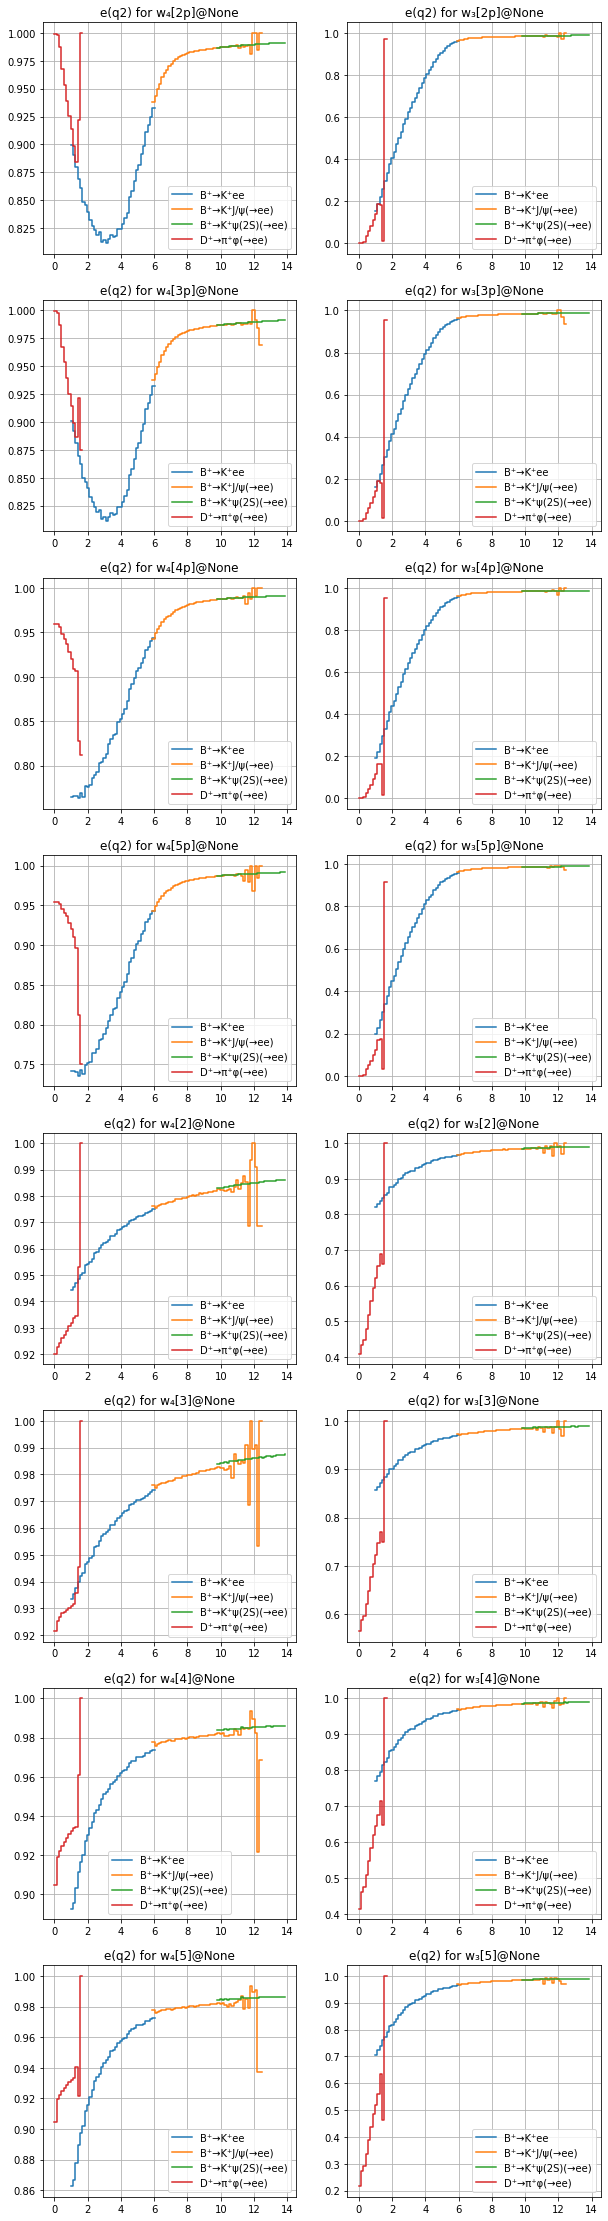

In [80]:
plot_e_all("q2", results, np.linspace(0,14,101))

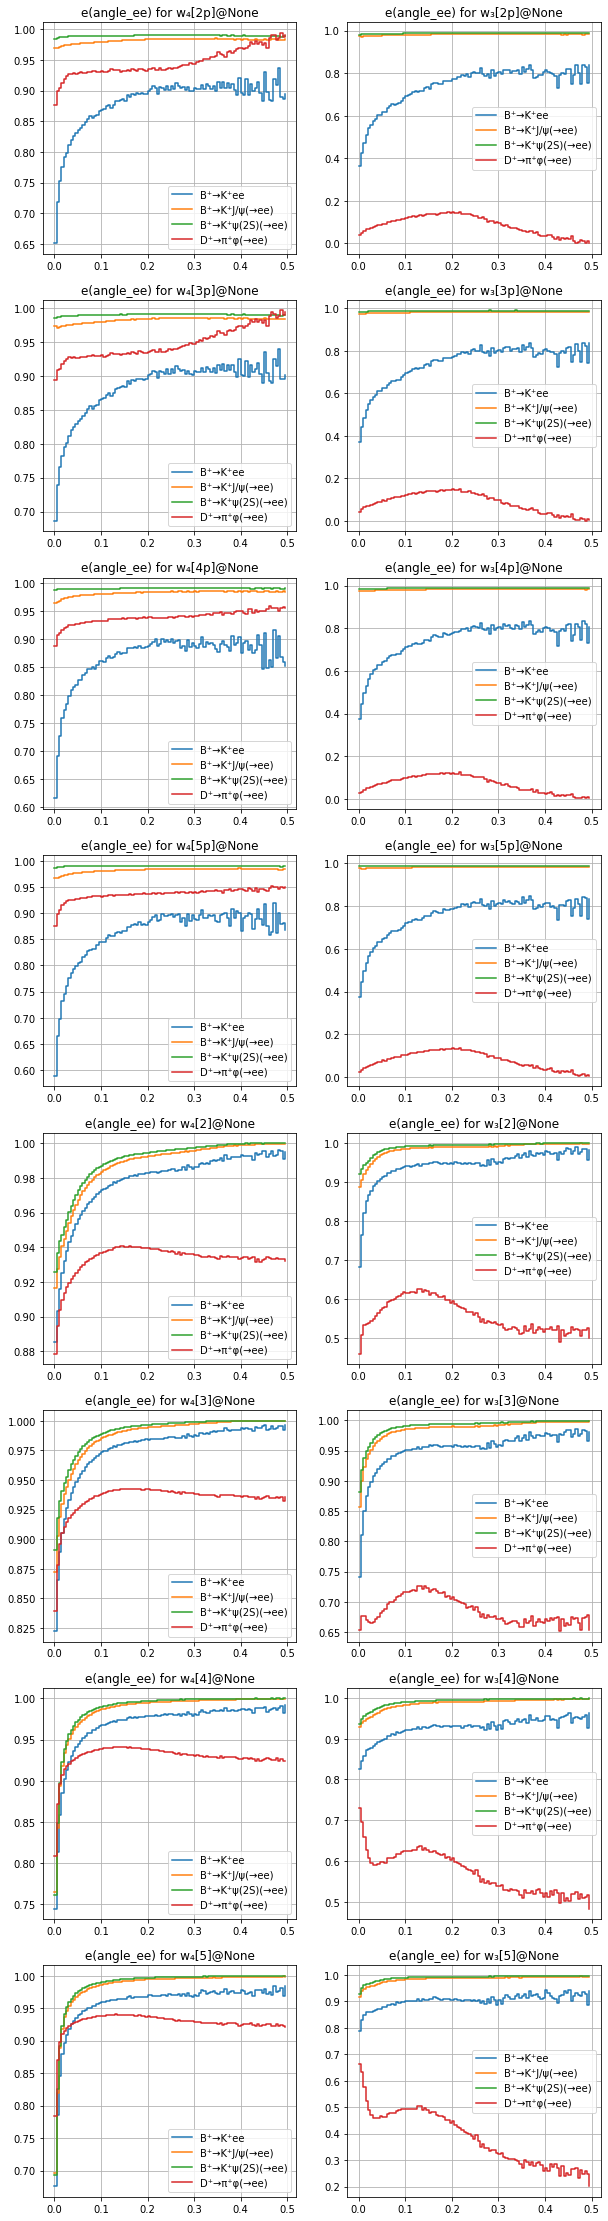

In [81]:
plot_e_all("angle_ee", results, np.linspace(0,0.5,101))

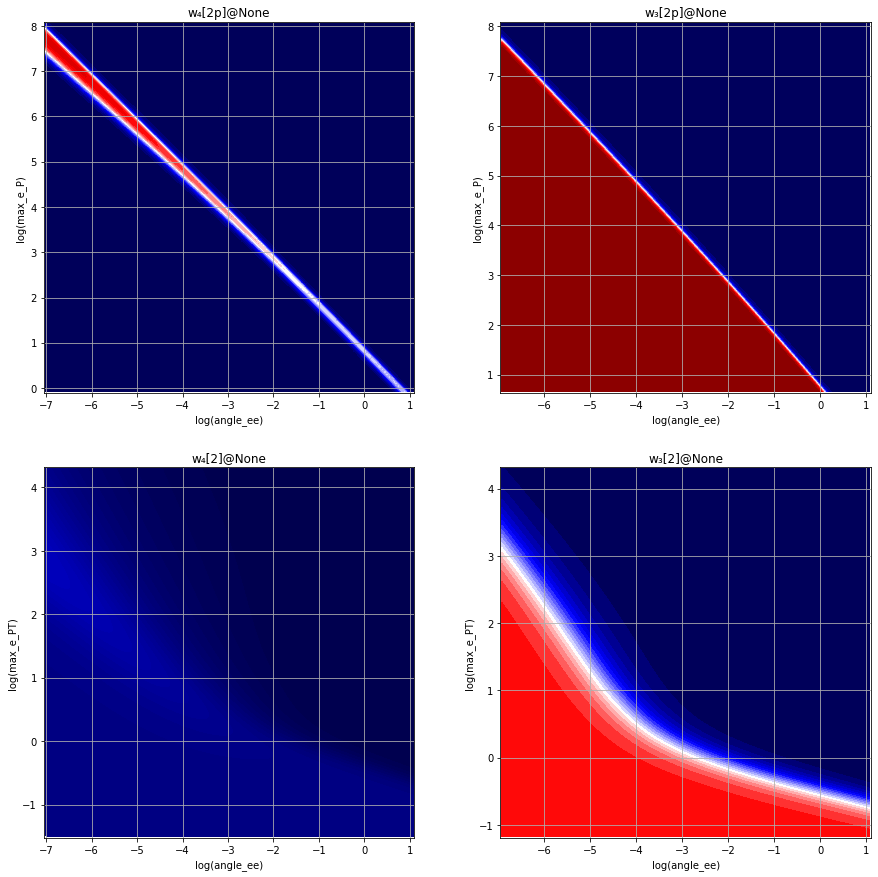

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for j, ds_i in enumerate([0,1,8,9]):
    ds = all_datasets[ds_i]
    ax_ = ax[j//2, j%2]
    w = results[target_L, ds.name]
    sc = w.model[0]
    w_np = as_numpy(lambda x : w.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
plt.show()